# ECSN Profile Comparison

In [1]:
from StarKiller.initialization import starkiller_initialize
from StarKiller.interfaces import EosType
from StarKiller.interfaces import BurnType
from StarKiller.eos import Eos
from StarKiller.network import Network
from StarKiller.models import AmrexAstroModel
from mesa_reader import MesaData
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
%matplotlib inline

## Initialize Starkiller Microphysics

In [2]:
probin_file = "probin_ecsn"

In [3]:
starkiller_initialize(probin_file)

In [4]:
helmholtz = Eos()
ecsn = Network()

In [5]:
def evaluate_rhs(burn_state):
    ecsn.rhs(burn_state)
    return burn_state

def evaluate_eos(burn_state):
    eos_state = burn_state.to_eos_type()
    helmholtz.evaluate(eos_state.eos_input_rt, eos_state)
    return eos_state

## Read MESA profile

In [6]:
mesa_data = MesaData("../../../../profiles/ONe6040-final.data")

In [7]:
mesa_enuc = mesa_data.eps_nuc_mc2 - mesa_data.eps_nuc_neu

In [8]:
shared_species = []

for s in ecsn.short_species_names:
    if s in mesa_data.bulk_names:
        shared_species.append(s)

print("Species shared between MESA and Starkiller networks:\n")
for s in shared_species:
    print(s)

Species shared between MESA and Starkiller networks:

h1
he4
o16
o20
f20
ne20
mg24
si28


## Evaluate the Starkiller equivalent of MESA (eps_nuc_mc2 - eps_nuc_neu)

In [9]:
sk_burn_results = []
sk_eos_results = []

for zi in range(len(mesa_data.zone)):
    density = 10.0**mesa_data.logRho[zi]
    temperature = 10.0**mesa_data.logT[zi]
    
    # Set mass fractions for Starkiller network by zeroing
    # mass fractions for species missing in the MESA network and ignoring
    # species missing in the Starkiller network.
    #
    # Then renormalize the Starkiller mass fractions to sum to 1.
    mass_fractions = []
    
    for s in ecsn.short_species_names:
        if s in mesa_data.bulk_names:
            mass_fractions.append(mesa_data.data(s)[zi])
        else:
            mass_fractions.append(0.0)
    
    mass_fractions = np.array(mass_fractions)
    mass_fractions = mass_fractions/np.sum(mass_fractions)
    
    
    burn_state = BurnType()
    burn_state.state.rho = density
    burn_state.state.t = temperature
    burn_state.state.xn = mass_fractions
    
    # Evaluate the RHS and EOS in Starkiller
    sk_burn_results.append(evaluate_rhs(burn_state))
    sk_eos_results.append(evaluate_eos(burn_state))

In [10]:
sk_eps = []

for burn_state in sk_burn_results:
    sk_eps.append(burn_state.state.ydot[ecsn.net_ienuc])
    
sk_eps = np.array(sk_eps)

## Read MaestroEx initial model

In [11]:
maestro_data = AmrexAstroModel('kepler_xinlong_ONe6040-final.hse.5120')

In [12]:
maestro_data.model_data['logRho'] = np.log10(maestro_data.data('density'))

## Evaluate energy generation rate for MaestroEx initial model

In [13]:
sk_maestro_burn_results = []
sk_maestro_eos_results = []

for zi in range(maestro_data.size):
    mass_fractions = []
    
    for s in ecsn.short_species_names:
        mass_fractions.append(maestro_data.data(s)[zi])

    mass_fractions = np.array(mass_fractions)
    mass_fractions = mass_fractions/np.sum(mass_fractions)
    
    burn_state = BurnType()
    burn_state.state.rho = maestro_data.data('density')[zi]
    burn_state.state.t = maestro_data.data('temperature')[zi]
    burn_state.state.xn = mass_fractions
    
    # Evaluate the RHS and EOS in Starkiller
    sk_maestro_burn_results.append(evaluate_rhs(burn_state))
    sk_maestro_eos_results.append(evaluate_eos(burn_state))

In [14]:
sk_maestro_eps = []

for burn_state in sk_maestro_burn_results:
    sk_maestro_eps.append(burn_state.state.ydot[ecsn.net_ienuc])
    
sk_maestro_eps = np.array(sk_maestro_eps)

## Plot MESA, Starkiller-MESA, and Starkiller-Maestro energy generation rates

In [15]:
font_config = {'size': 20}
text_config = {'usetex': True}
figure_config = {'dpi': 300}

matplotlib.rc('font', **font_config)
matplotlib.rc('text', **text_config)
matplotlib.rc('figure', **figure_config)

mesa_enuc_pos = np.maximum(mesa_enuc, 0.0)
mesa_enuc_neg = np.maximum(-mesa_enuc, 0.0)

sk_enuc_pos = np.maximum(sk_eps, 0.0)
sk_enuc_neg = np.maximum(-sk_eps, 0.0)

sk_maestro_enuc_pos = np.maximum(sk_maestro_eps, 0.0)
sk_maestro_enuc_neg = np.maximum(-sk_maestro_eps, 0.0)

radius_km = mesa_data.radius_cm * 1.0e-5

# The order of zones in MESA and Maestro are reverse from each other
# so define a separate radius array for the Maestro data
maestro_radius_km = maestro_data.data('radius') * 1.0e-5

def plot_enuc(xlim=None, ylim=None):
    fig, ax = plt.subplots(facecolor='w')
    fig.set_figheight(10.0)
    fig.set_figwidth(10.0)

    ax.plot(radius_km, mesa_enuc_pos, color='b', linestyle='-', 
            label=r'$\mathrm{MESA}$ $\dot{\varepsilon} > 0$')
    
    ax.plot(radius_km, mesa_enuc_neg, color='b', linestyle=':', 
            label=r'$\mathrm{MESA}$ $\dot{\varepsilon} < 0$')

    ax.plot(radius_km, sk_enuc_pos, color='g', linestyle='-', 
            label=r'$\mathrm{StarKiller-MESA}$ $\dot{\varepsilon} > 0$')
    
    ax.plot(radius_km, sk_enuc_neg, color='g', linestyle=':', 
            label=r'$\mathrm{StarKiller-MESA}$ $\dot{\varepsilon} < 0$')

    ax.plot(maestro_radius_km, sk_maestro_enuc_pos, color='m', linestyle='-', 
            label=r'$\mathrm{StarKiller-Maestro}$ $\dot{\varepsilon} > 0$')
    
    ax.plot(maestro_radius_km, sk_maestro_enuc_neg, color='m', linestyle=':', 
            label=r'$\mathrm{StarKiller-Maestro}$ $\dot{\varepsilon} < 0$')
    
    ax.set_yscale('log')
    
    if xlim:
        ax.set_xlim(xlim)
        
    if ylim:
        ax.set_ylim(ylim)

    ax.set_xlabel(r'$\mathrm{r\ (km)}$')
    ax.set_ylabel(r'$\dot{\varepsilon} = \dot{\varepsilon}_{m c^2} - |\dot{\varepsilon}_{\nu}|$')
    ax.legend(loc='upper left', bbox_to_anchor=(1.0, 1.0))

    plt.show()

In [16]:
def plot_field(xlim=None, ylim=None, field="temperature", logy=False):
    fig, ax = plt.subplots(facecolor='w')
    fig.set_figheight(10.0)
    fig.set_figwidth(10.0)

    ax.plot(radius_km, mesa_data.data(field), color='b', 
            label=r'$\mathrm{MESA}$')
    ax.plot(maestro_radius_km, maestro_data.data(field), color='m', 
            label=r'$\mathrm{Maestro}$')

    if xlim:
        ax.set_xlim(xlim)
        
    if ylim:
        ax.set_ylim(ylim)
        
    if logy:
        ax.set_yscale('log')

    ax.set_xlabel(r'$\mathrm{r\ (km)}$')
    ax.set_ylabel(r'$\mathrm{' + '{}'.format(field) + r'}$')
    ax.legend(loc='upper left', bbox_to_anchor=(1.0, 1.0))

    plt.show()

### Entire Profile

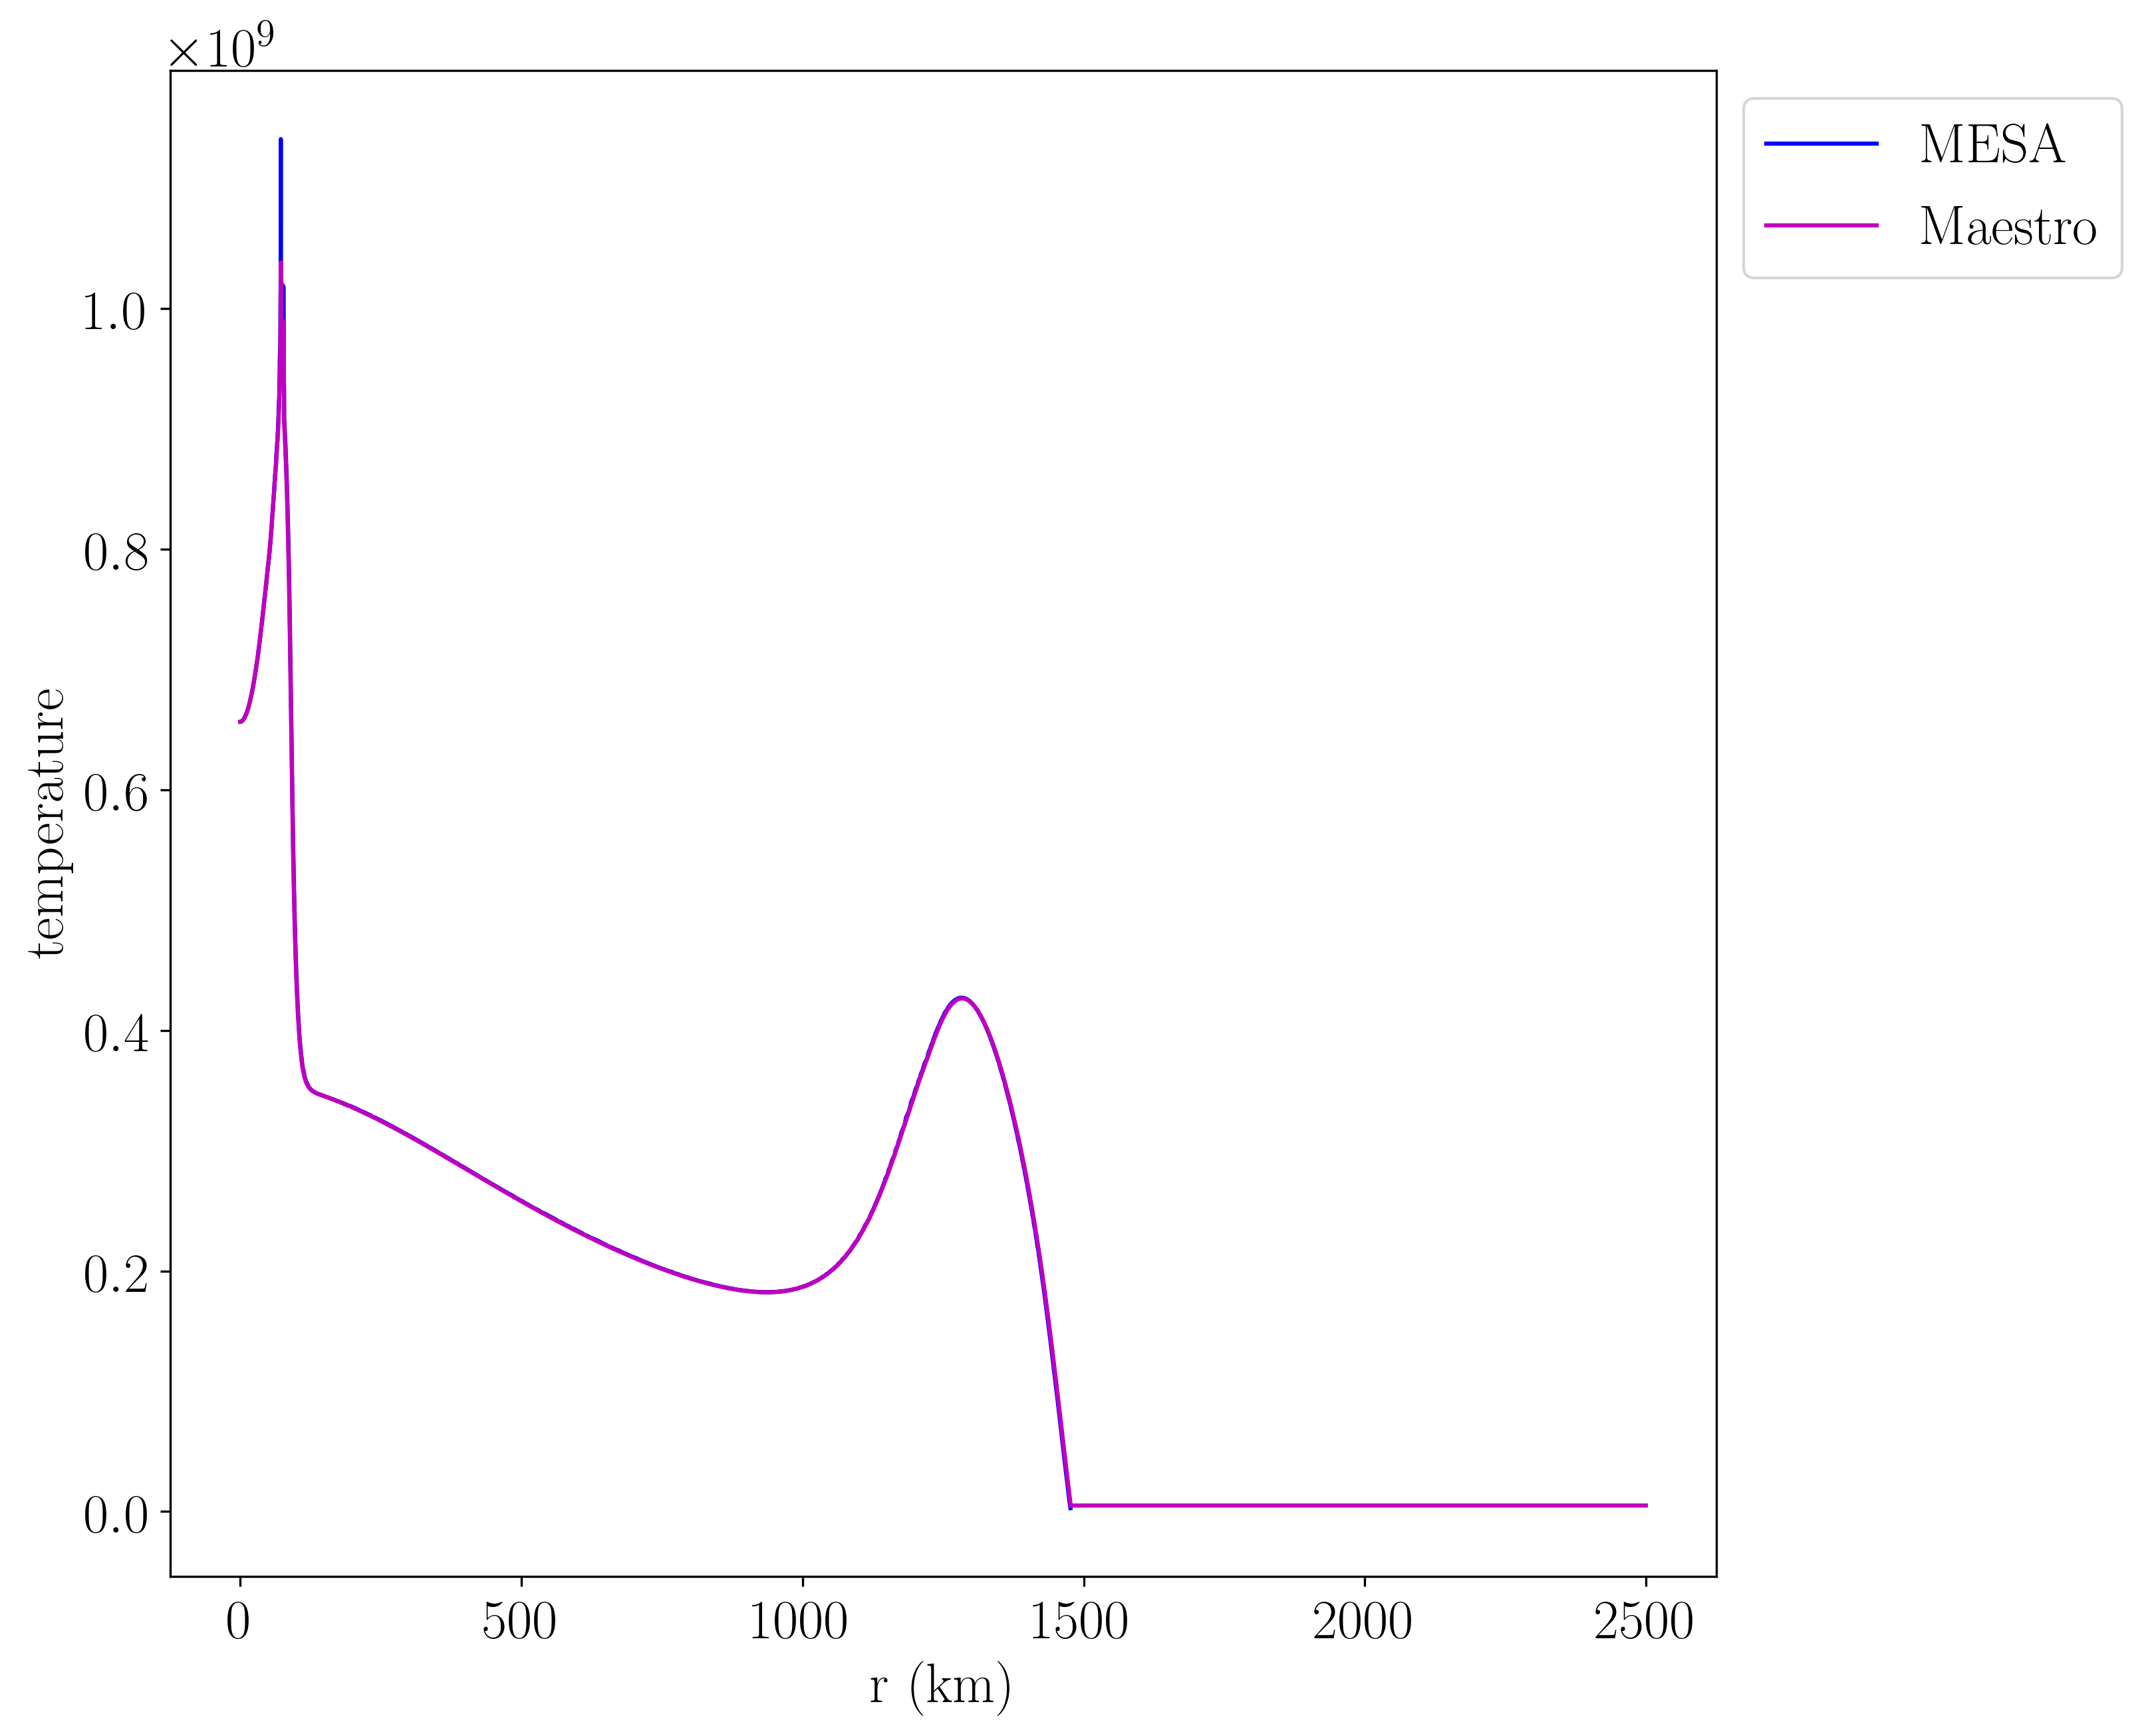

In [17]:
plot_field(field='temperature')

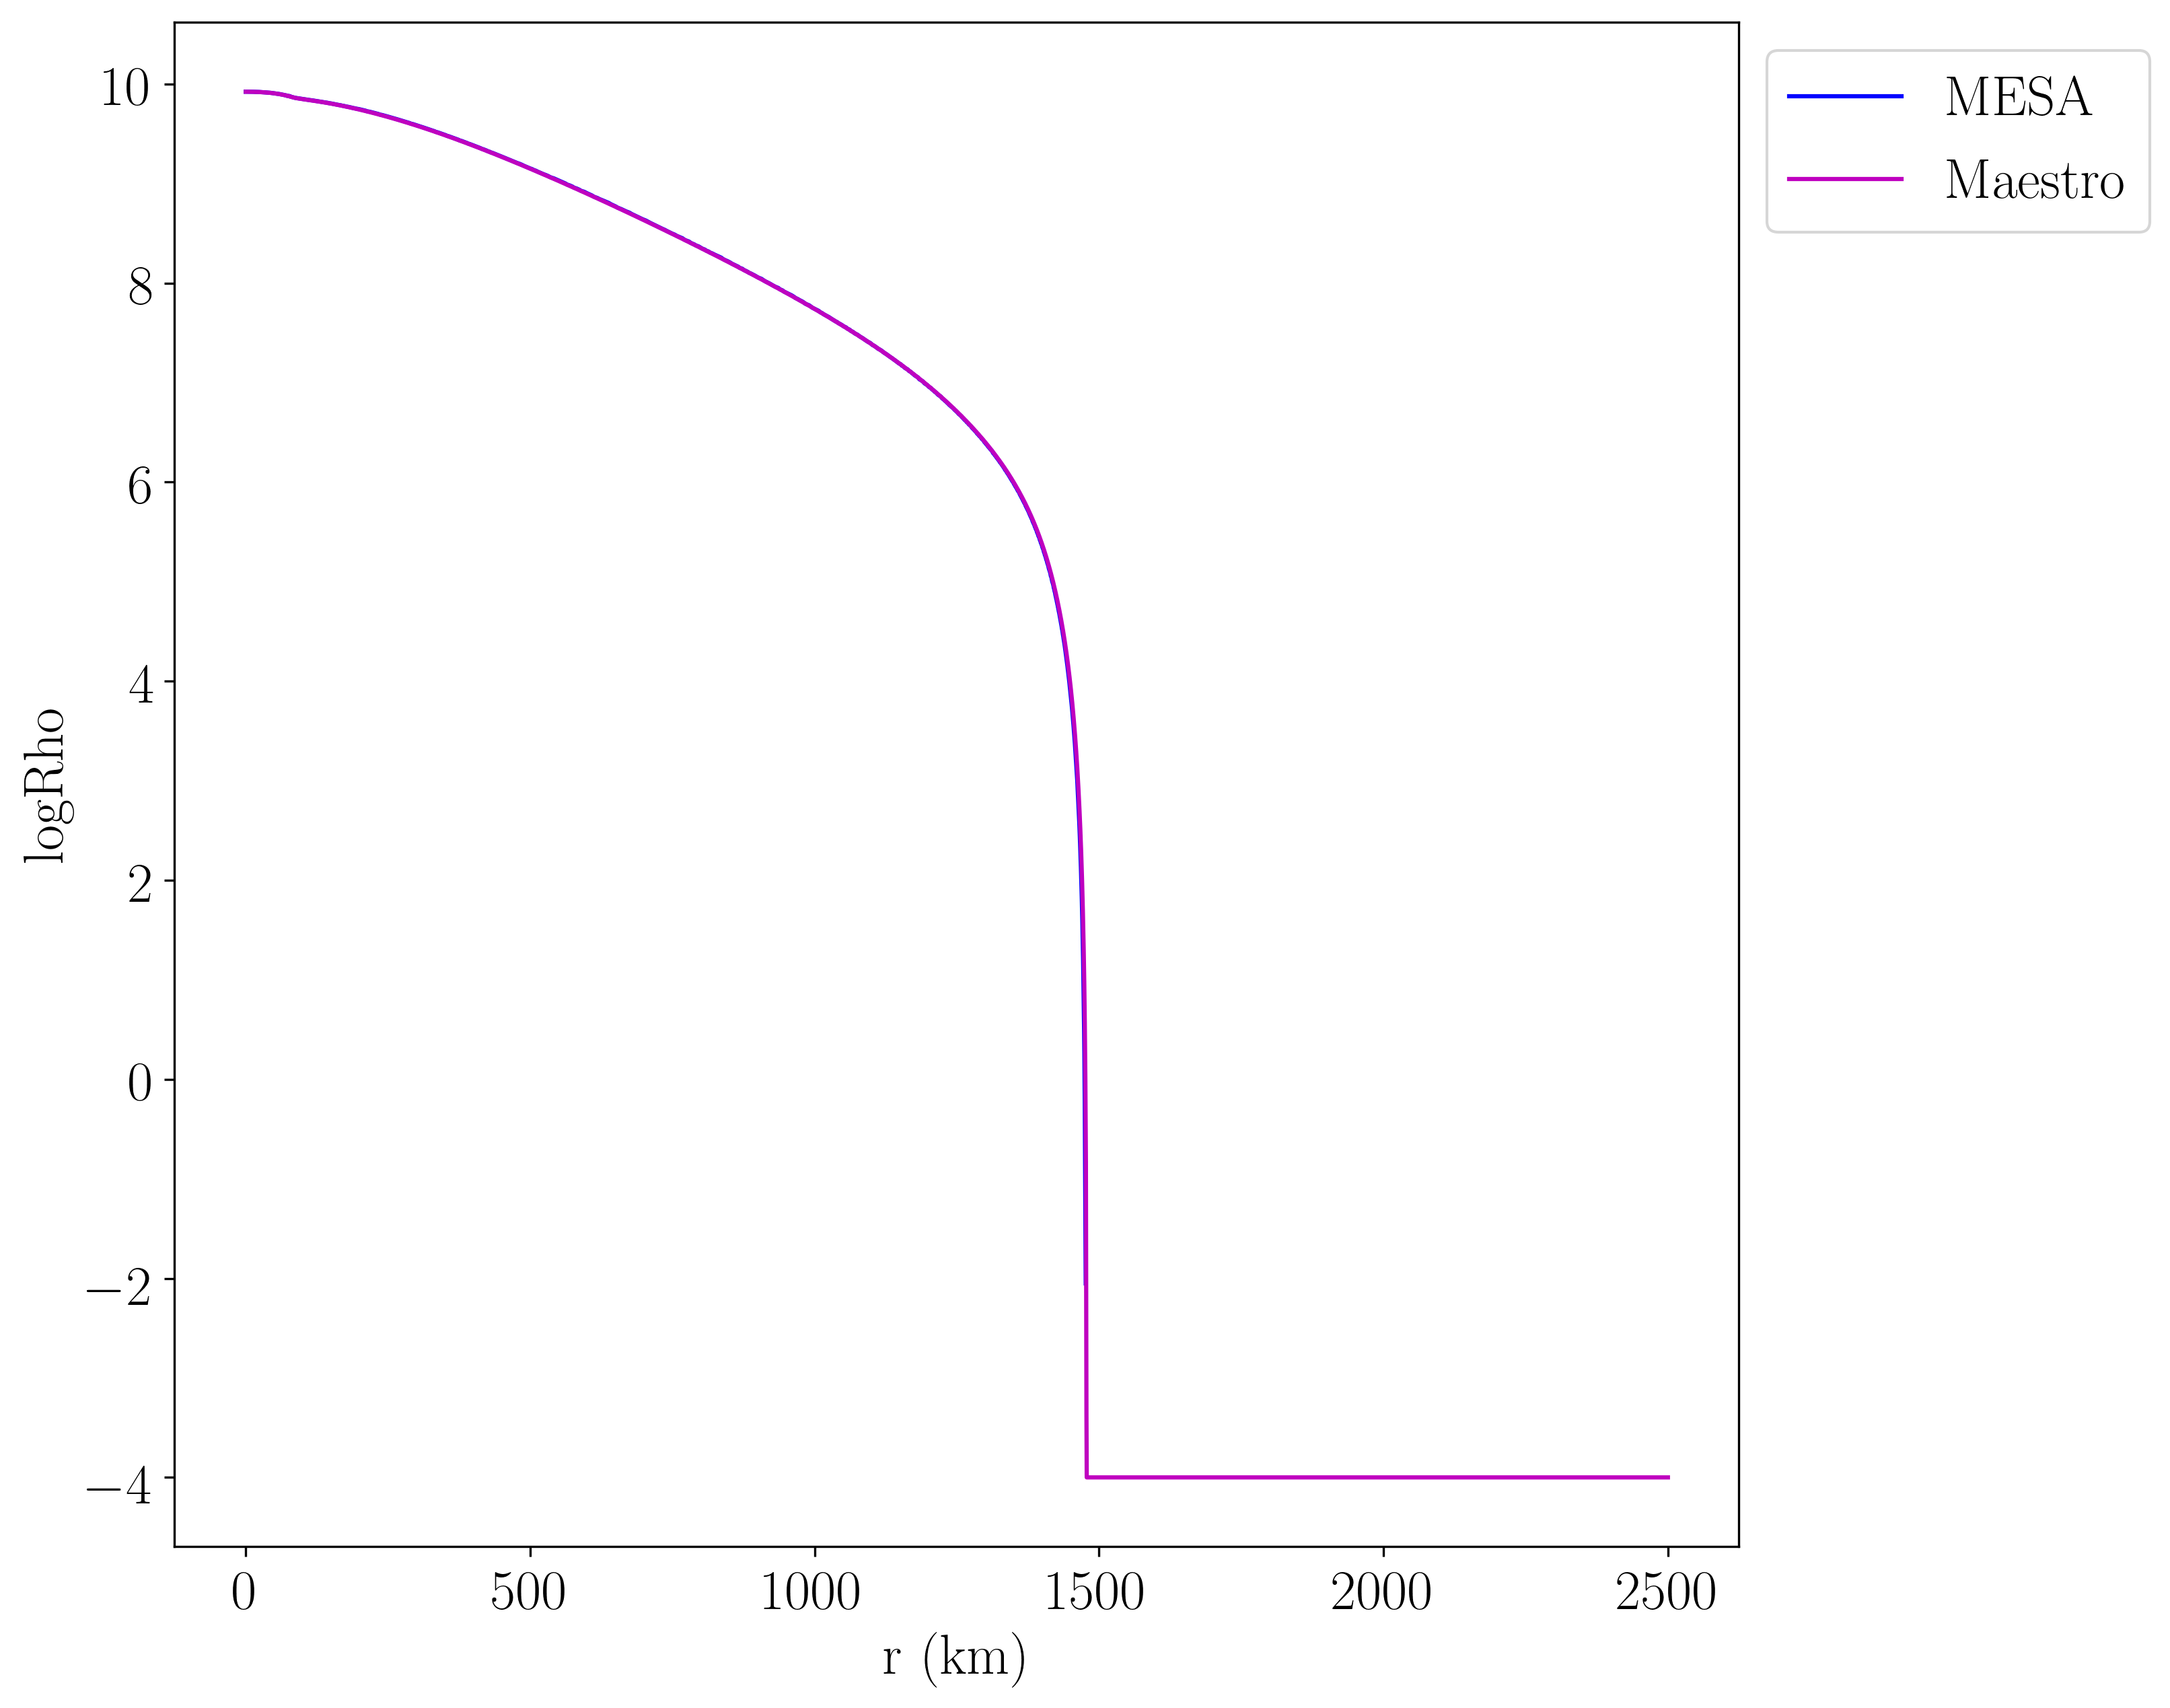

In [18]:
plot_field(field='logRho')

### Plot mass fractions for species shared between MESA and Maestro

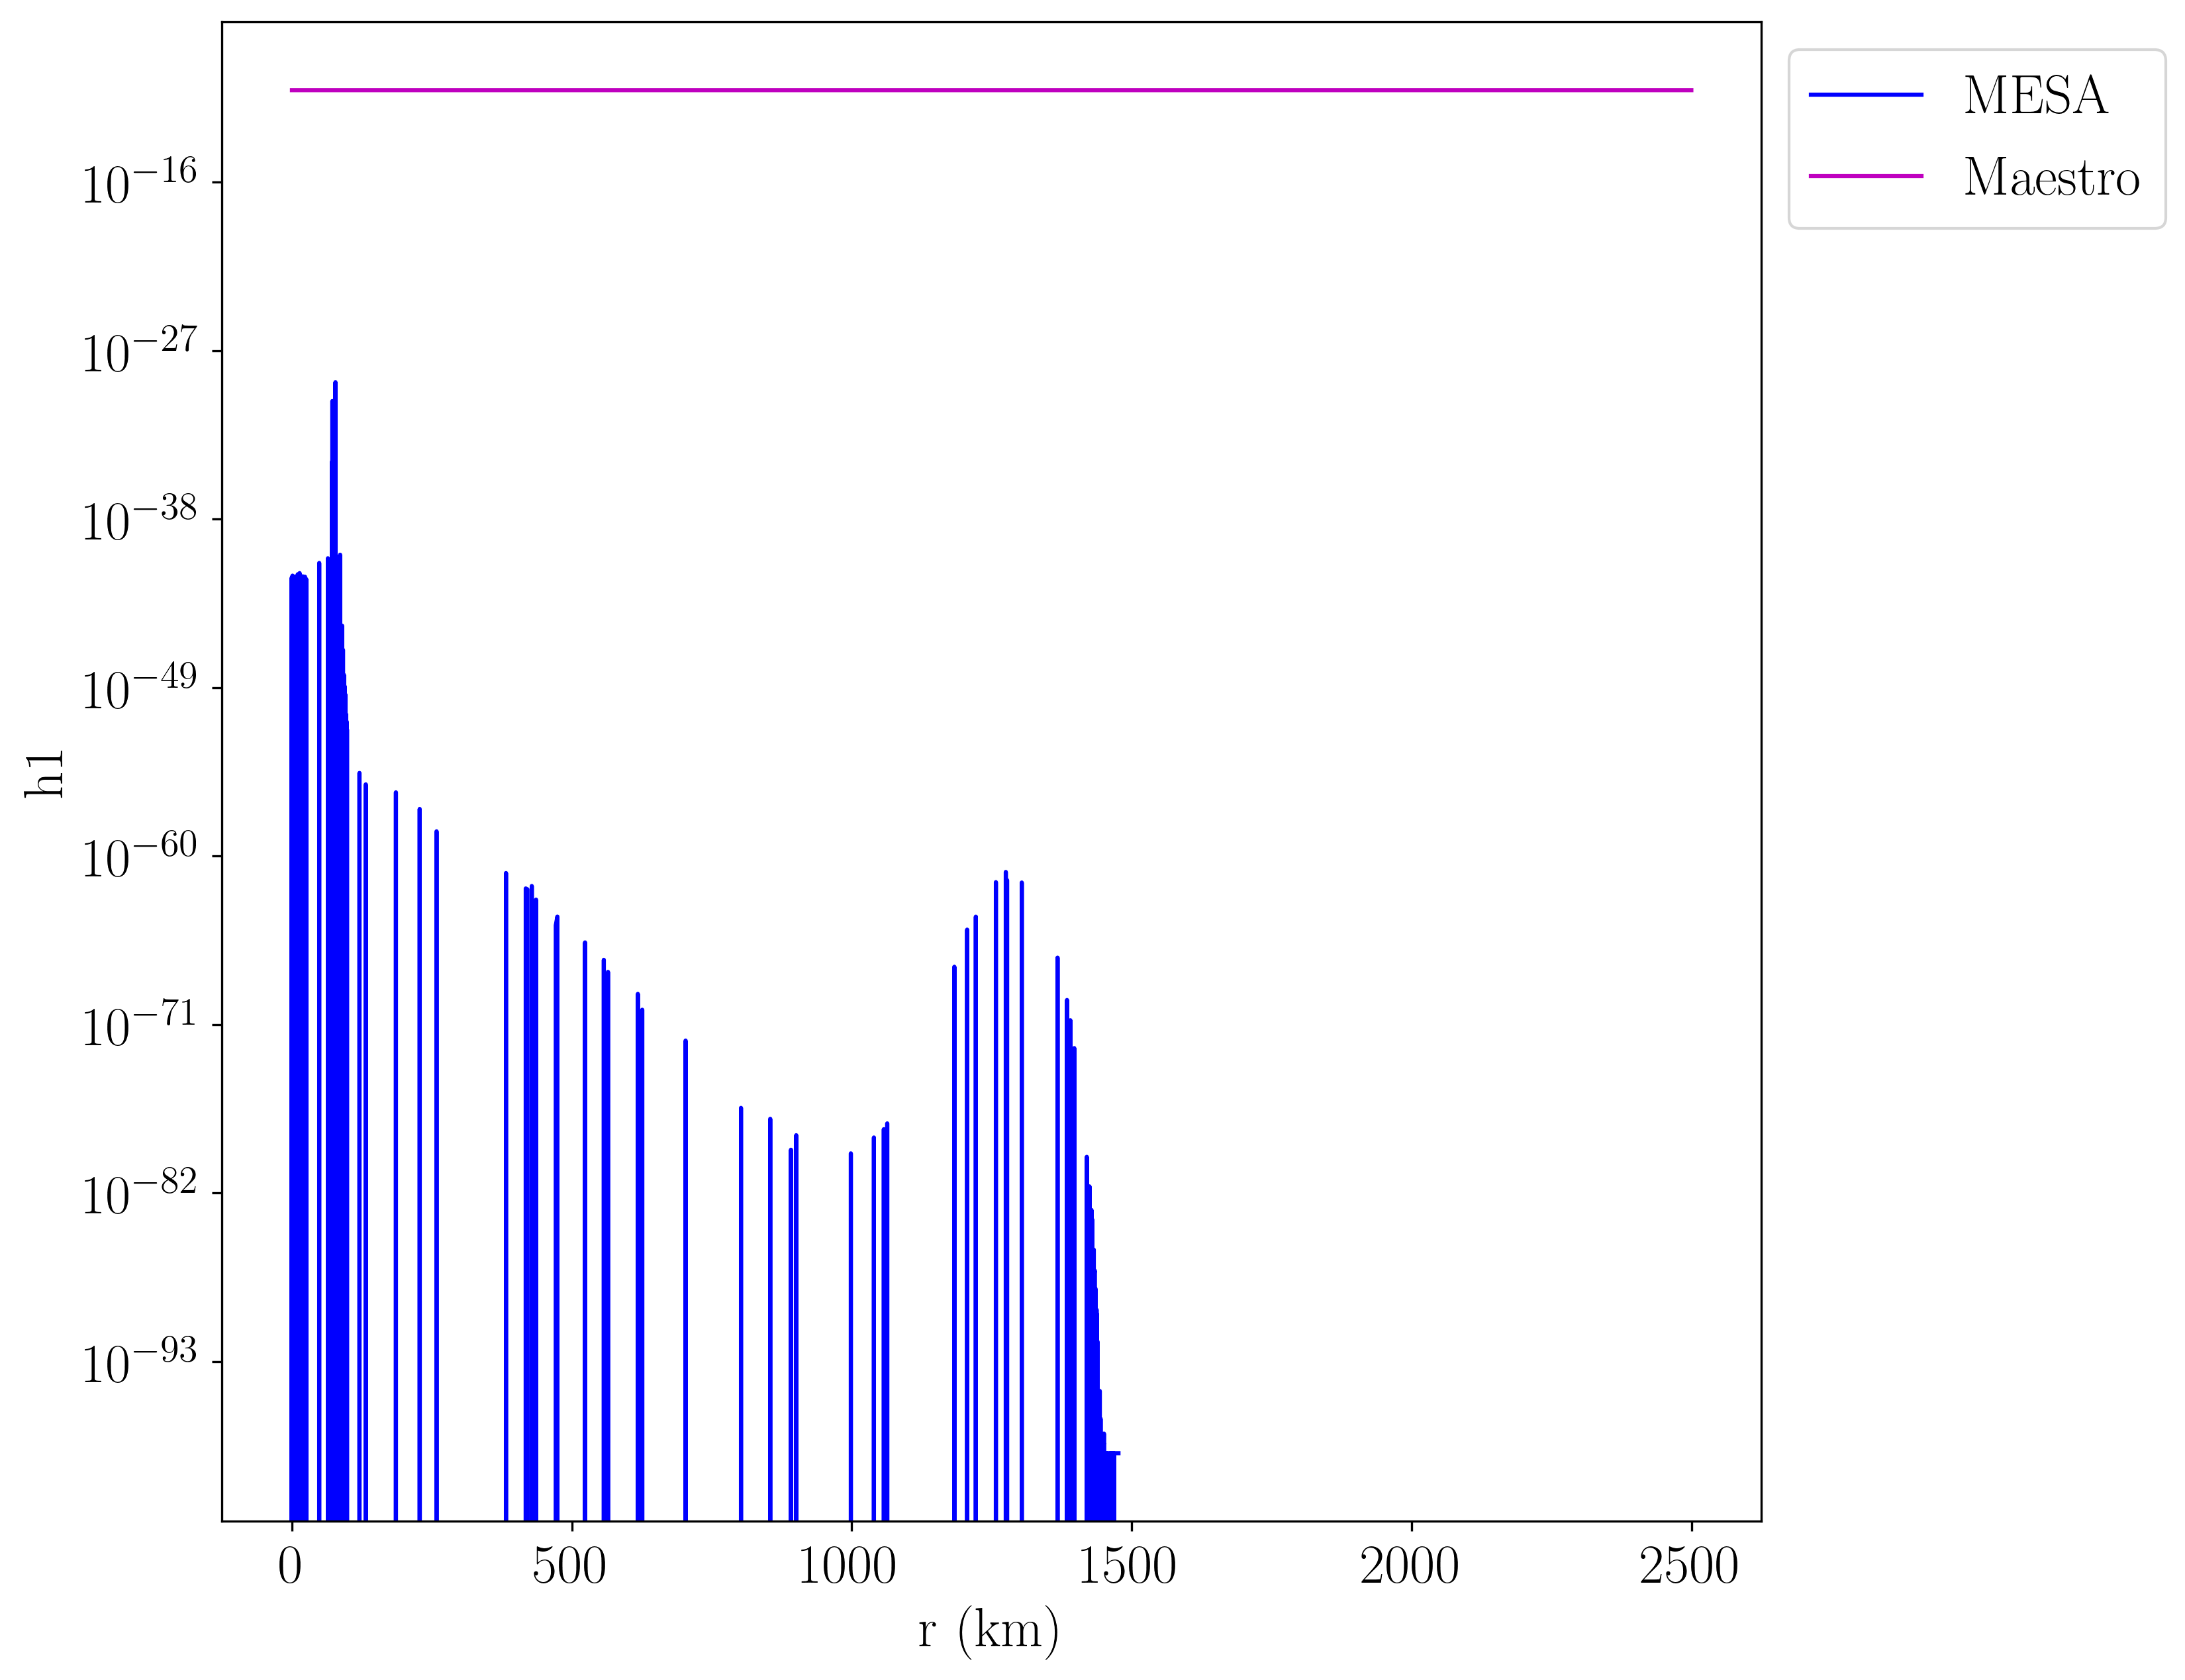

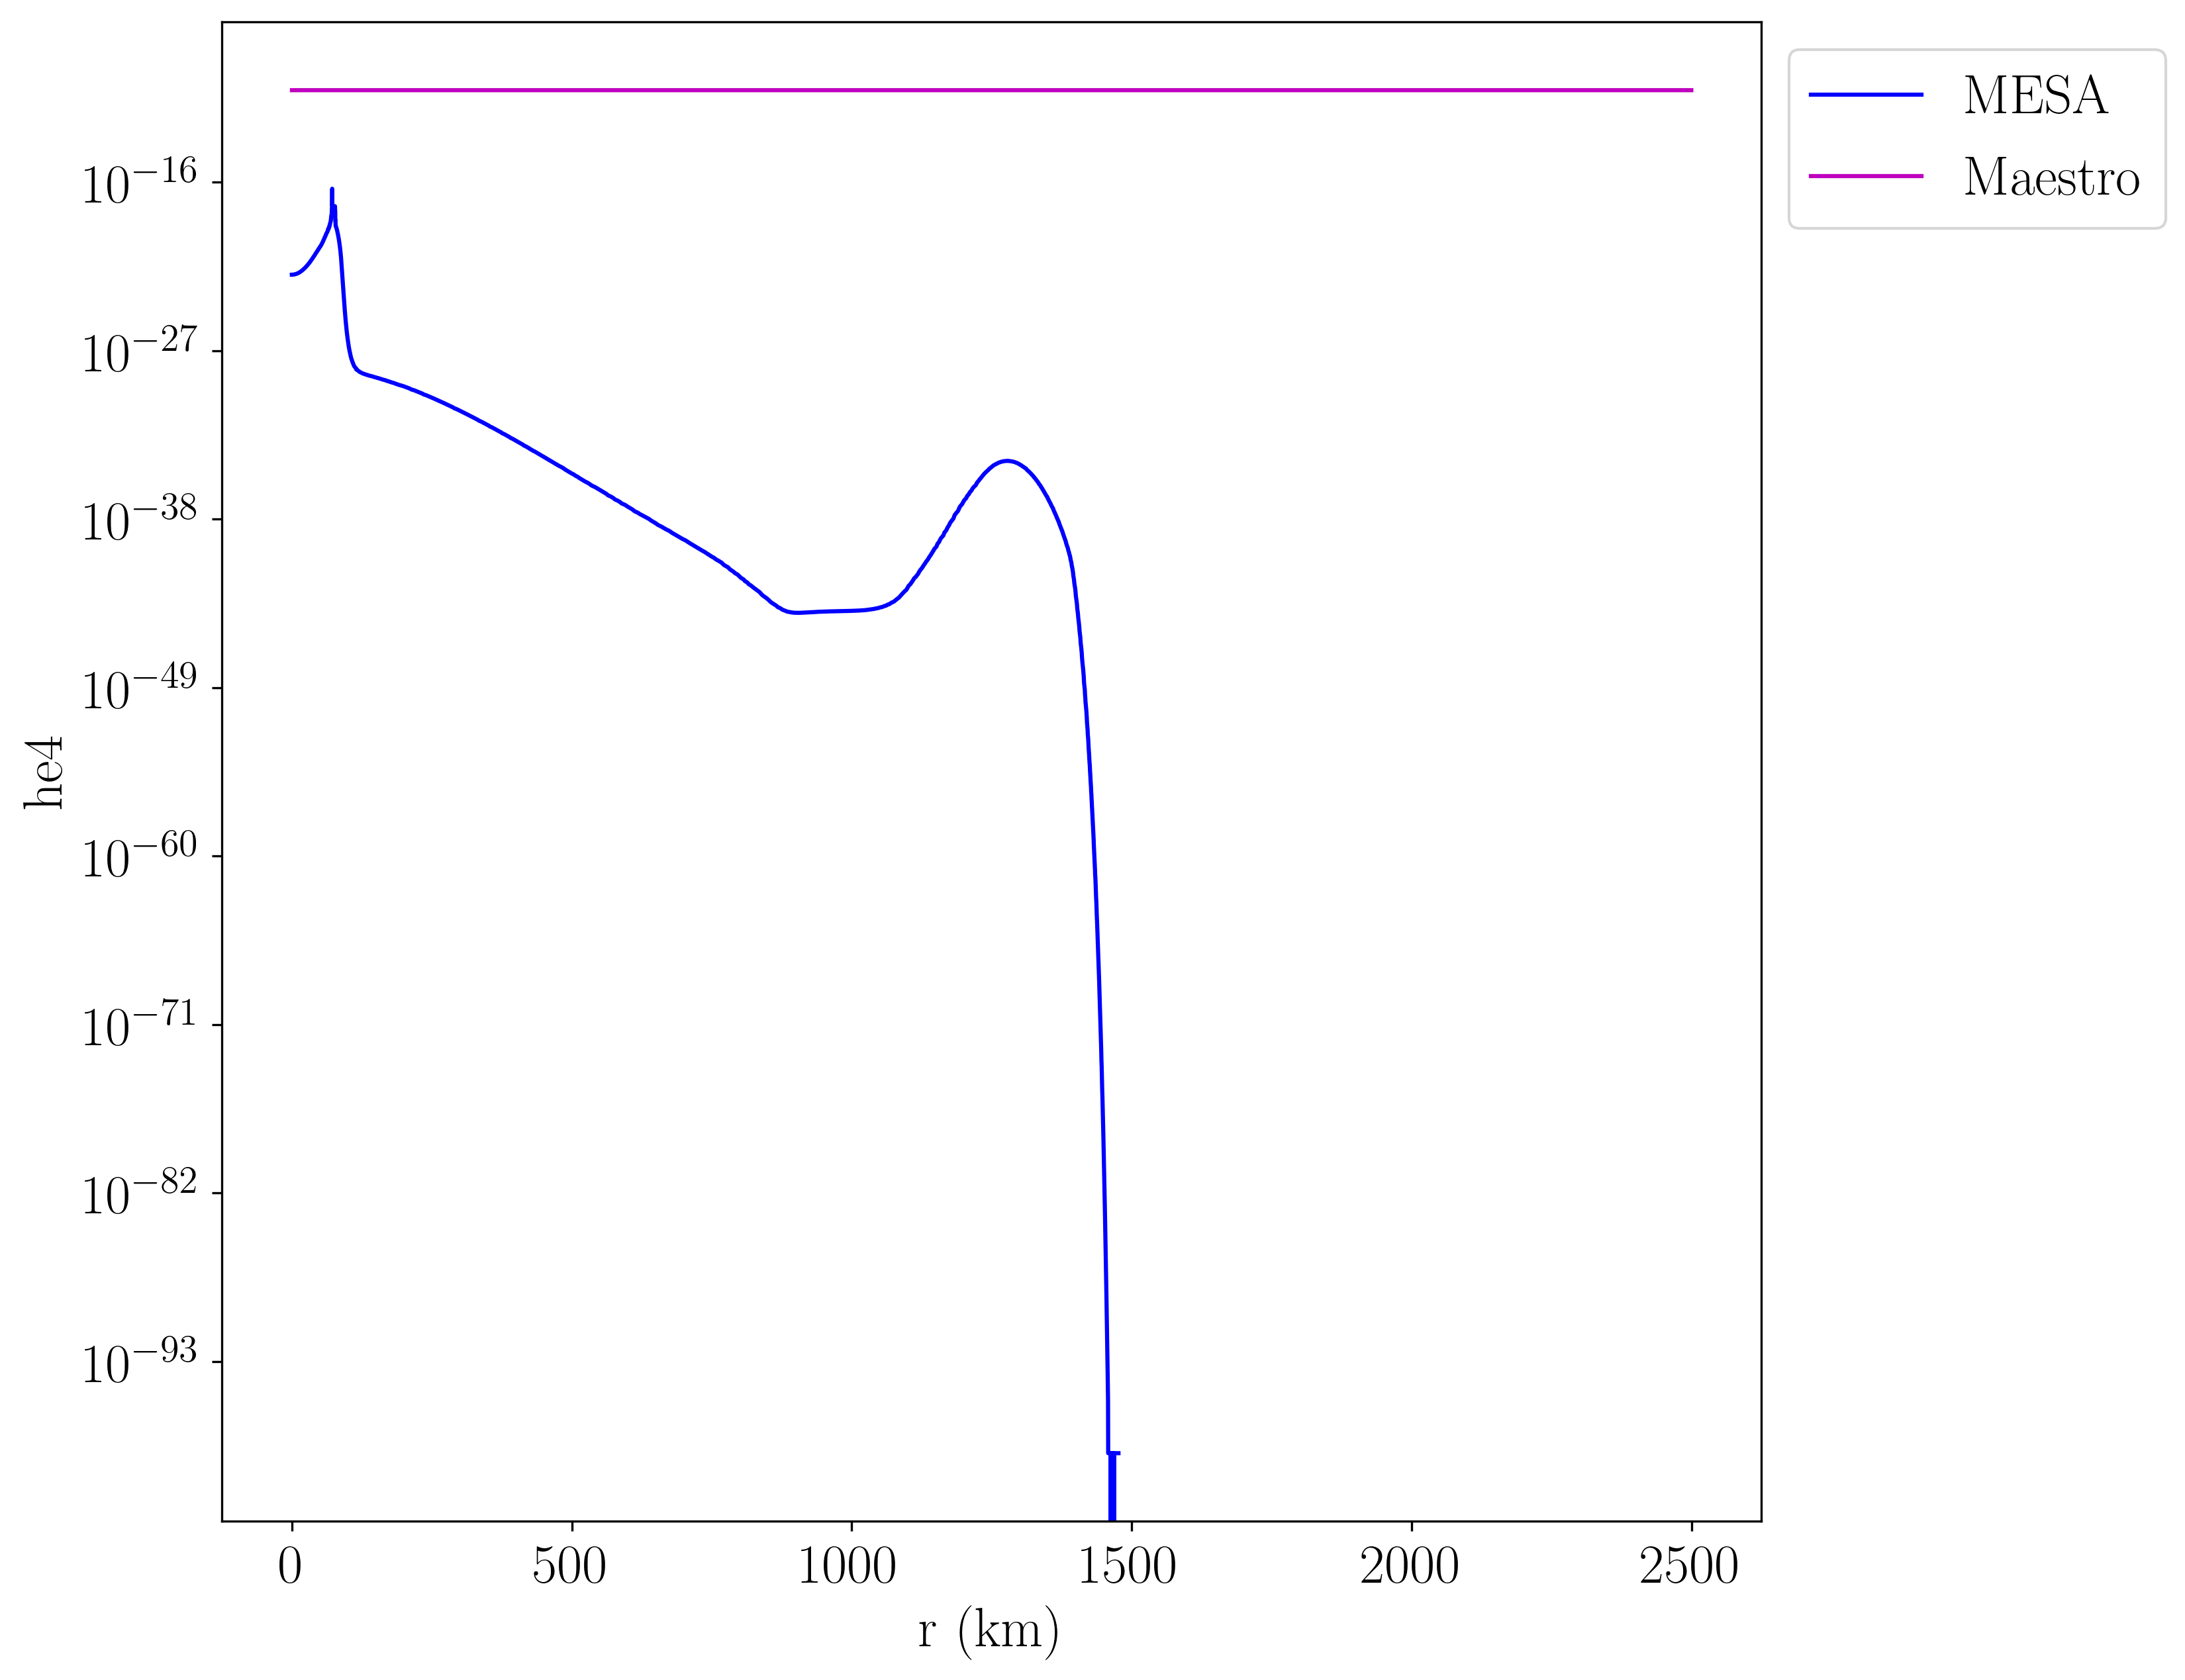

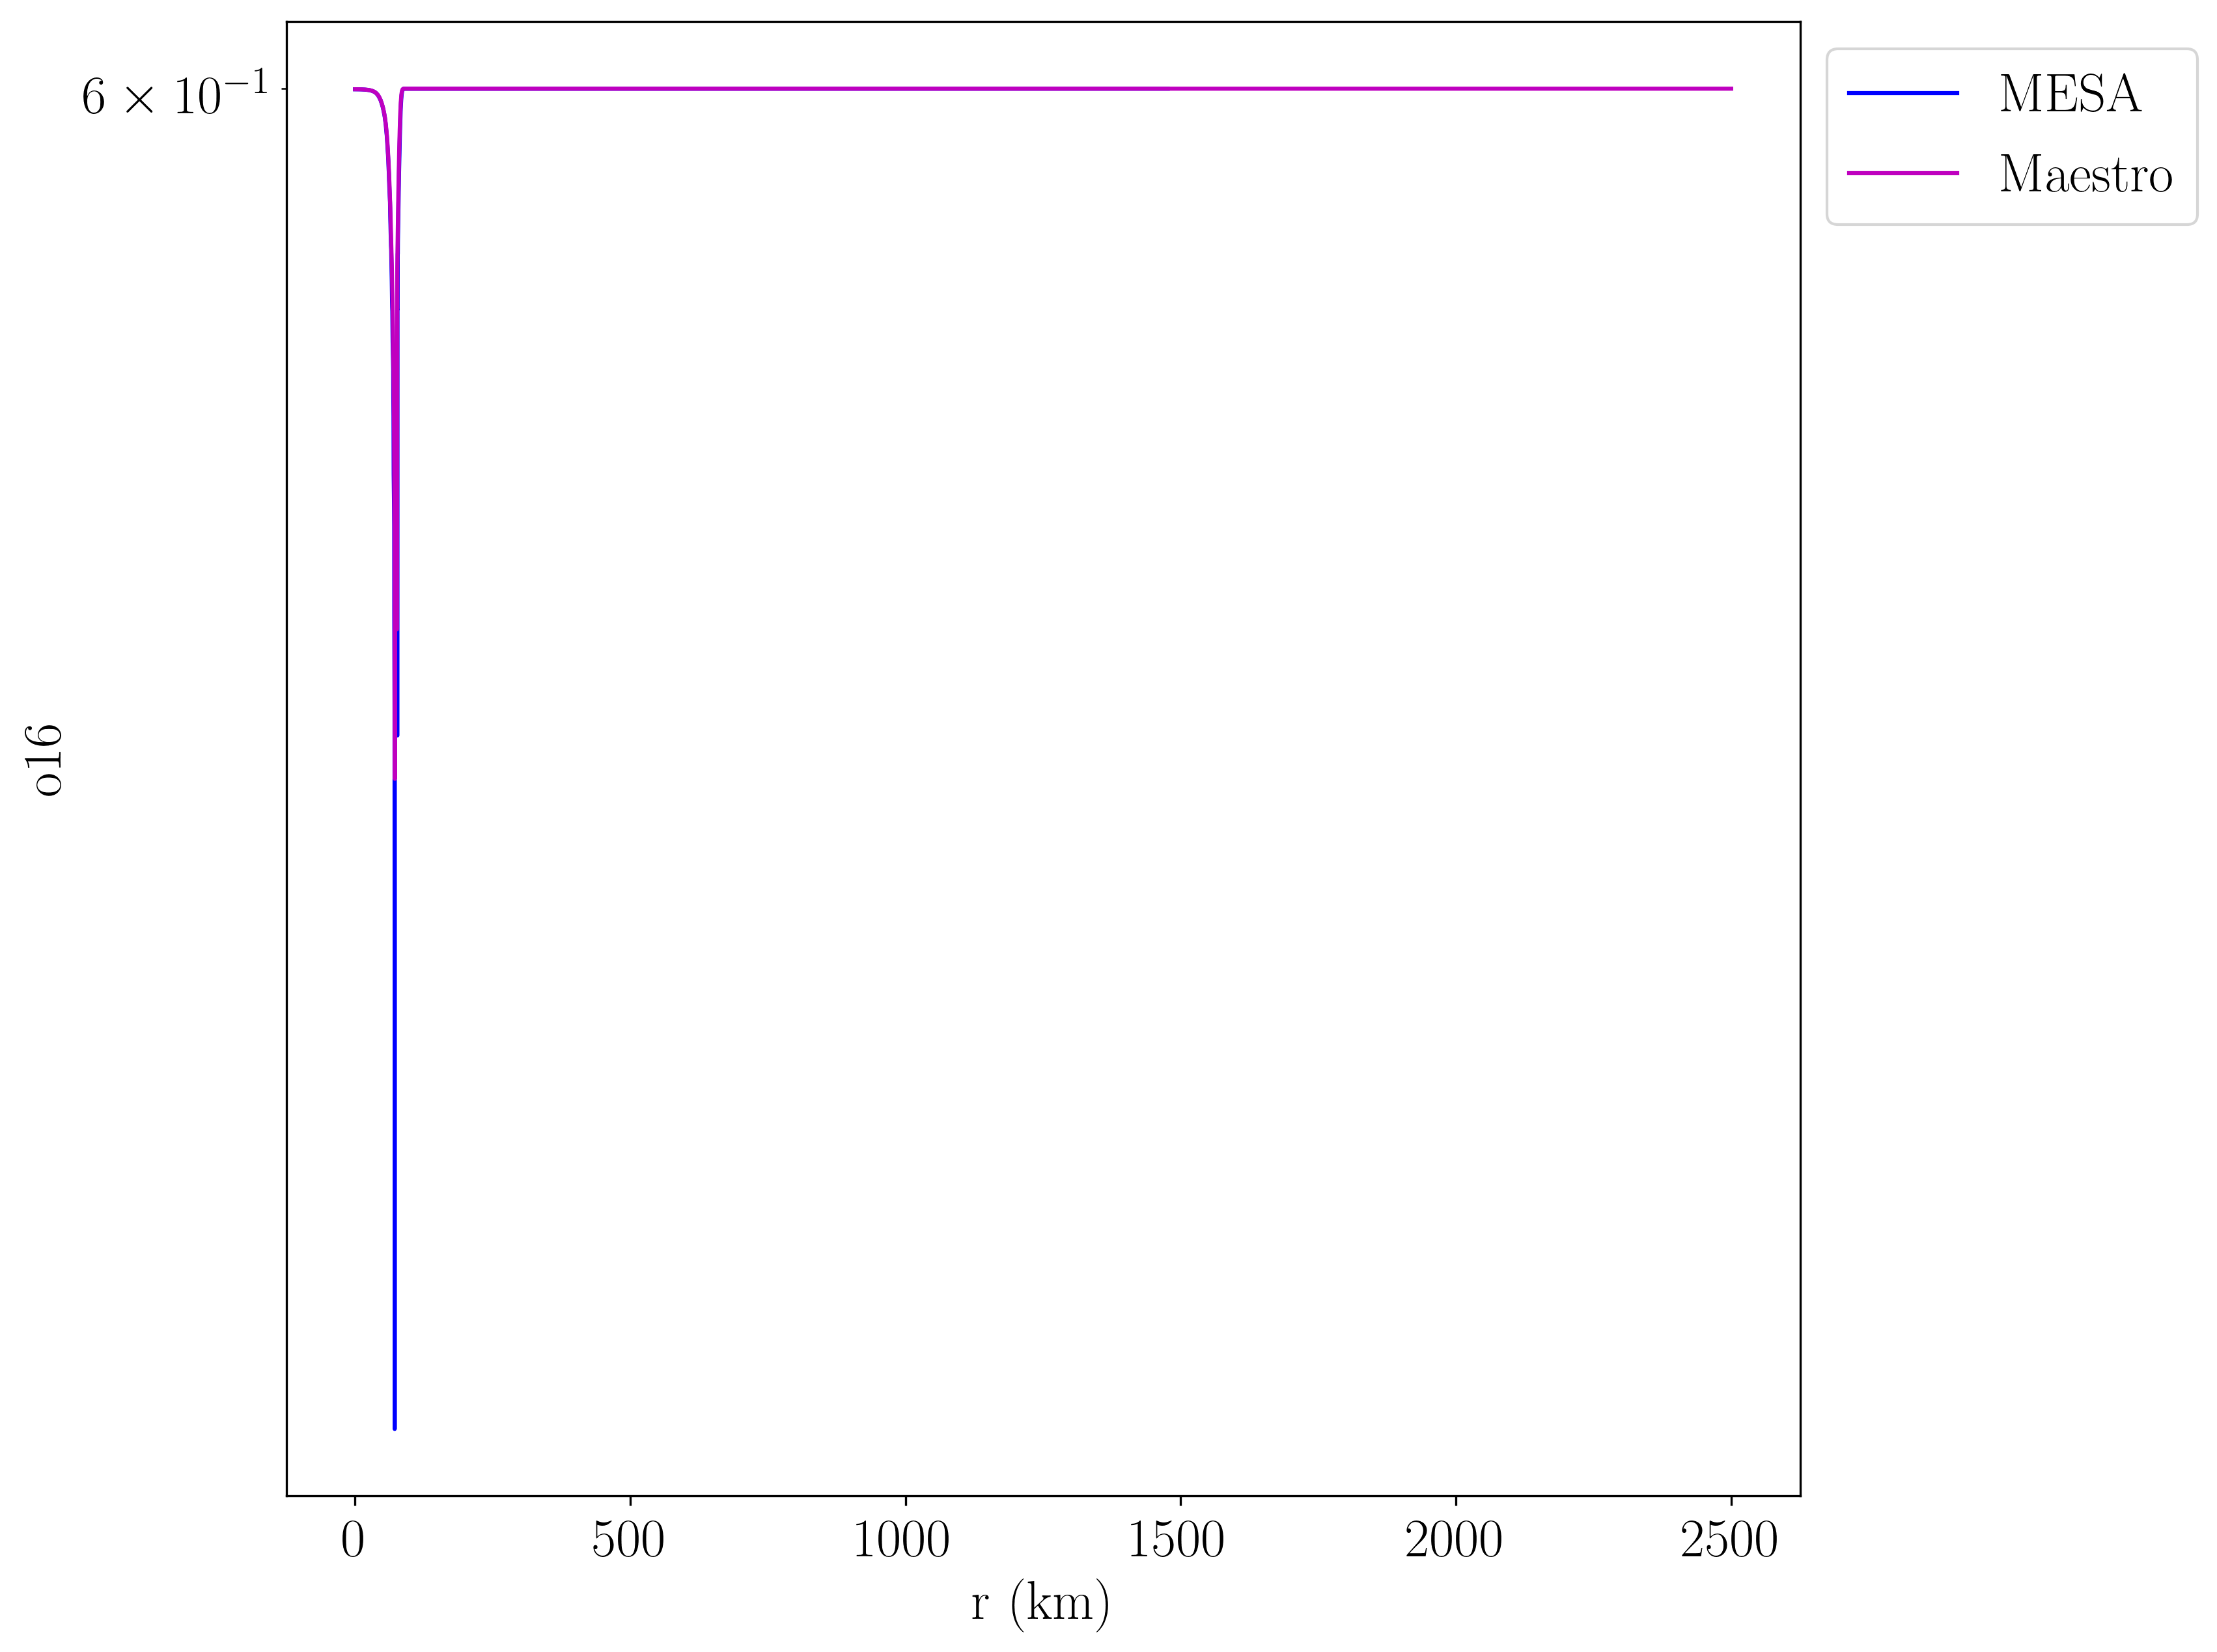

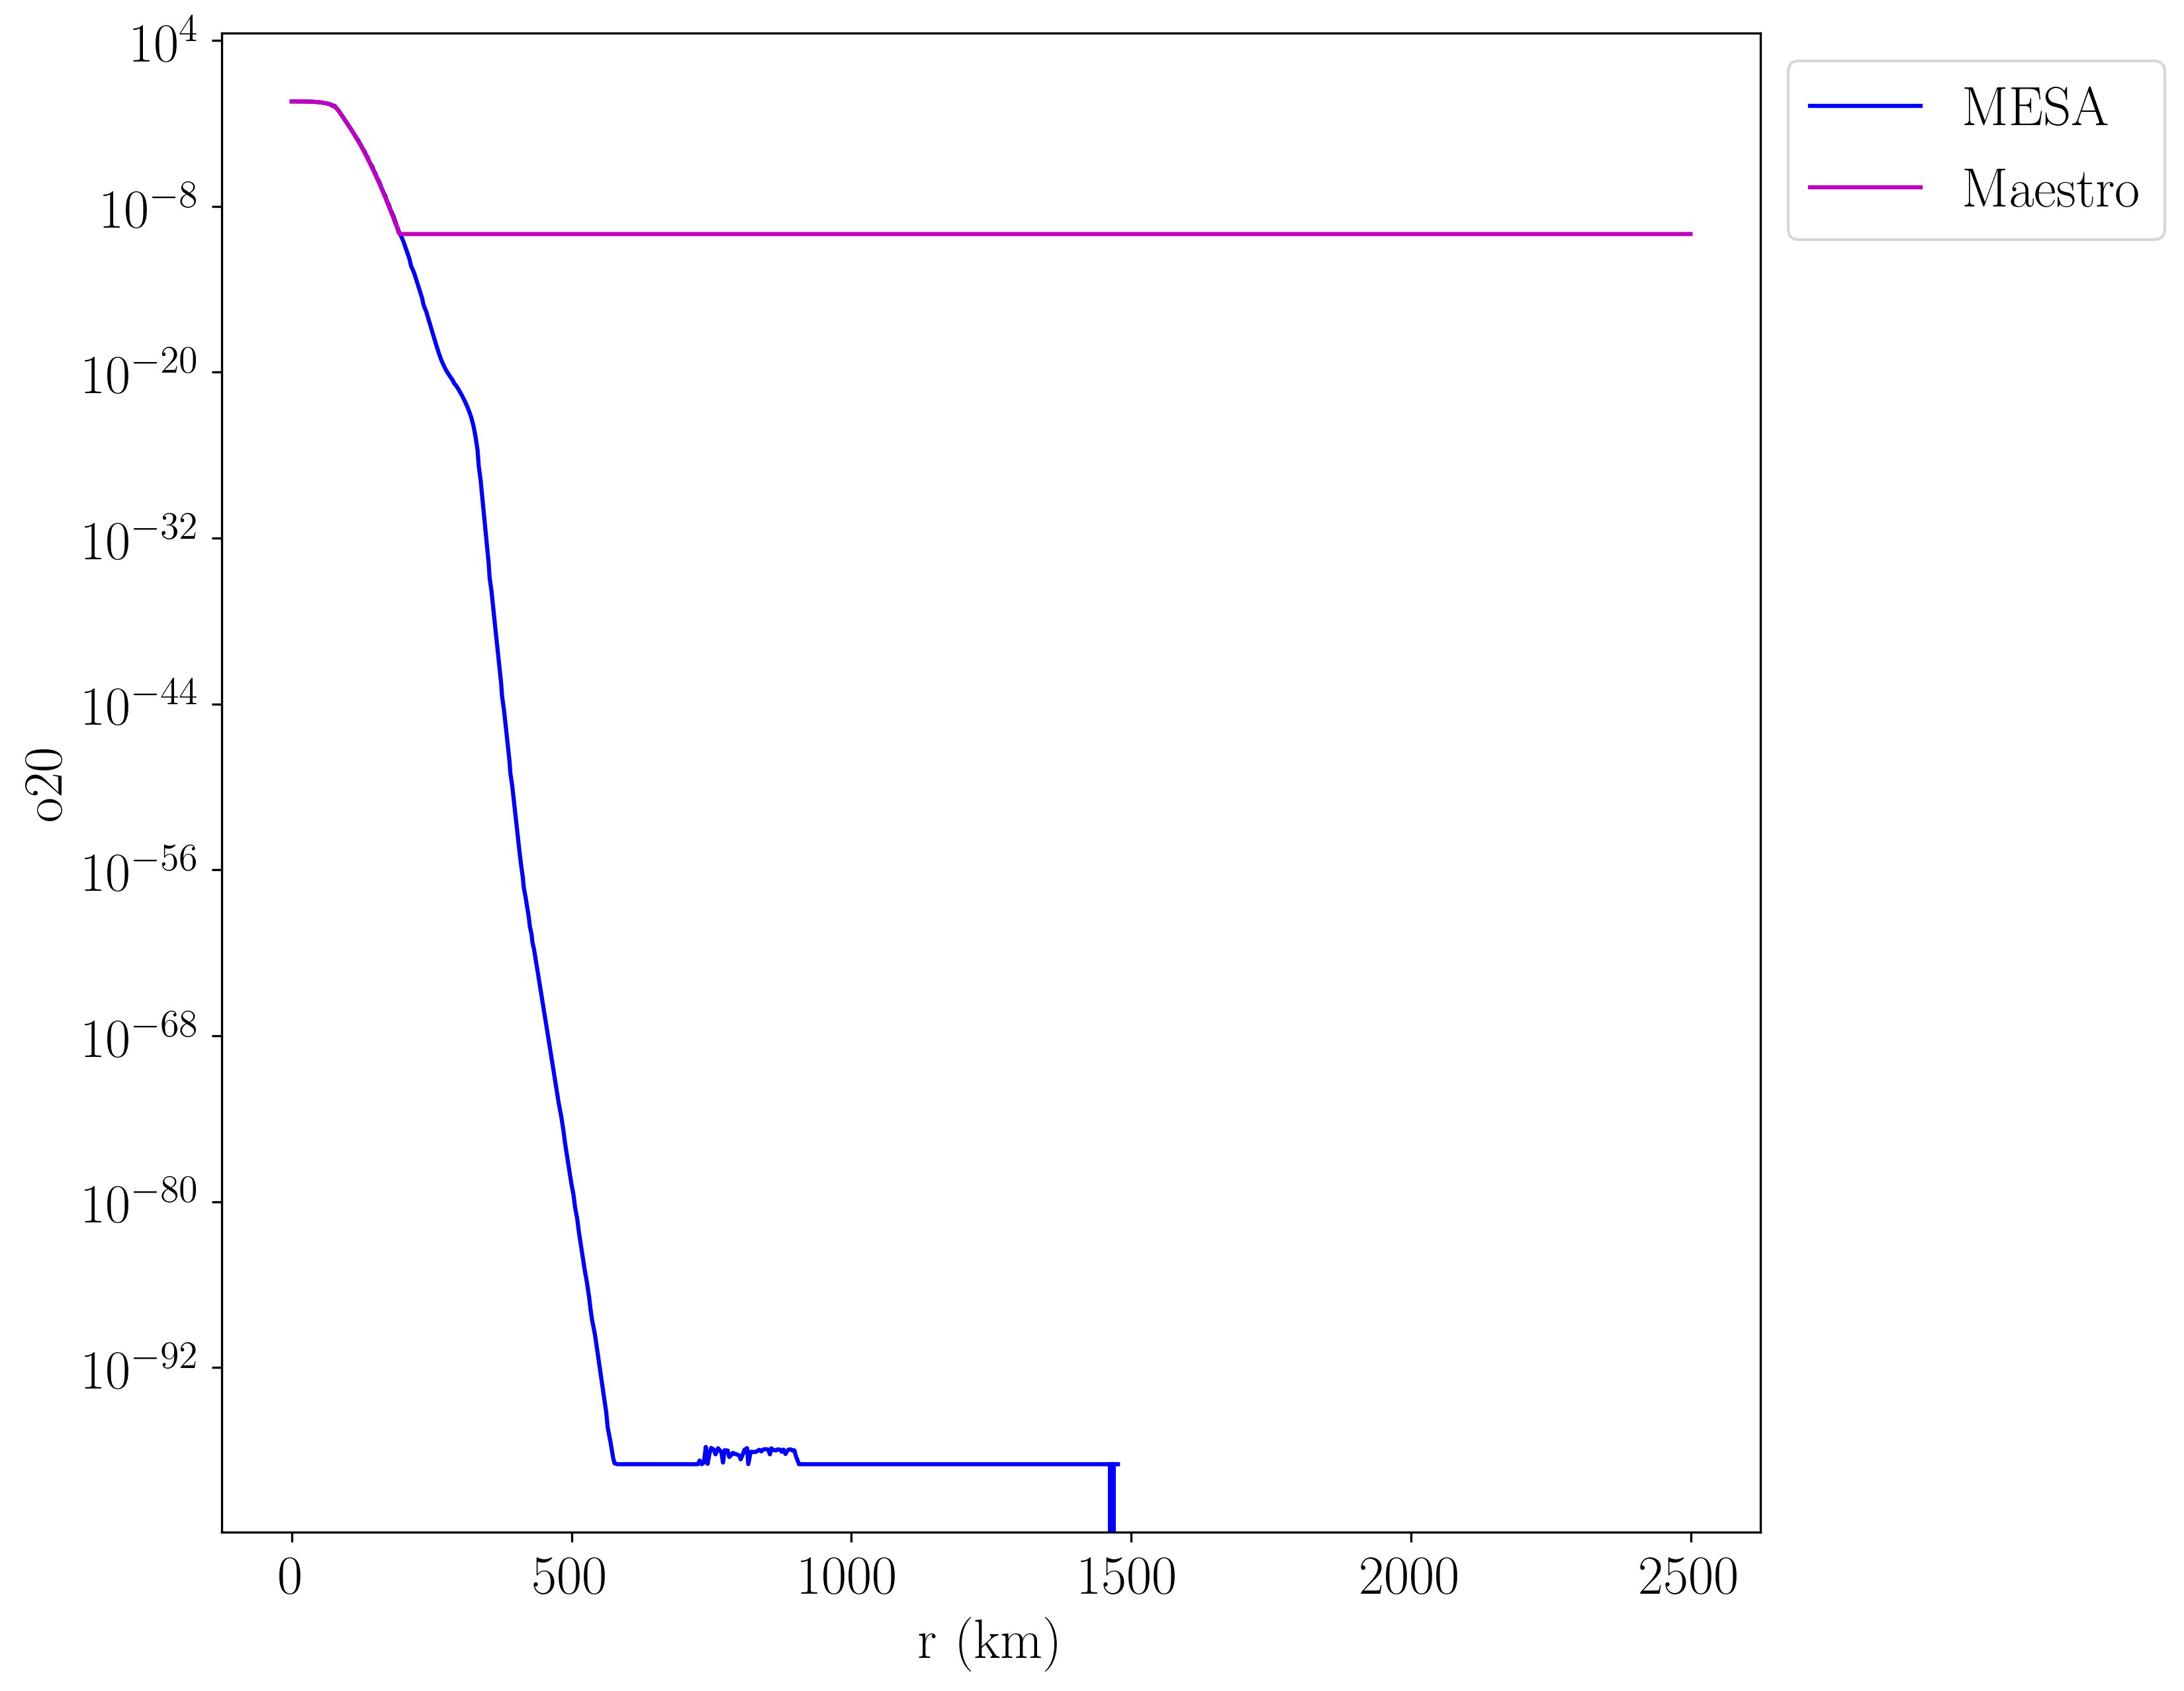

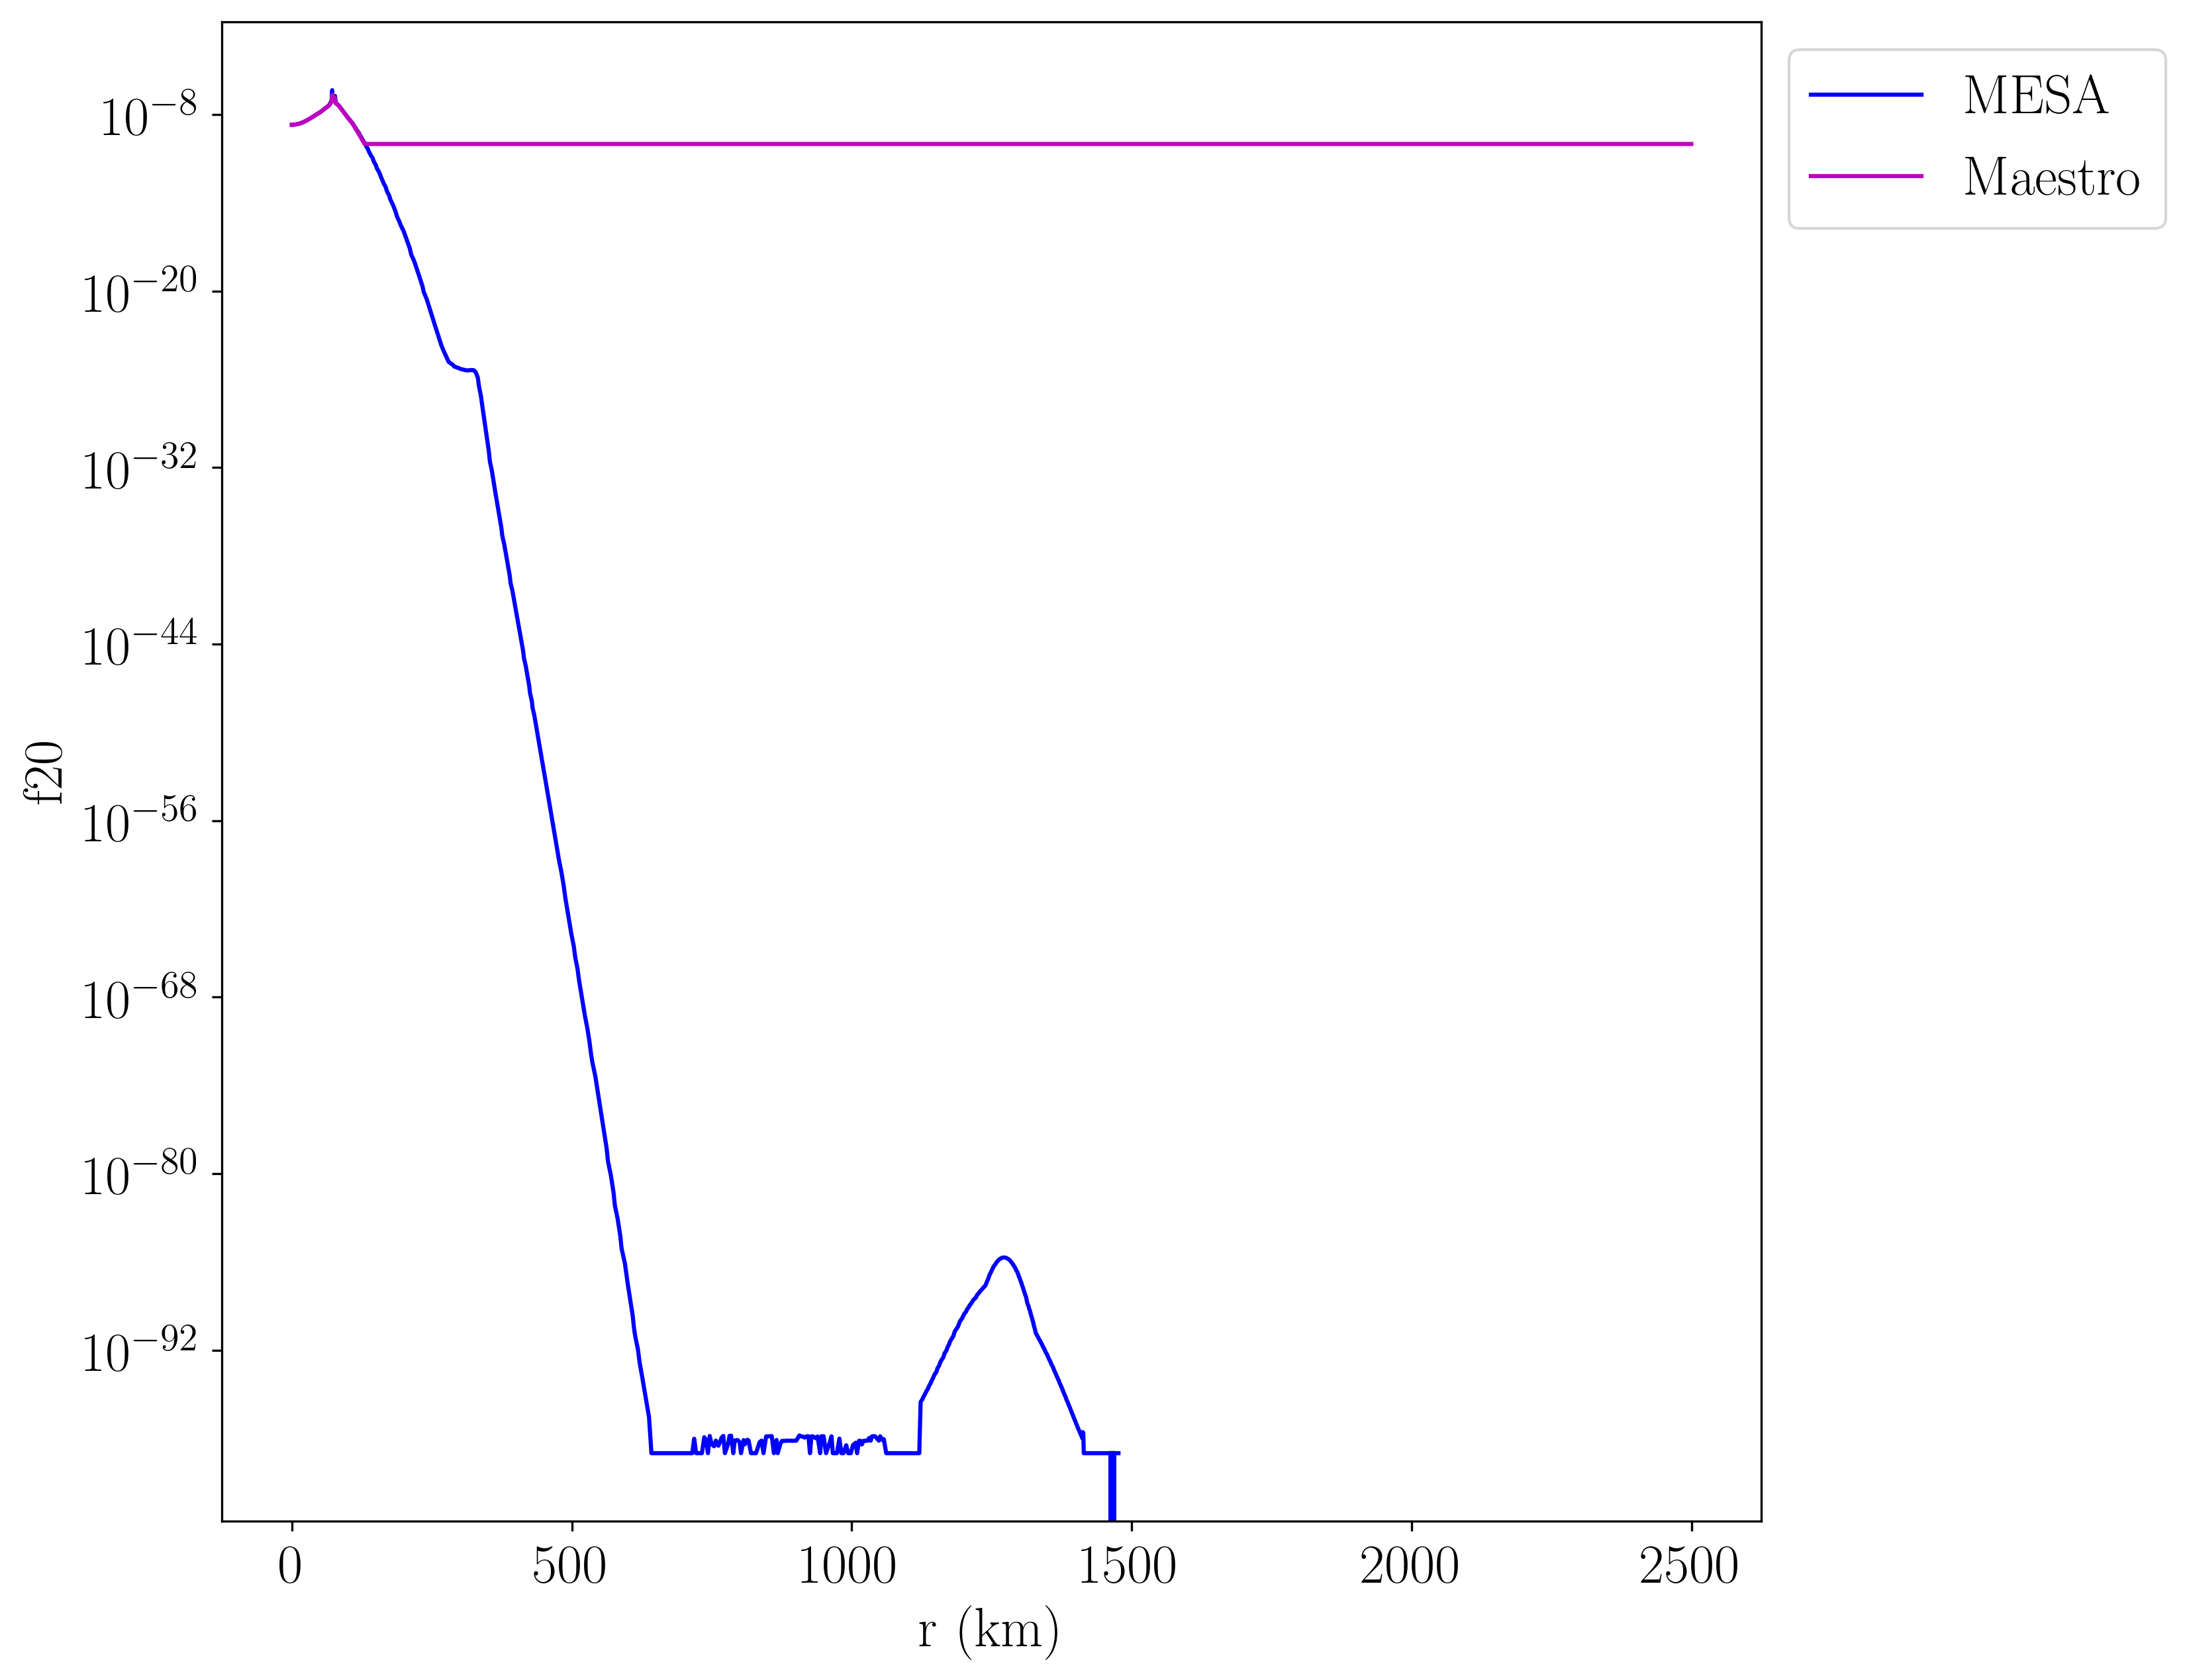

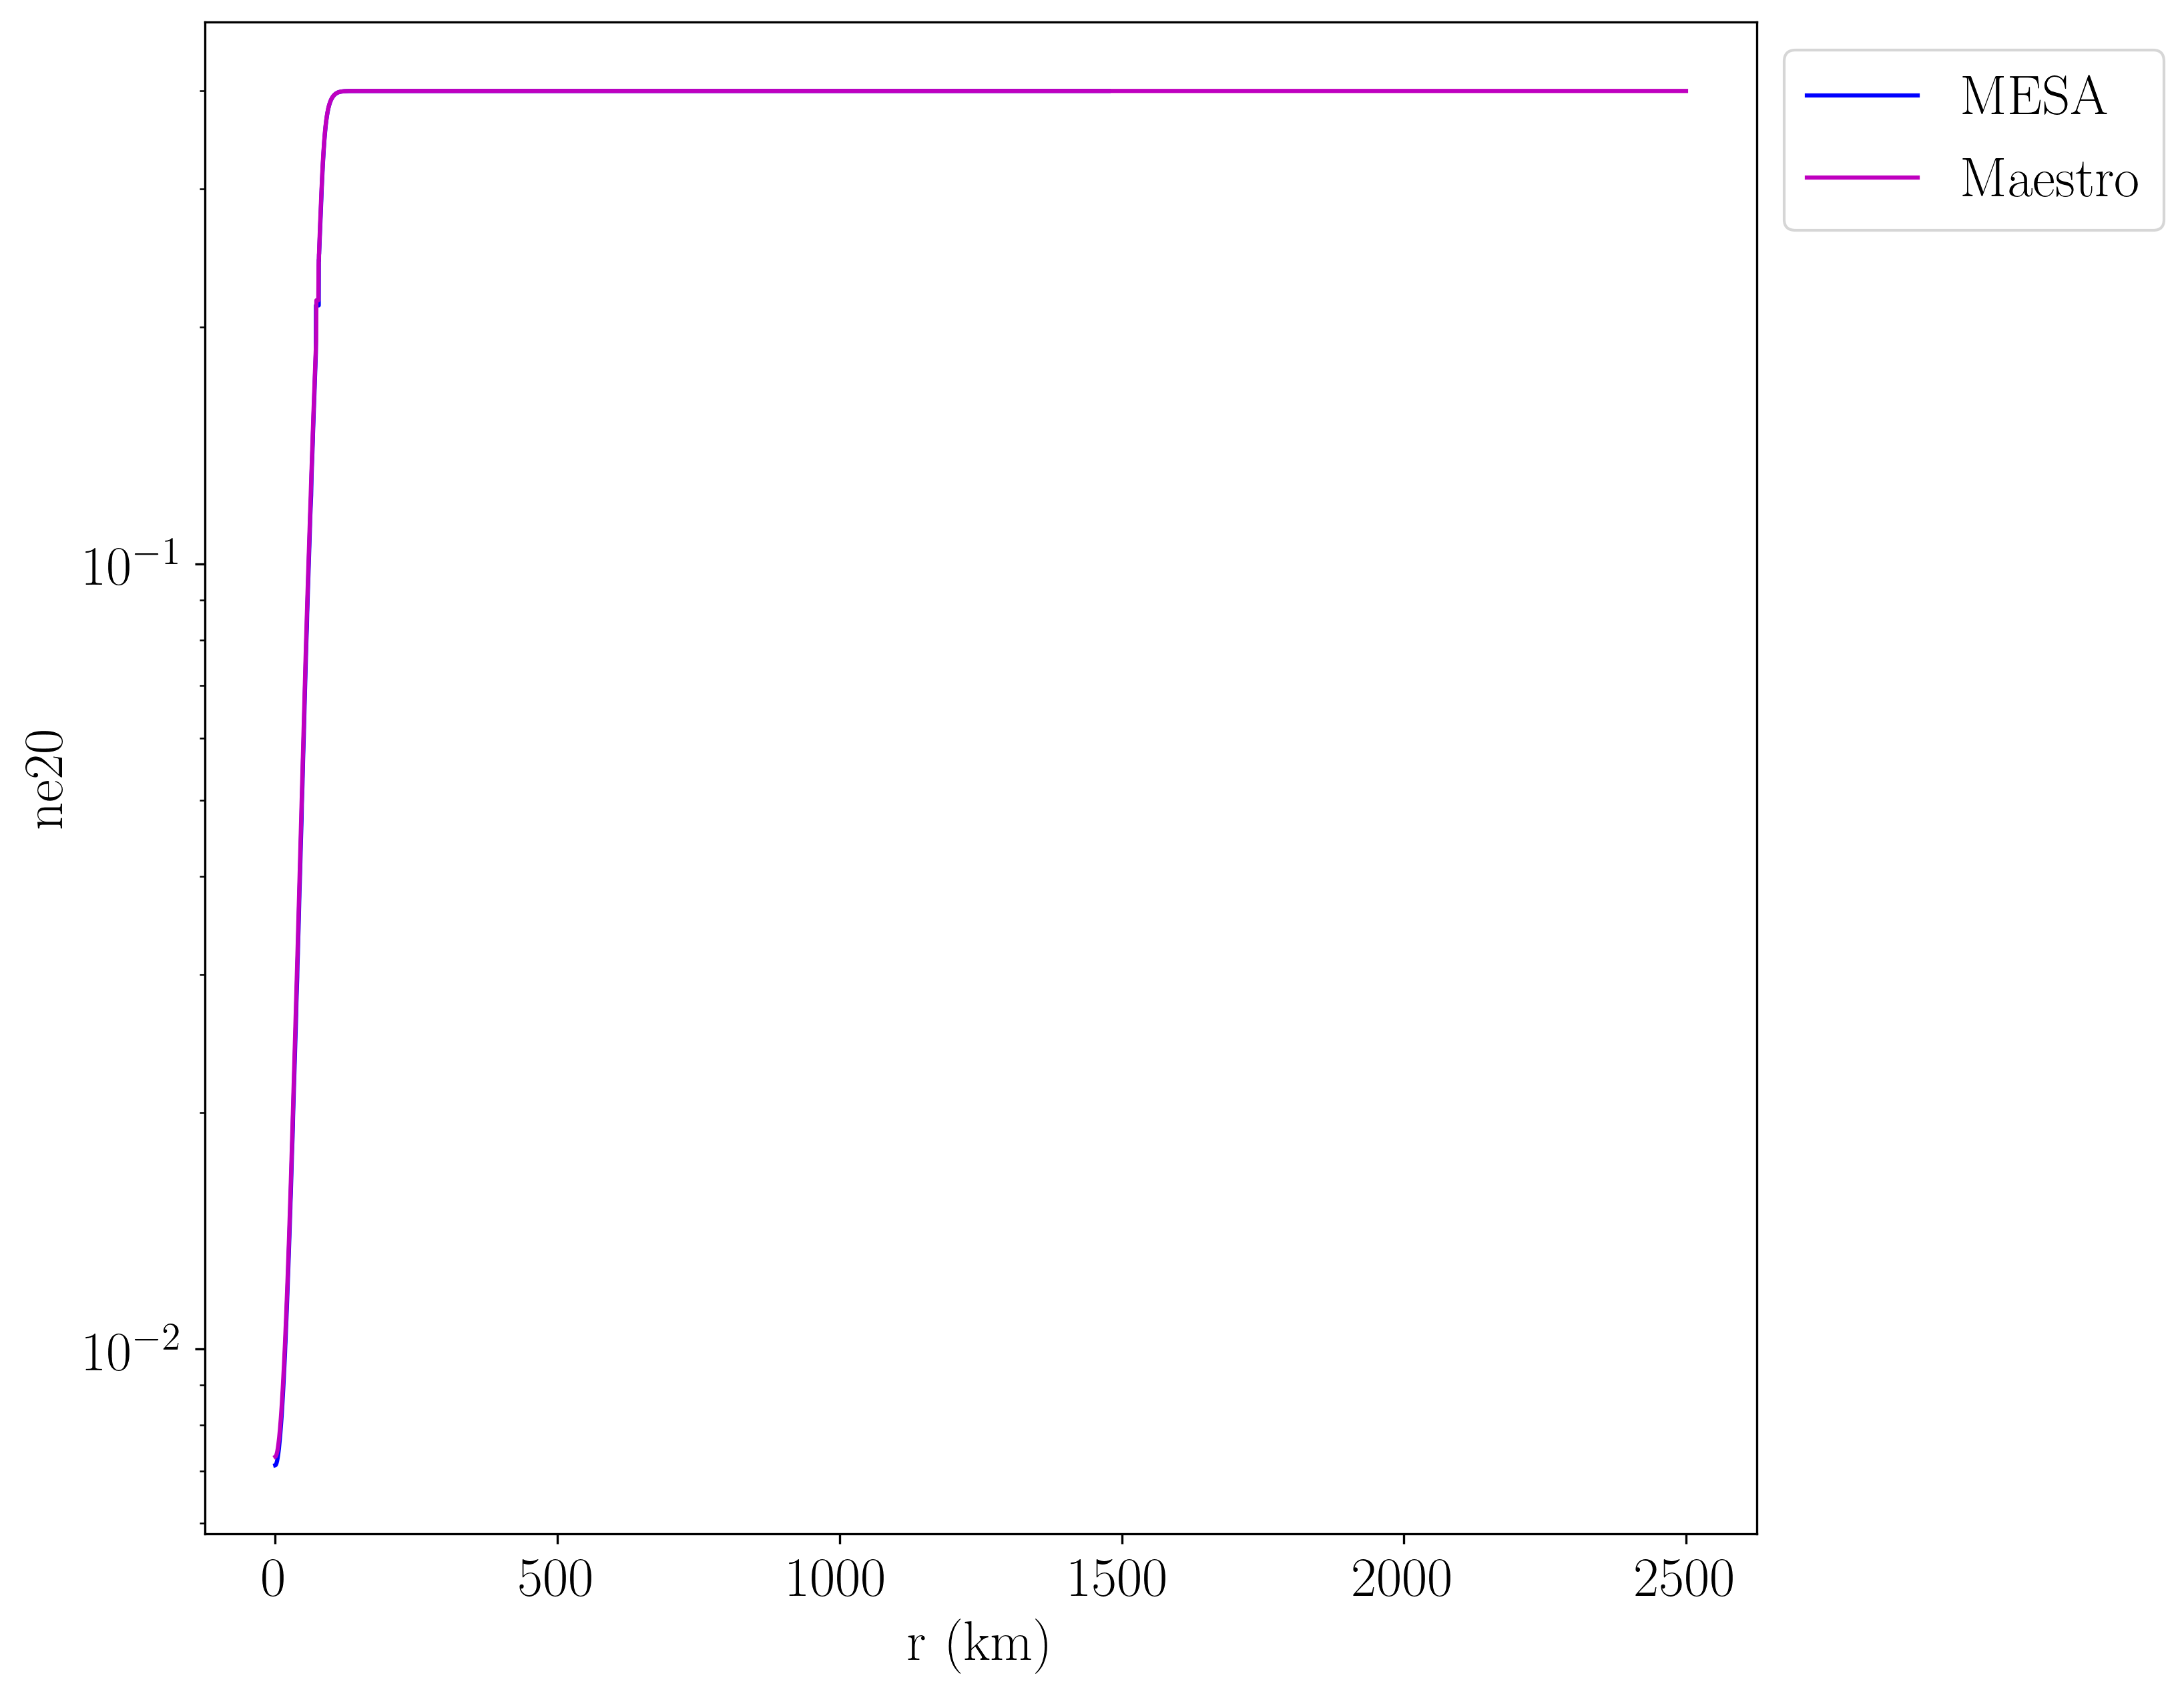

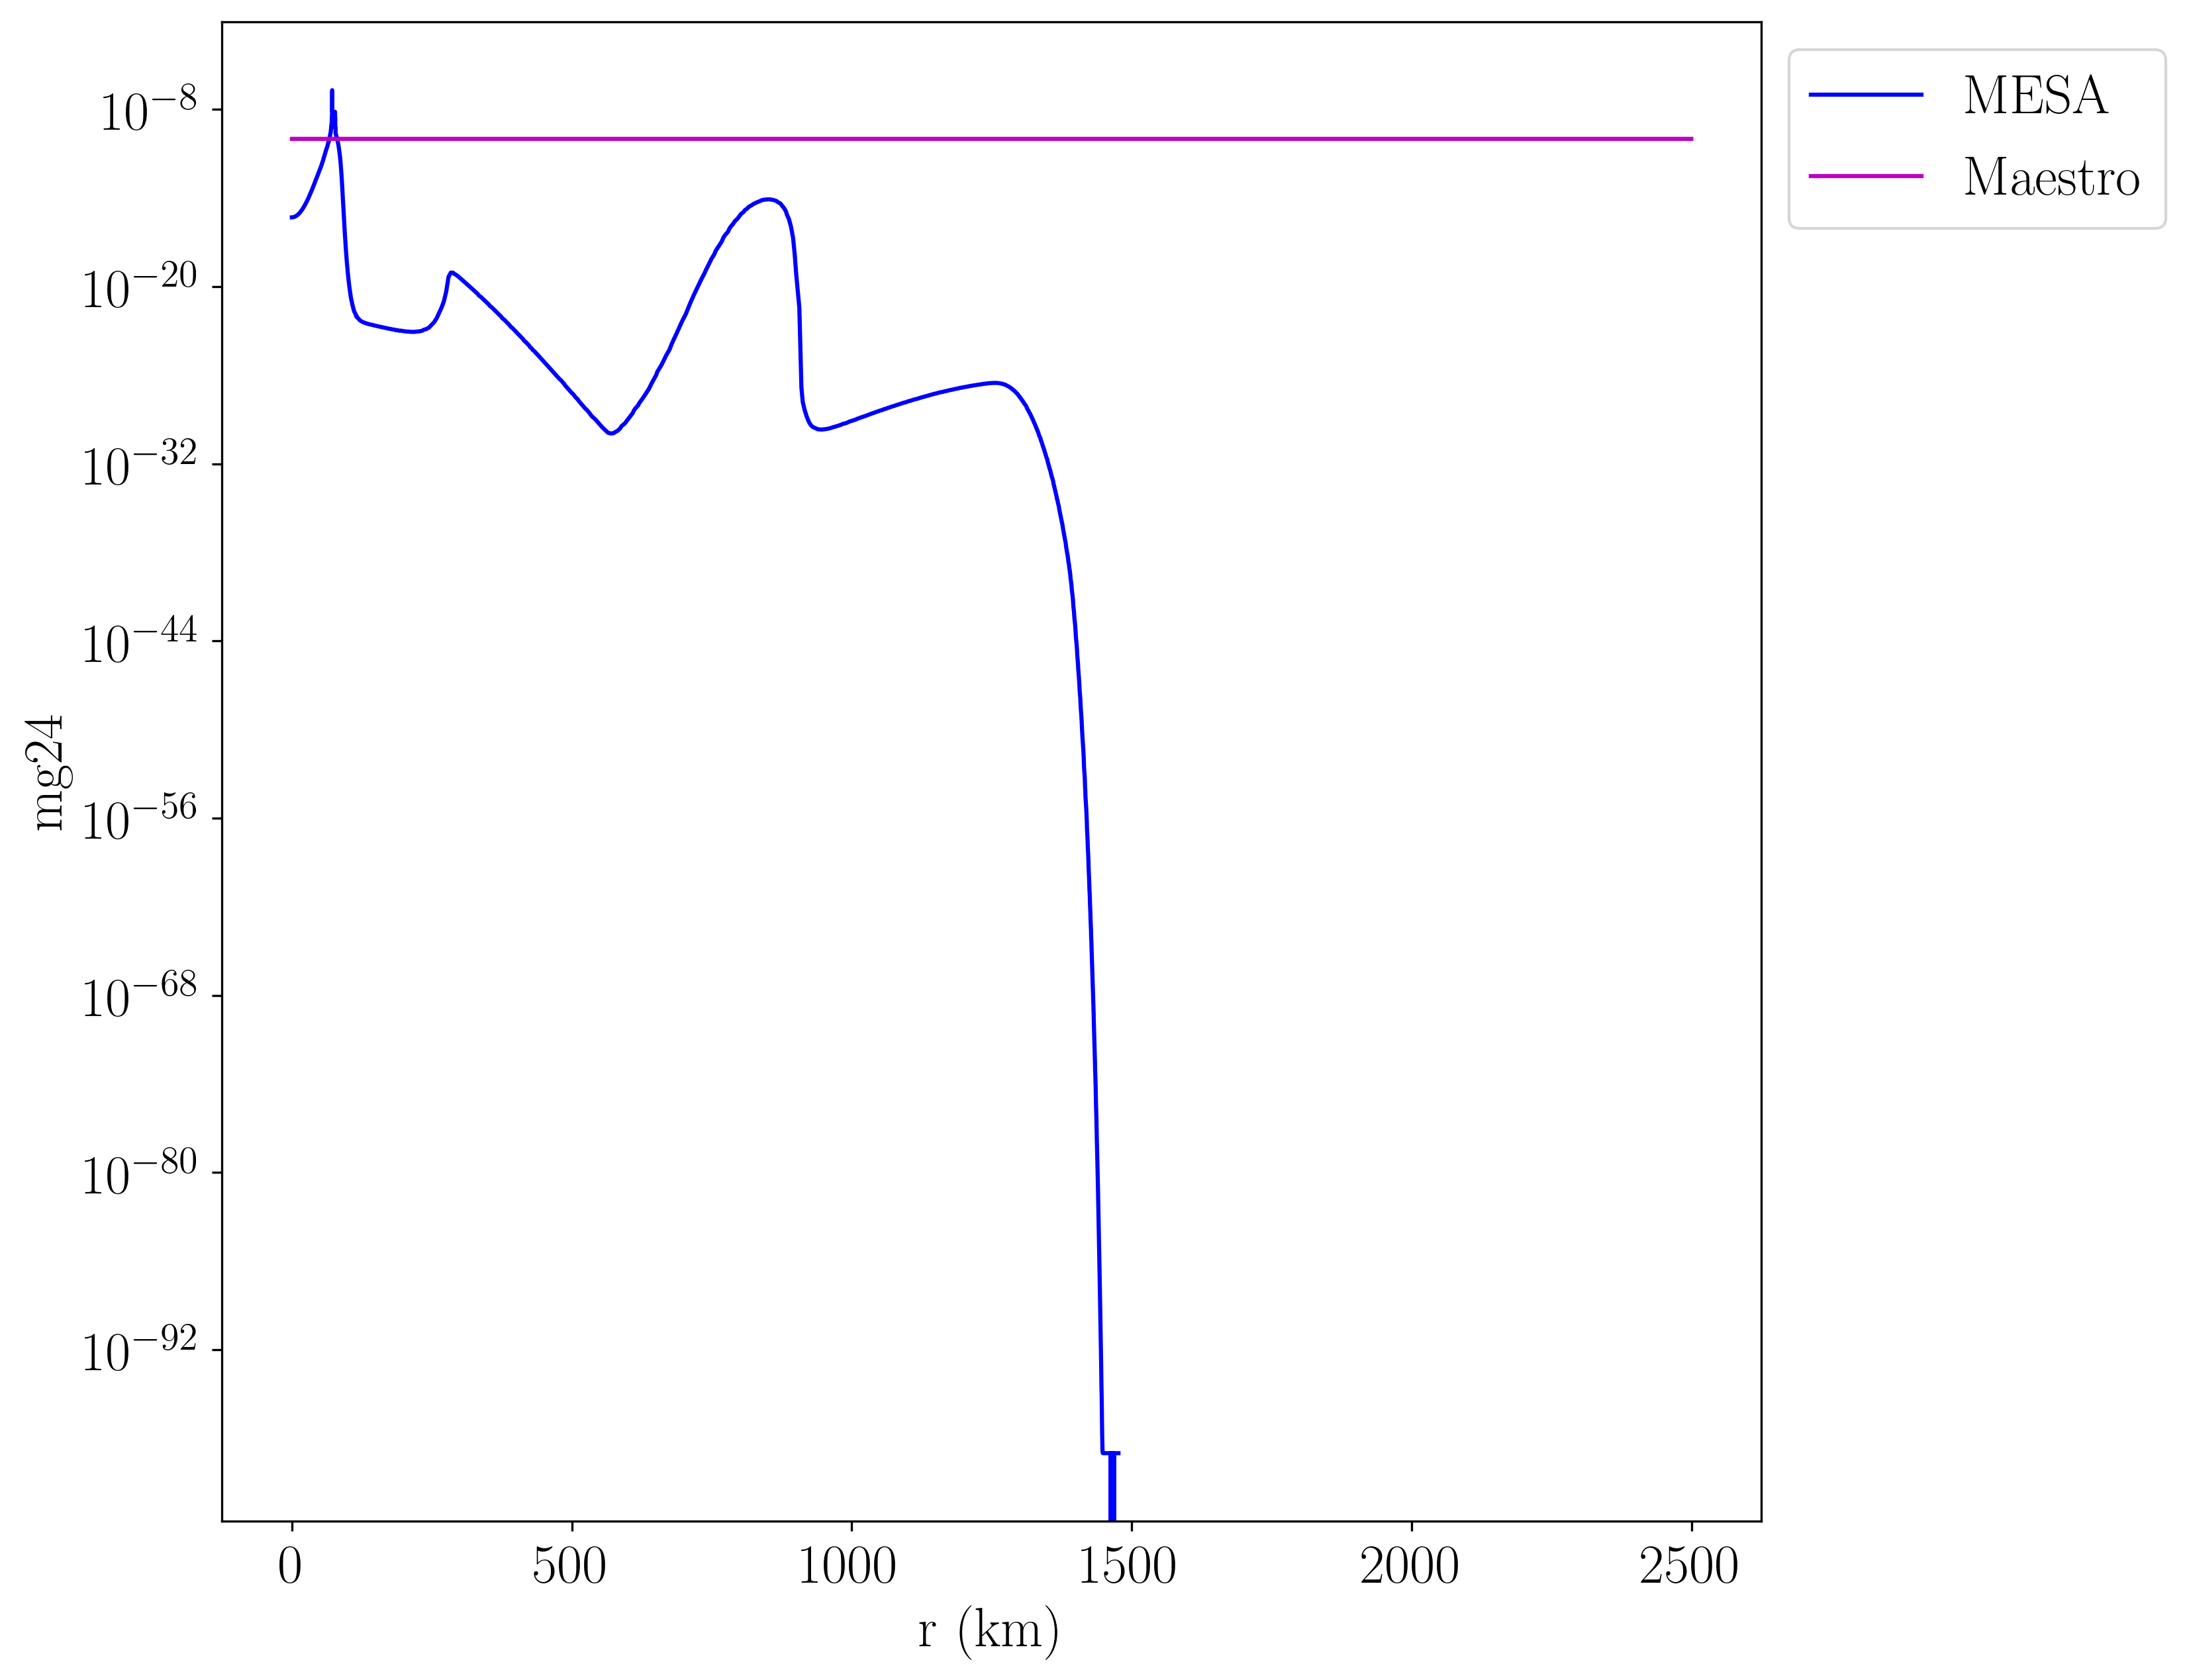

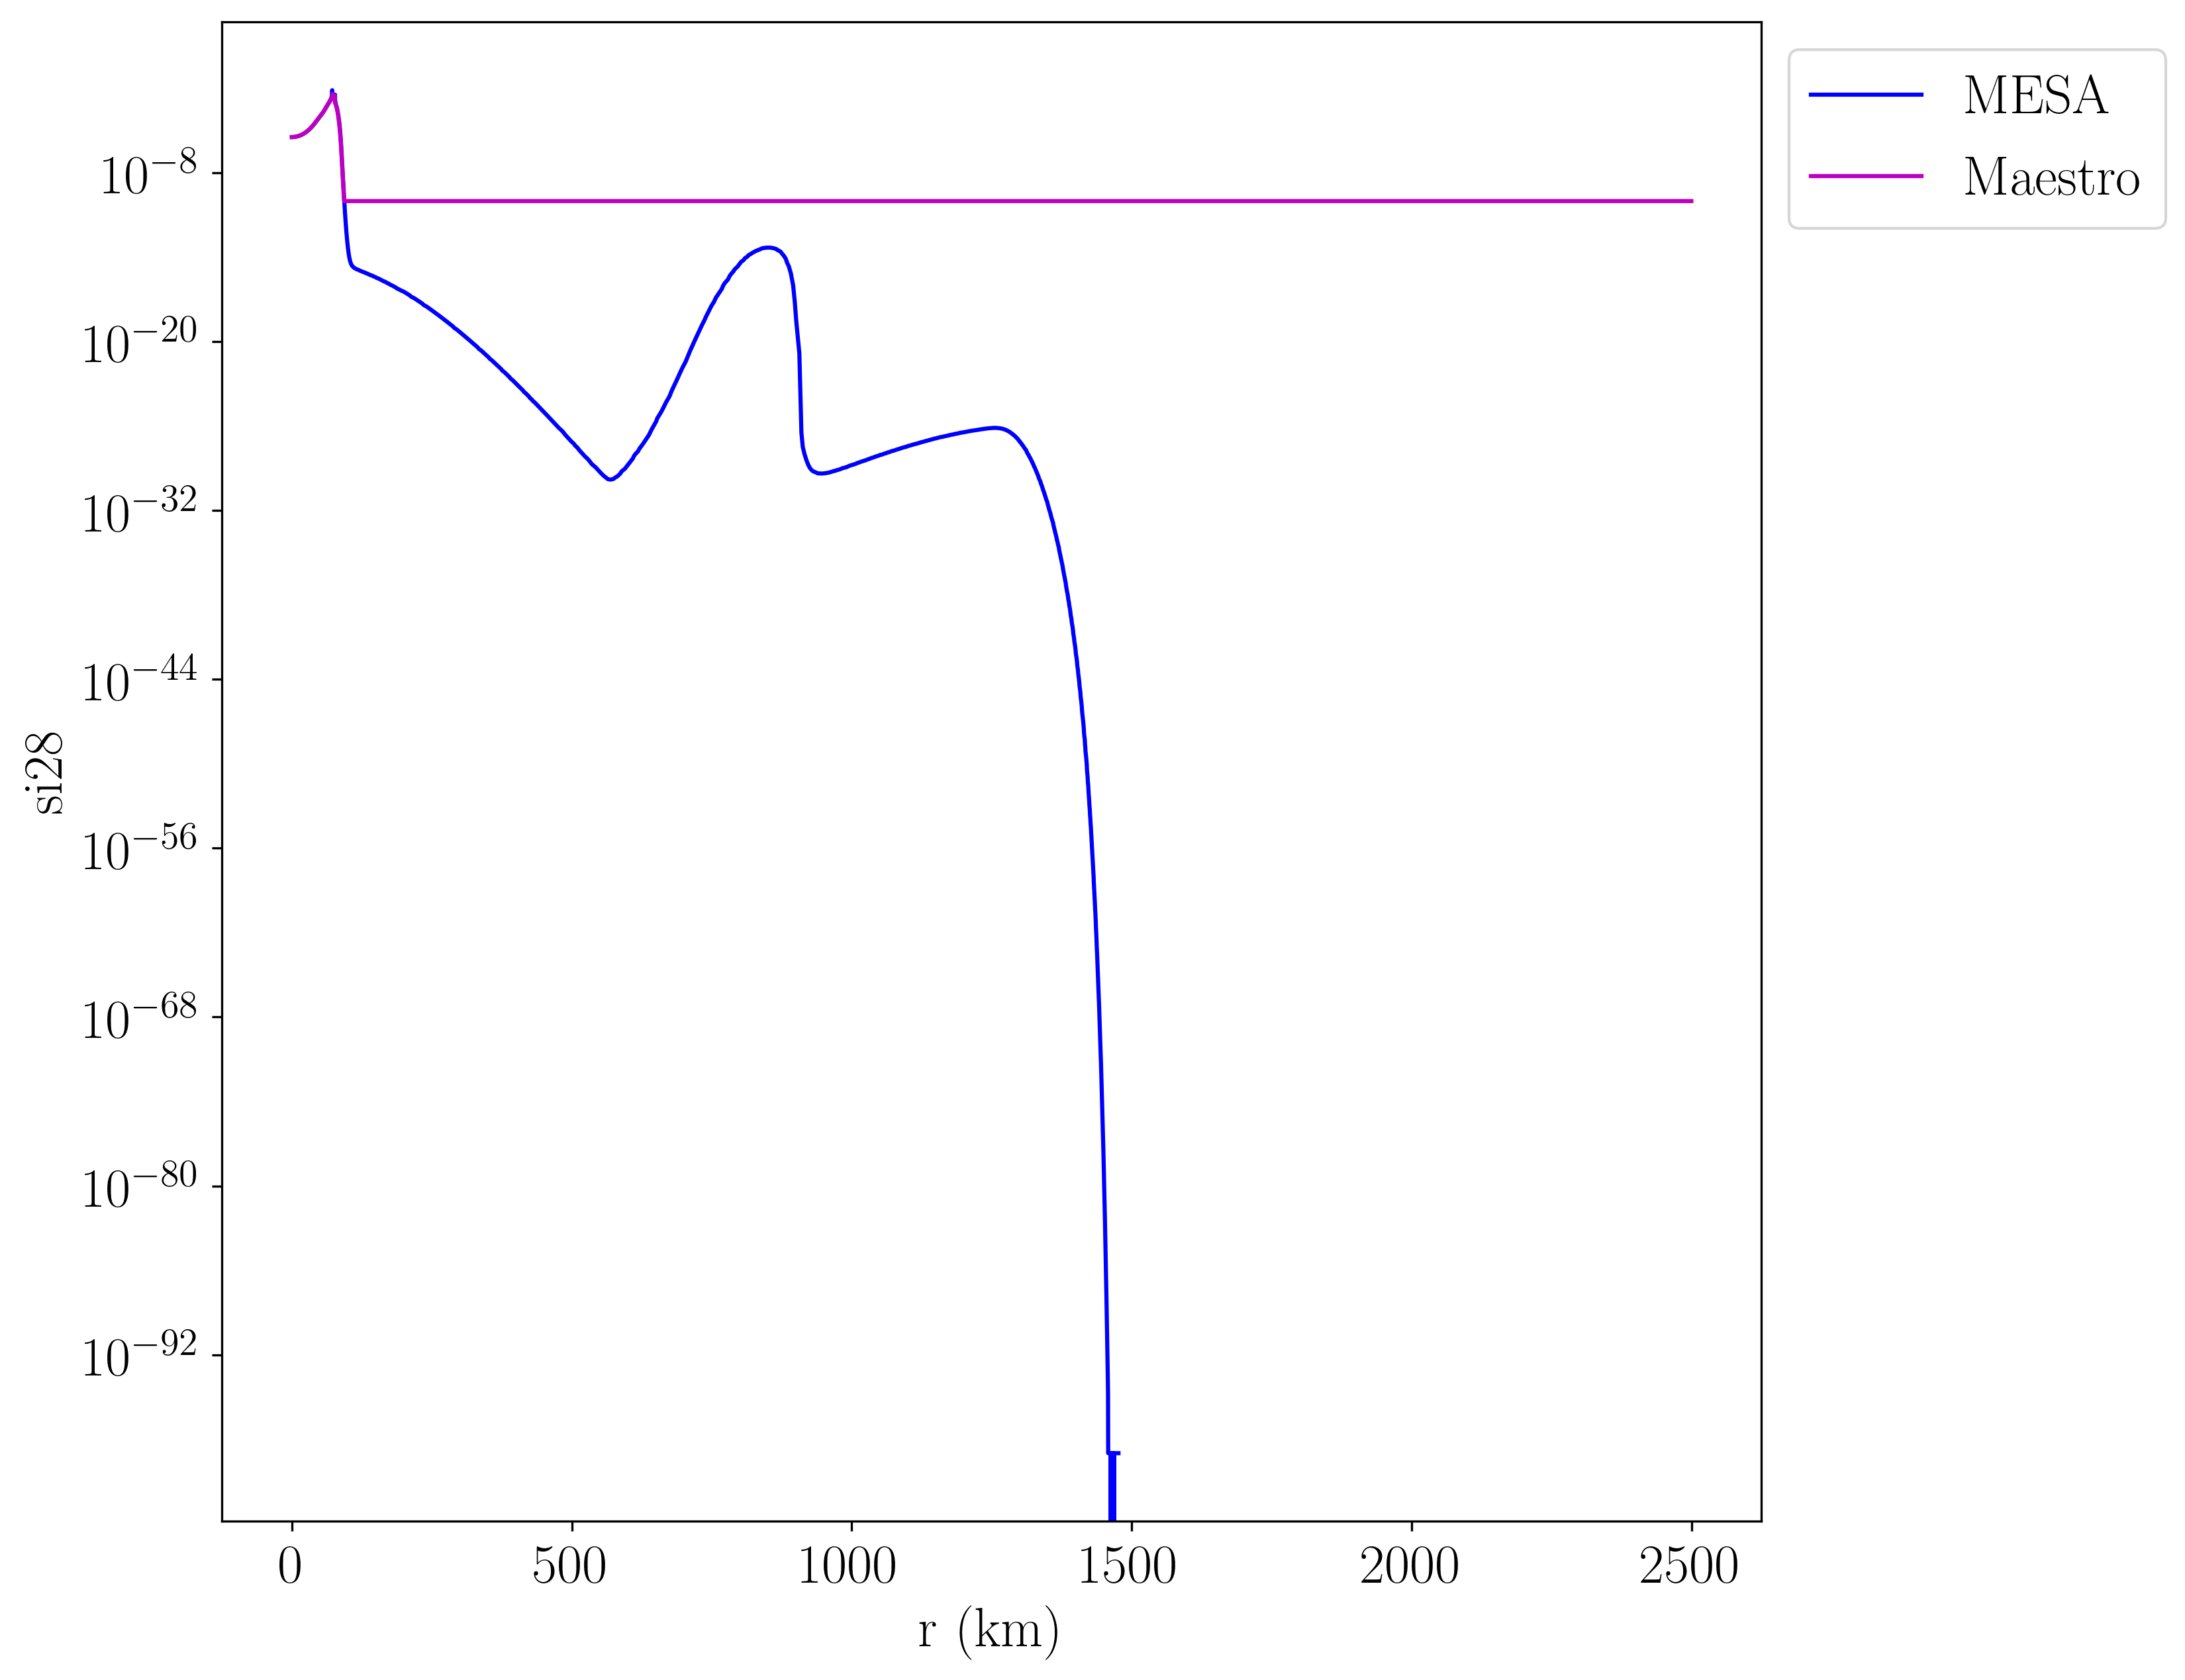

In [19]:
for s in shared_species:
    plot_field(field=s, logy=True)

### Zoom in on temperature peak - mass fractions for species shared between MESA and Maestro

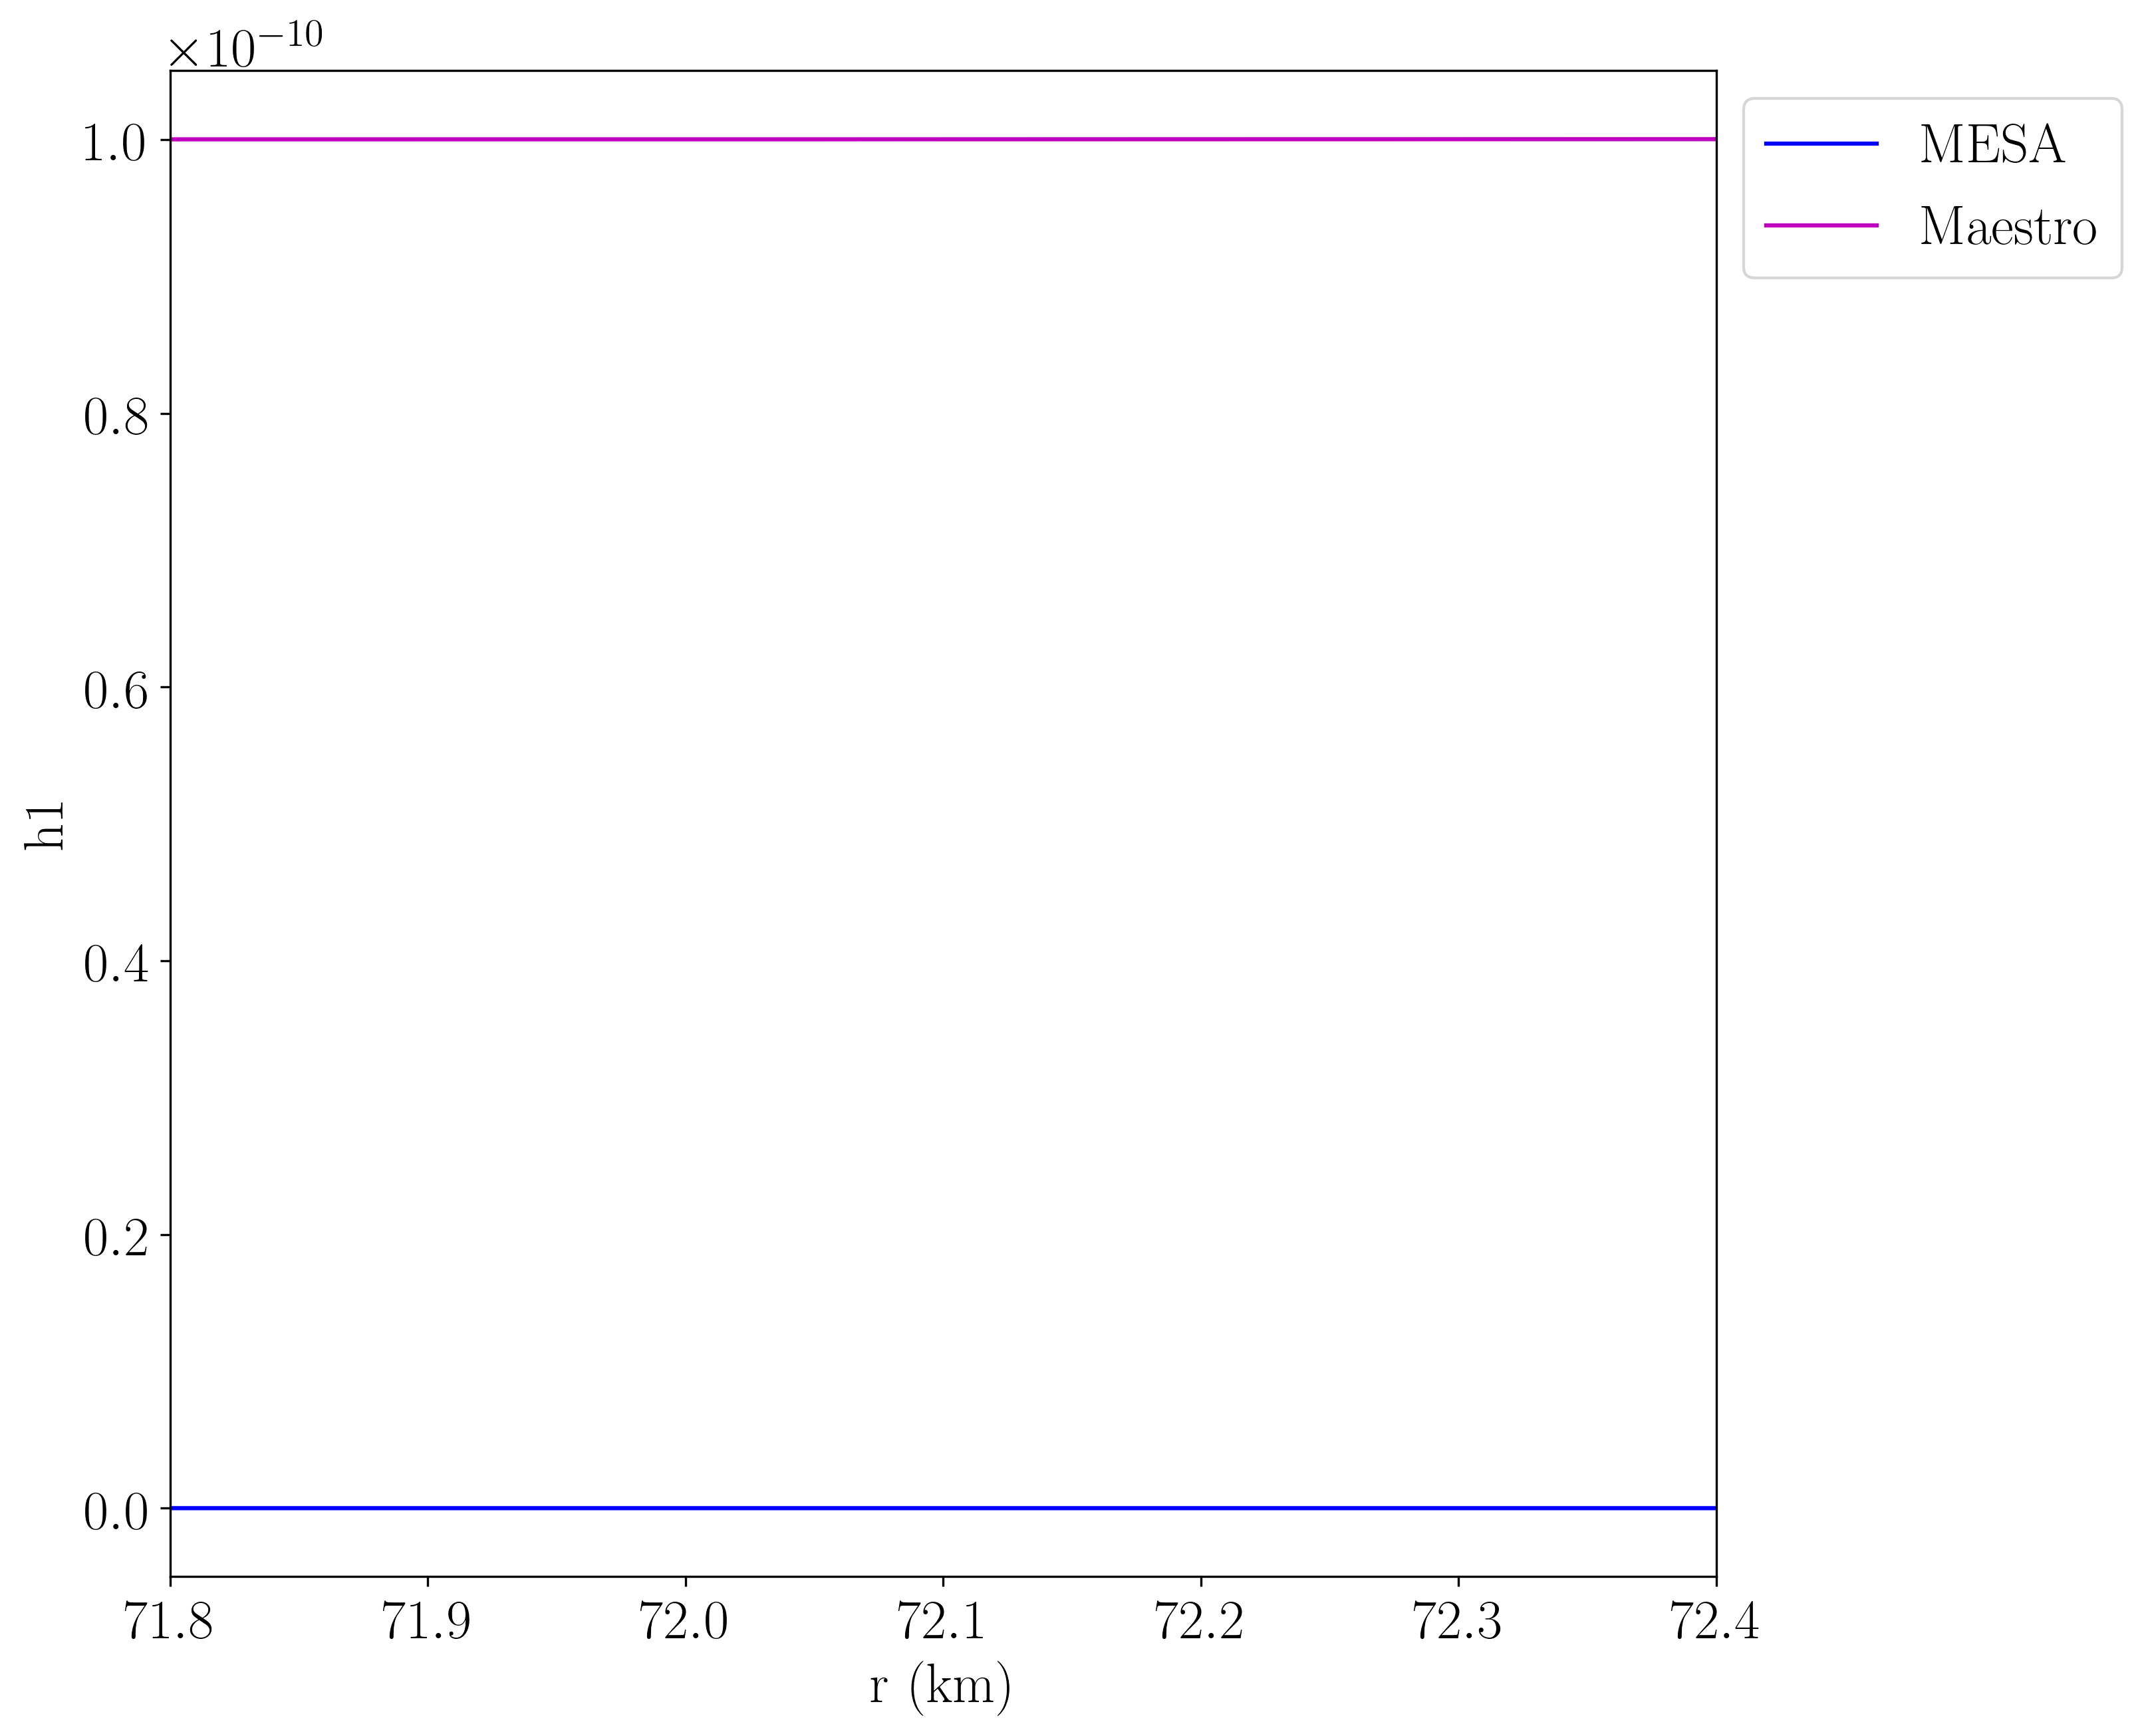

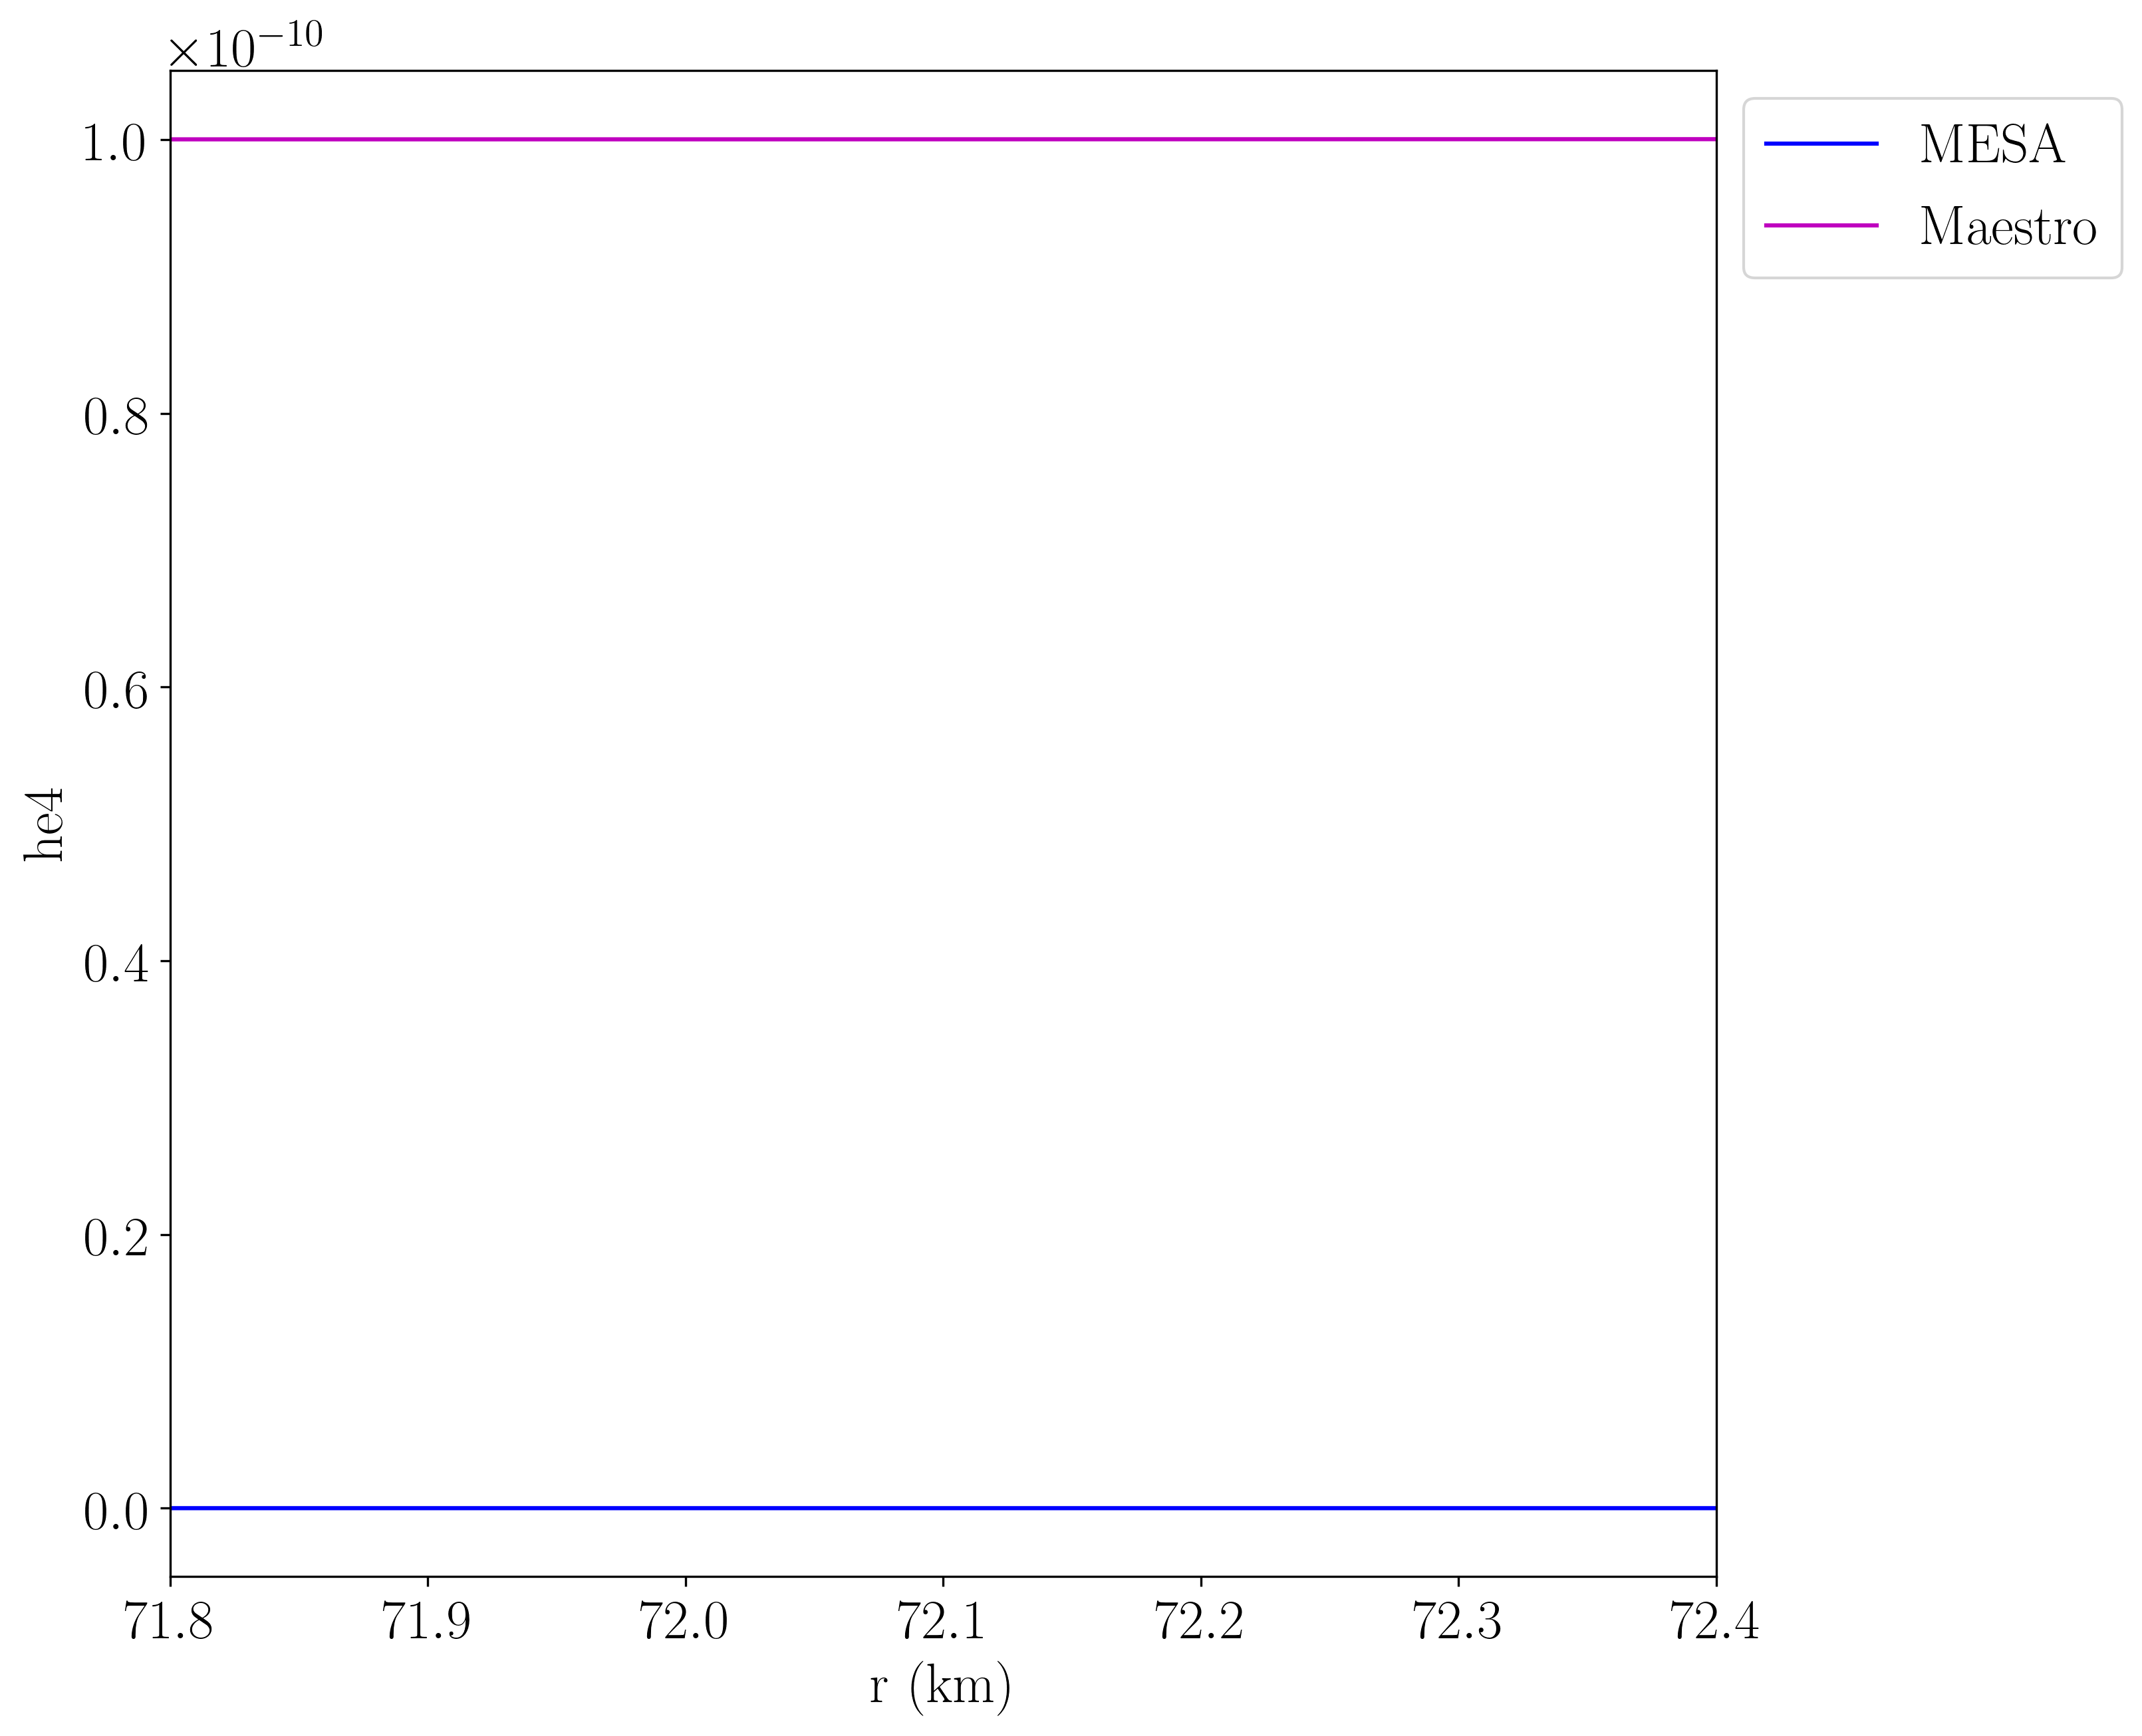

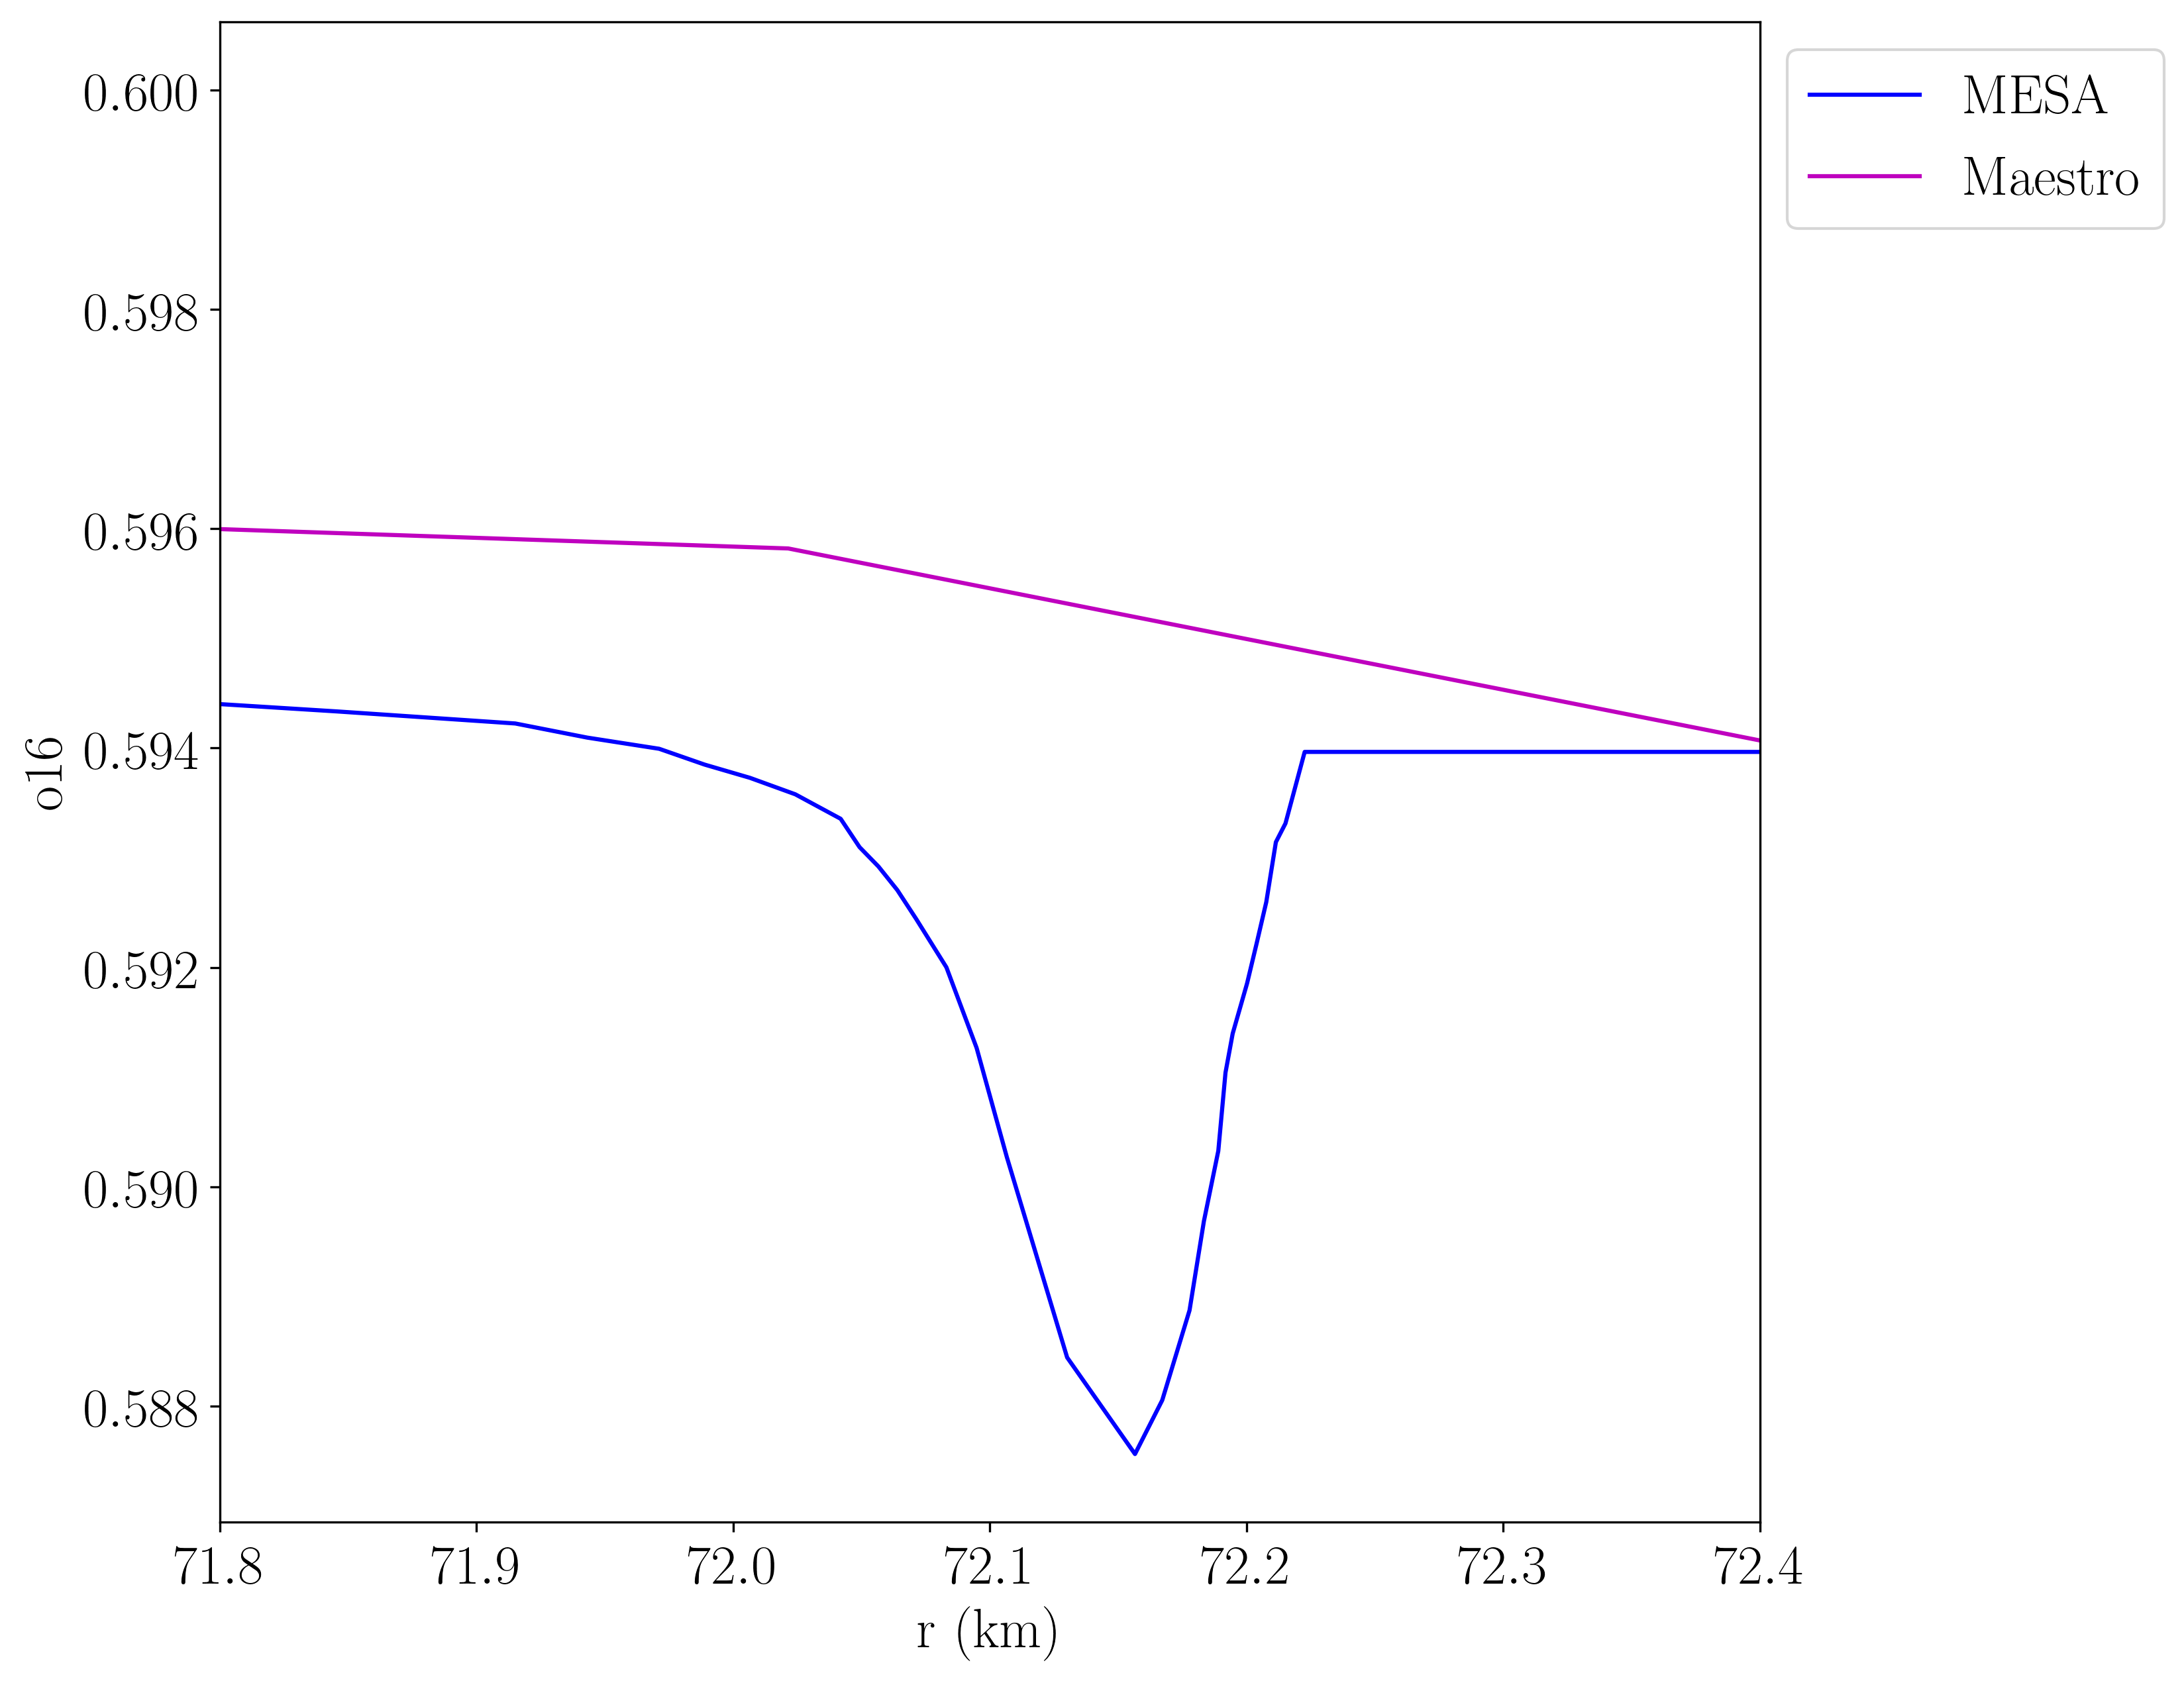

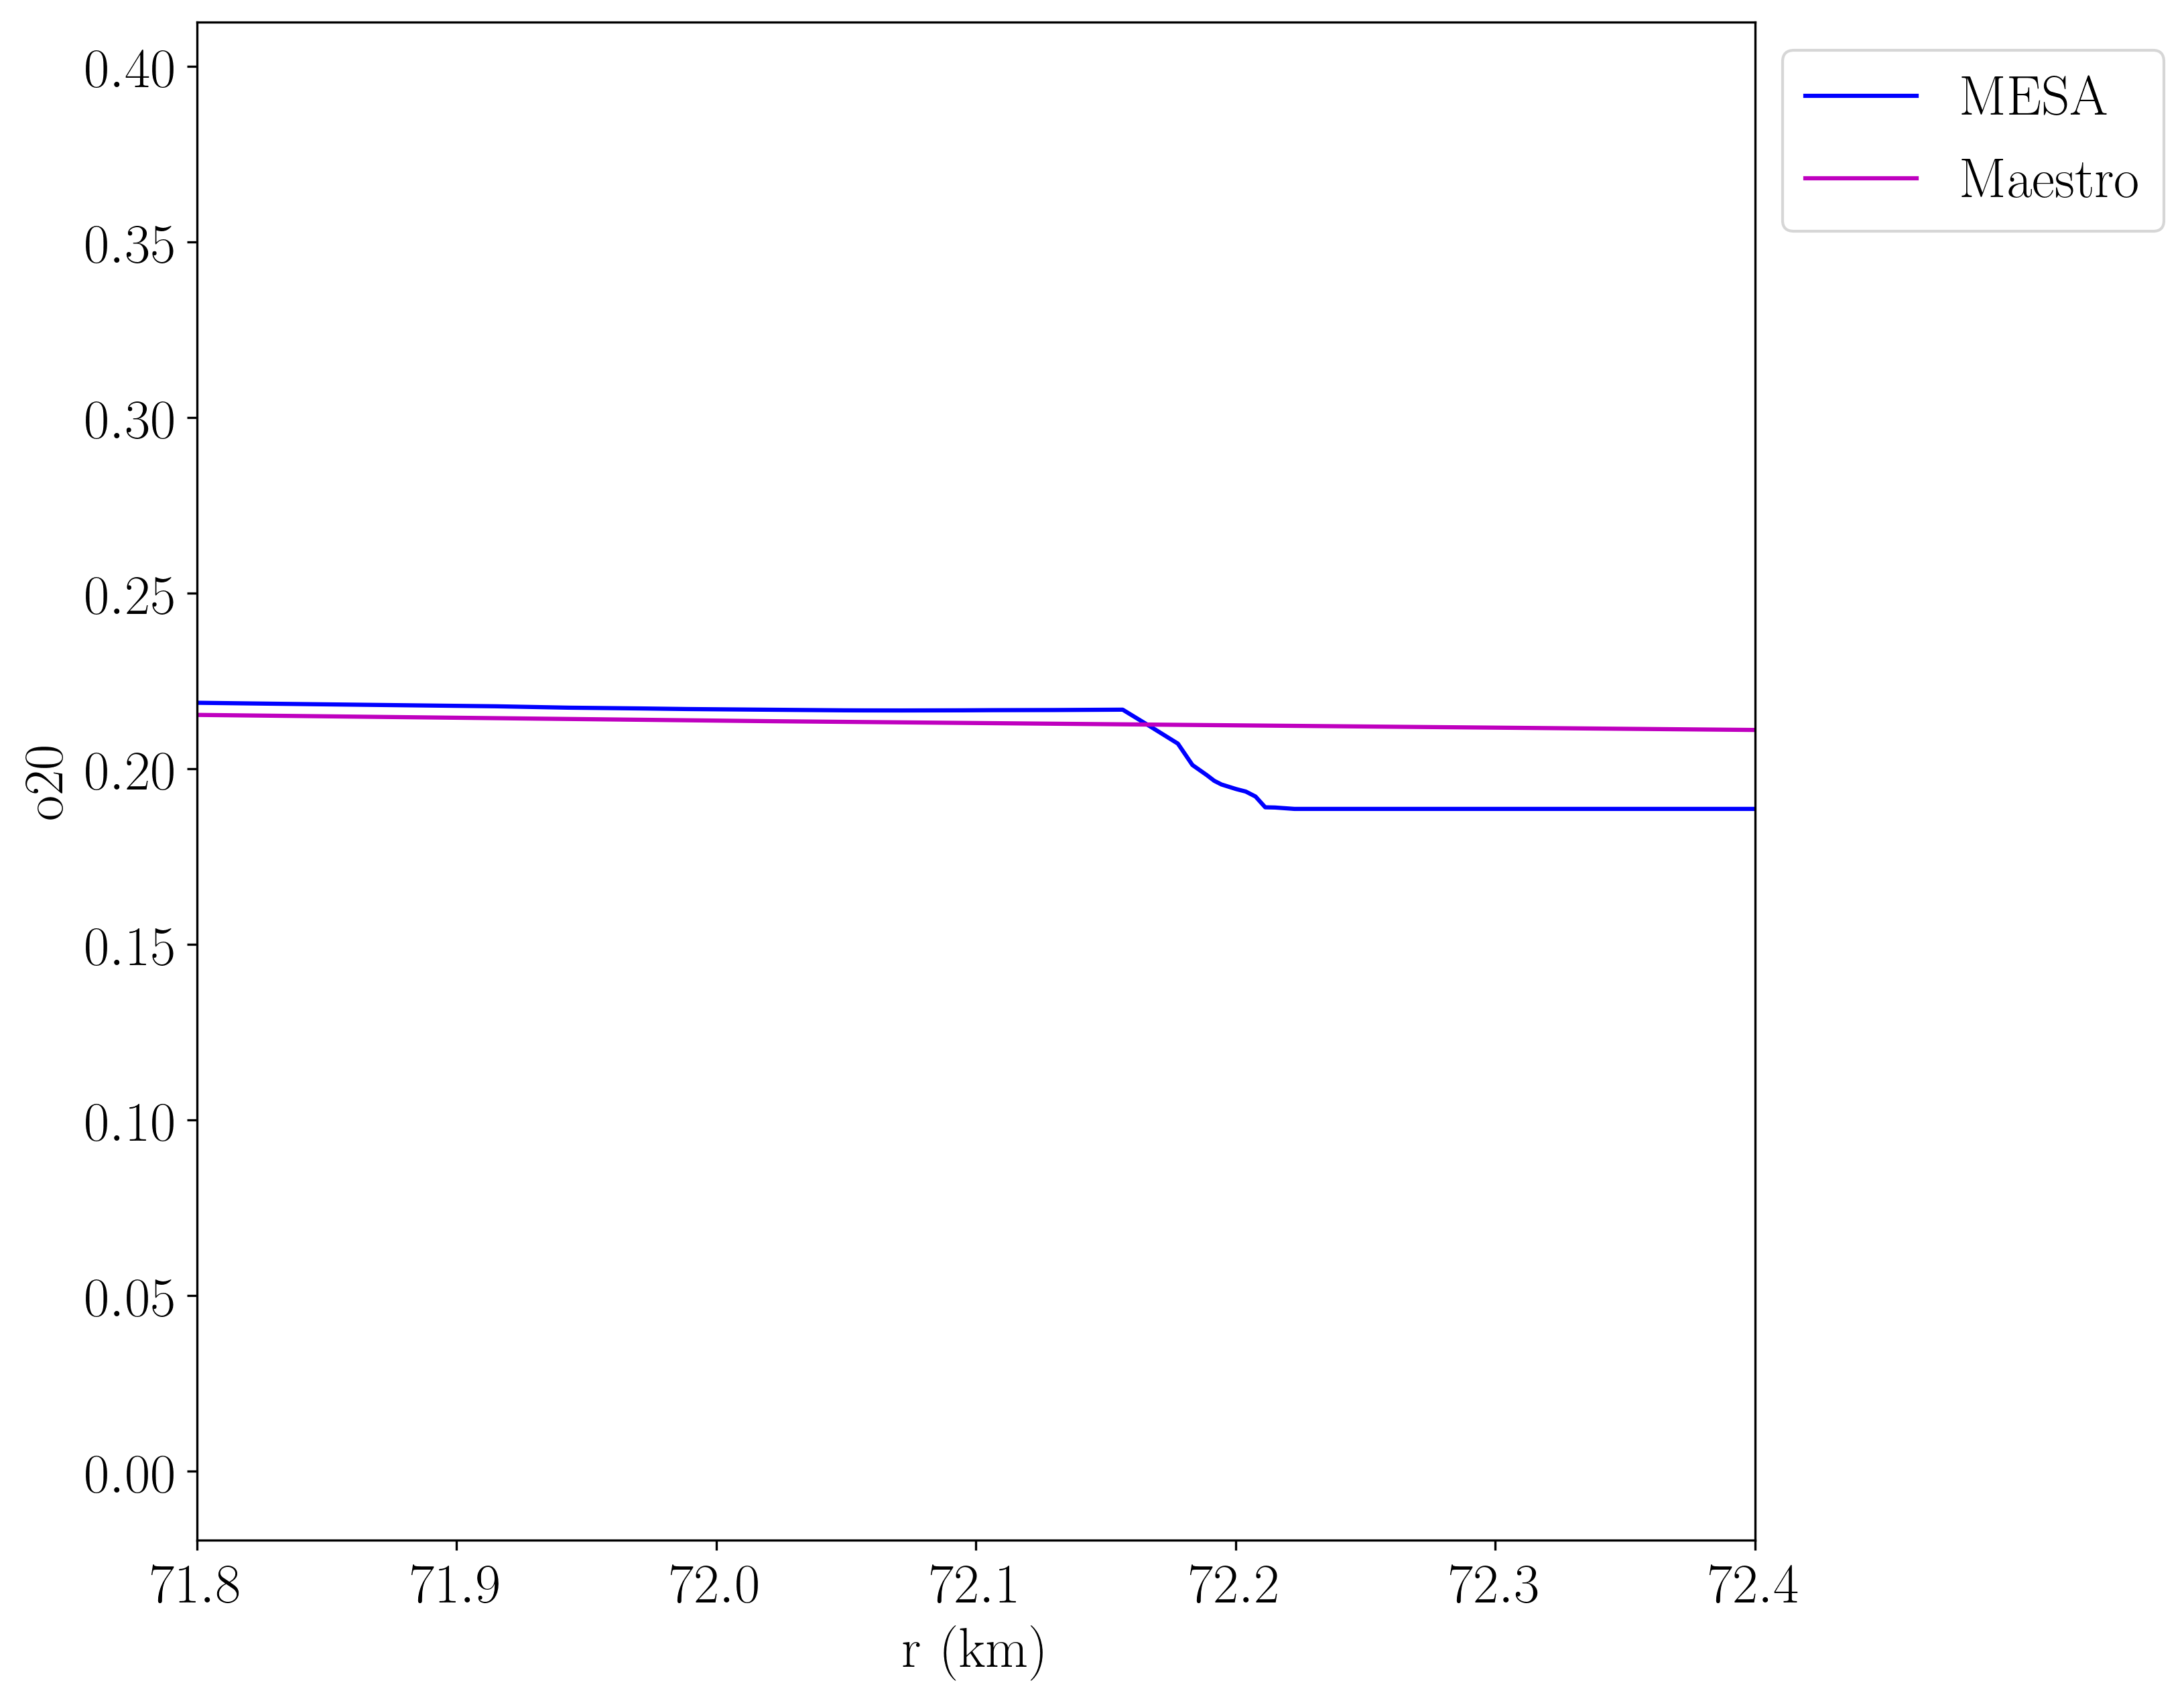

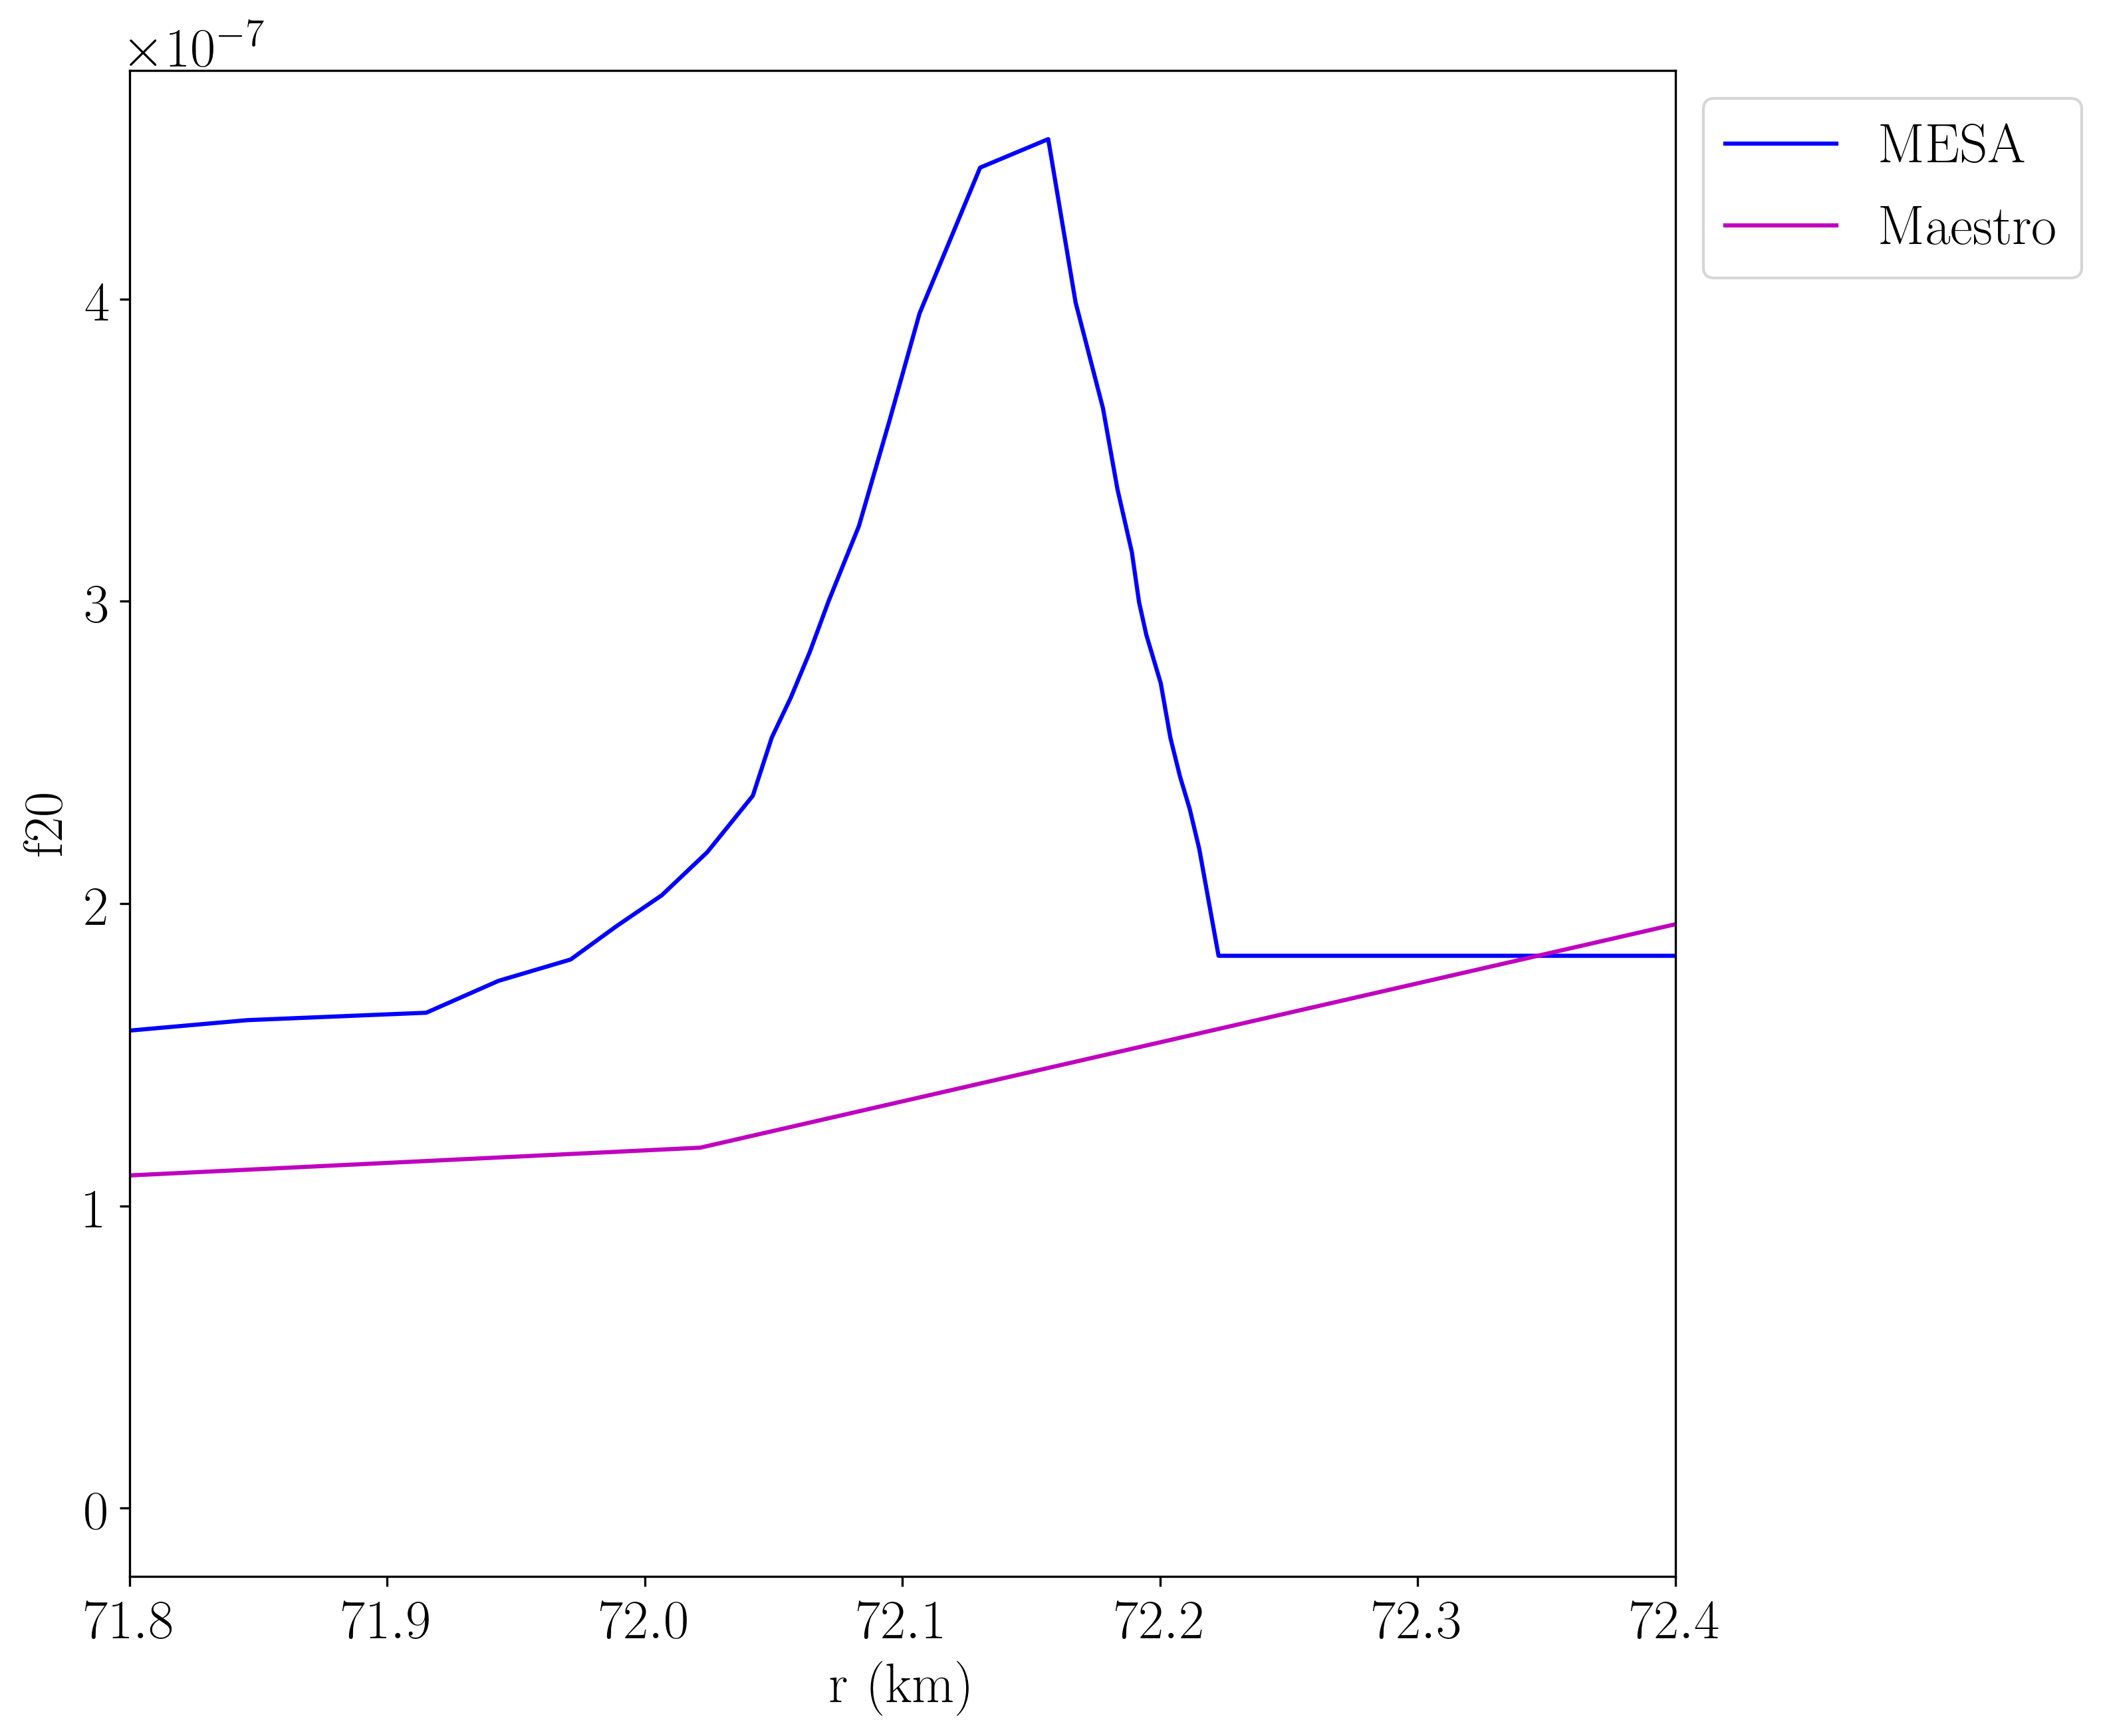

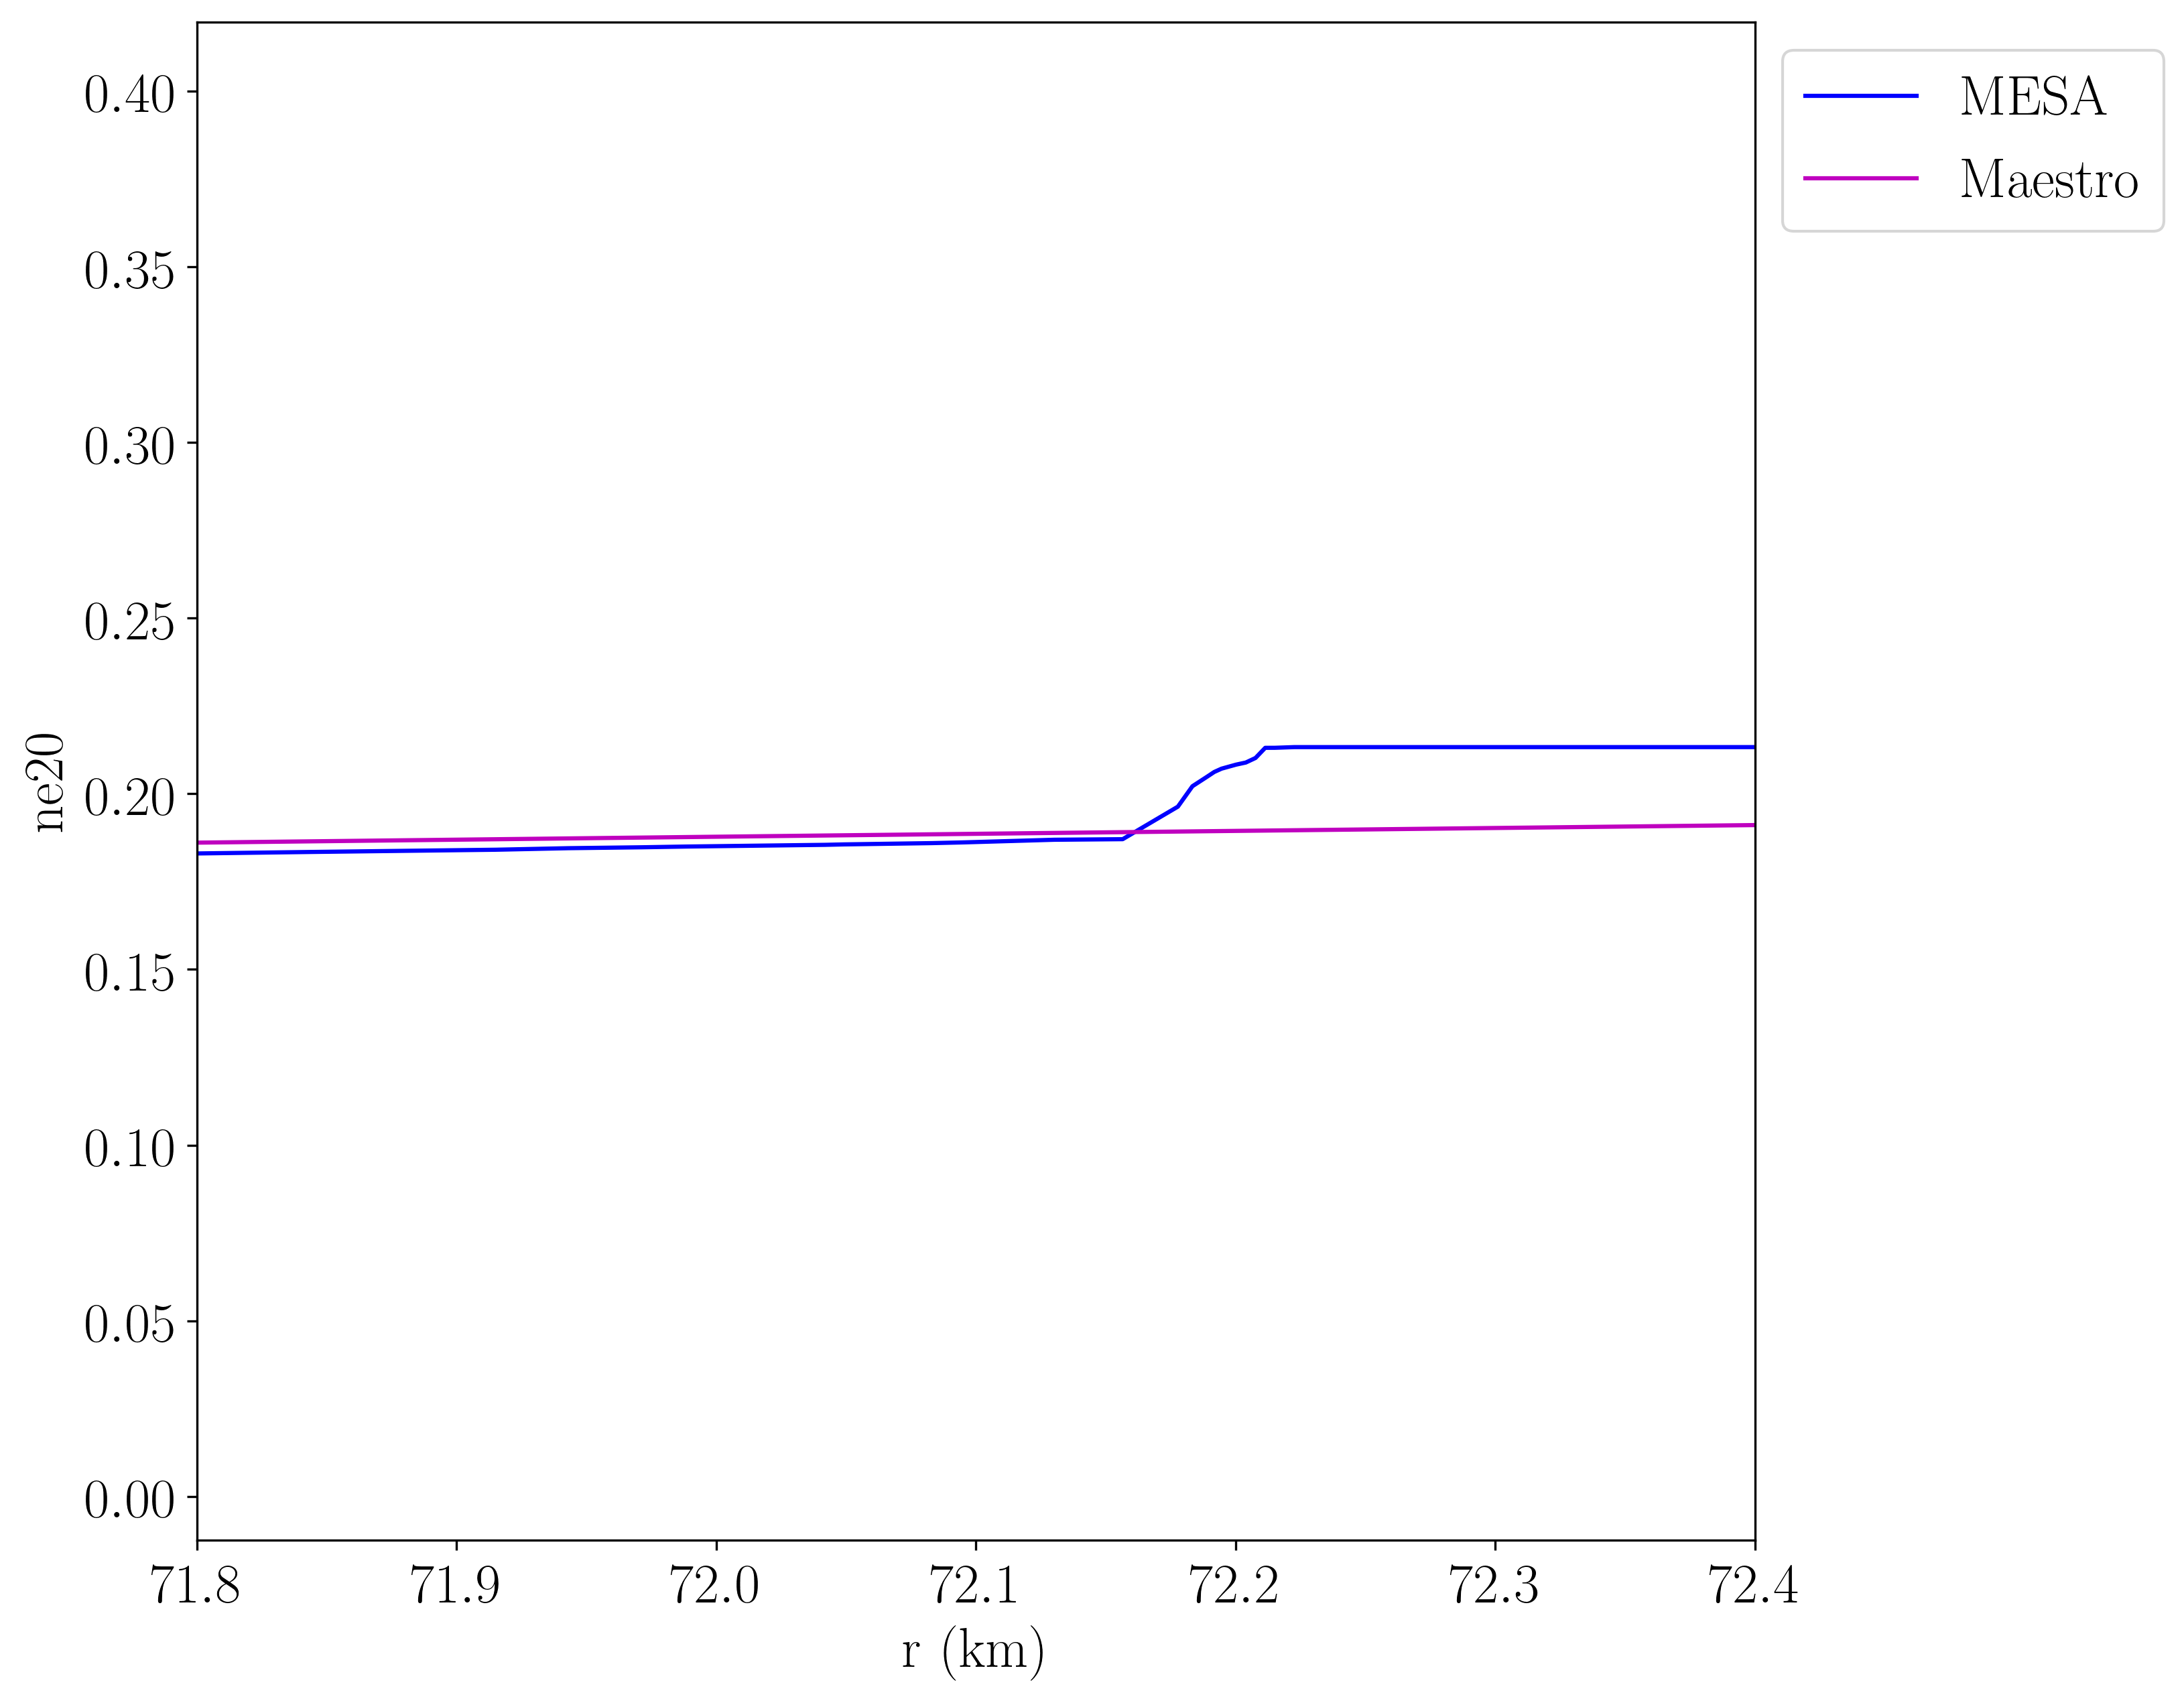

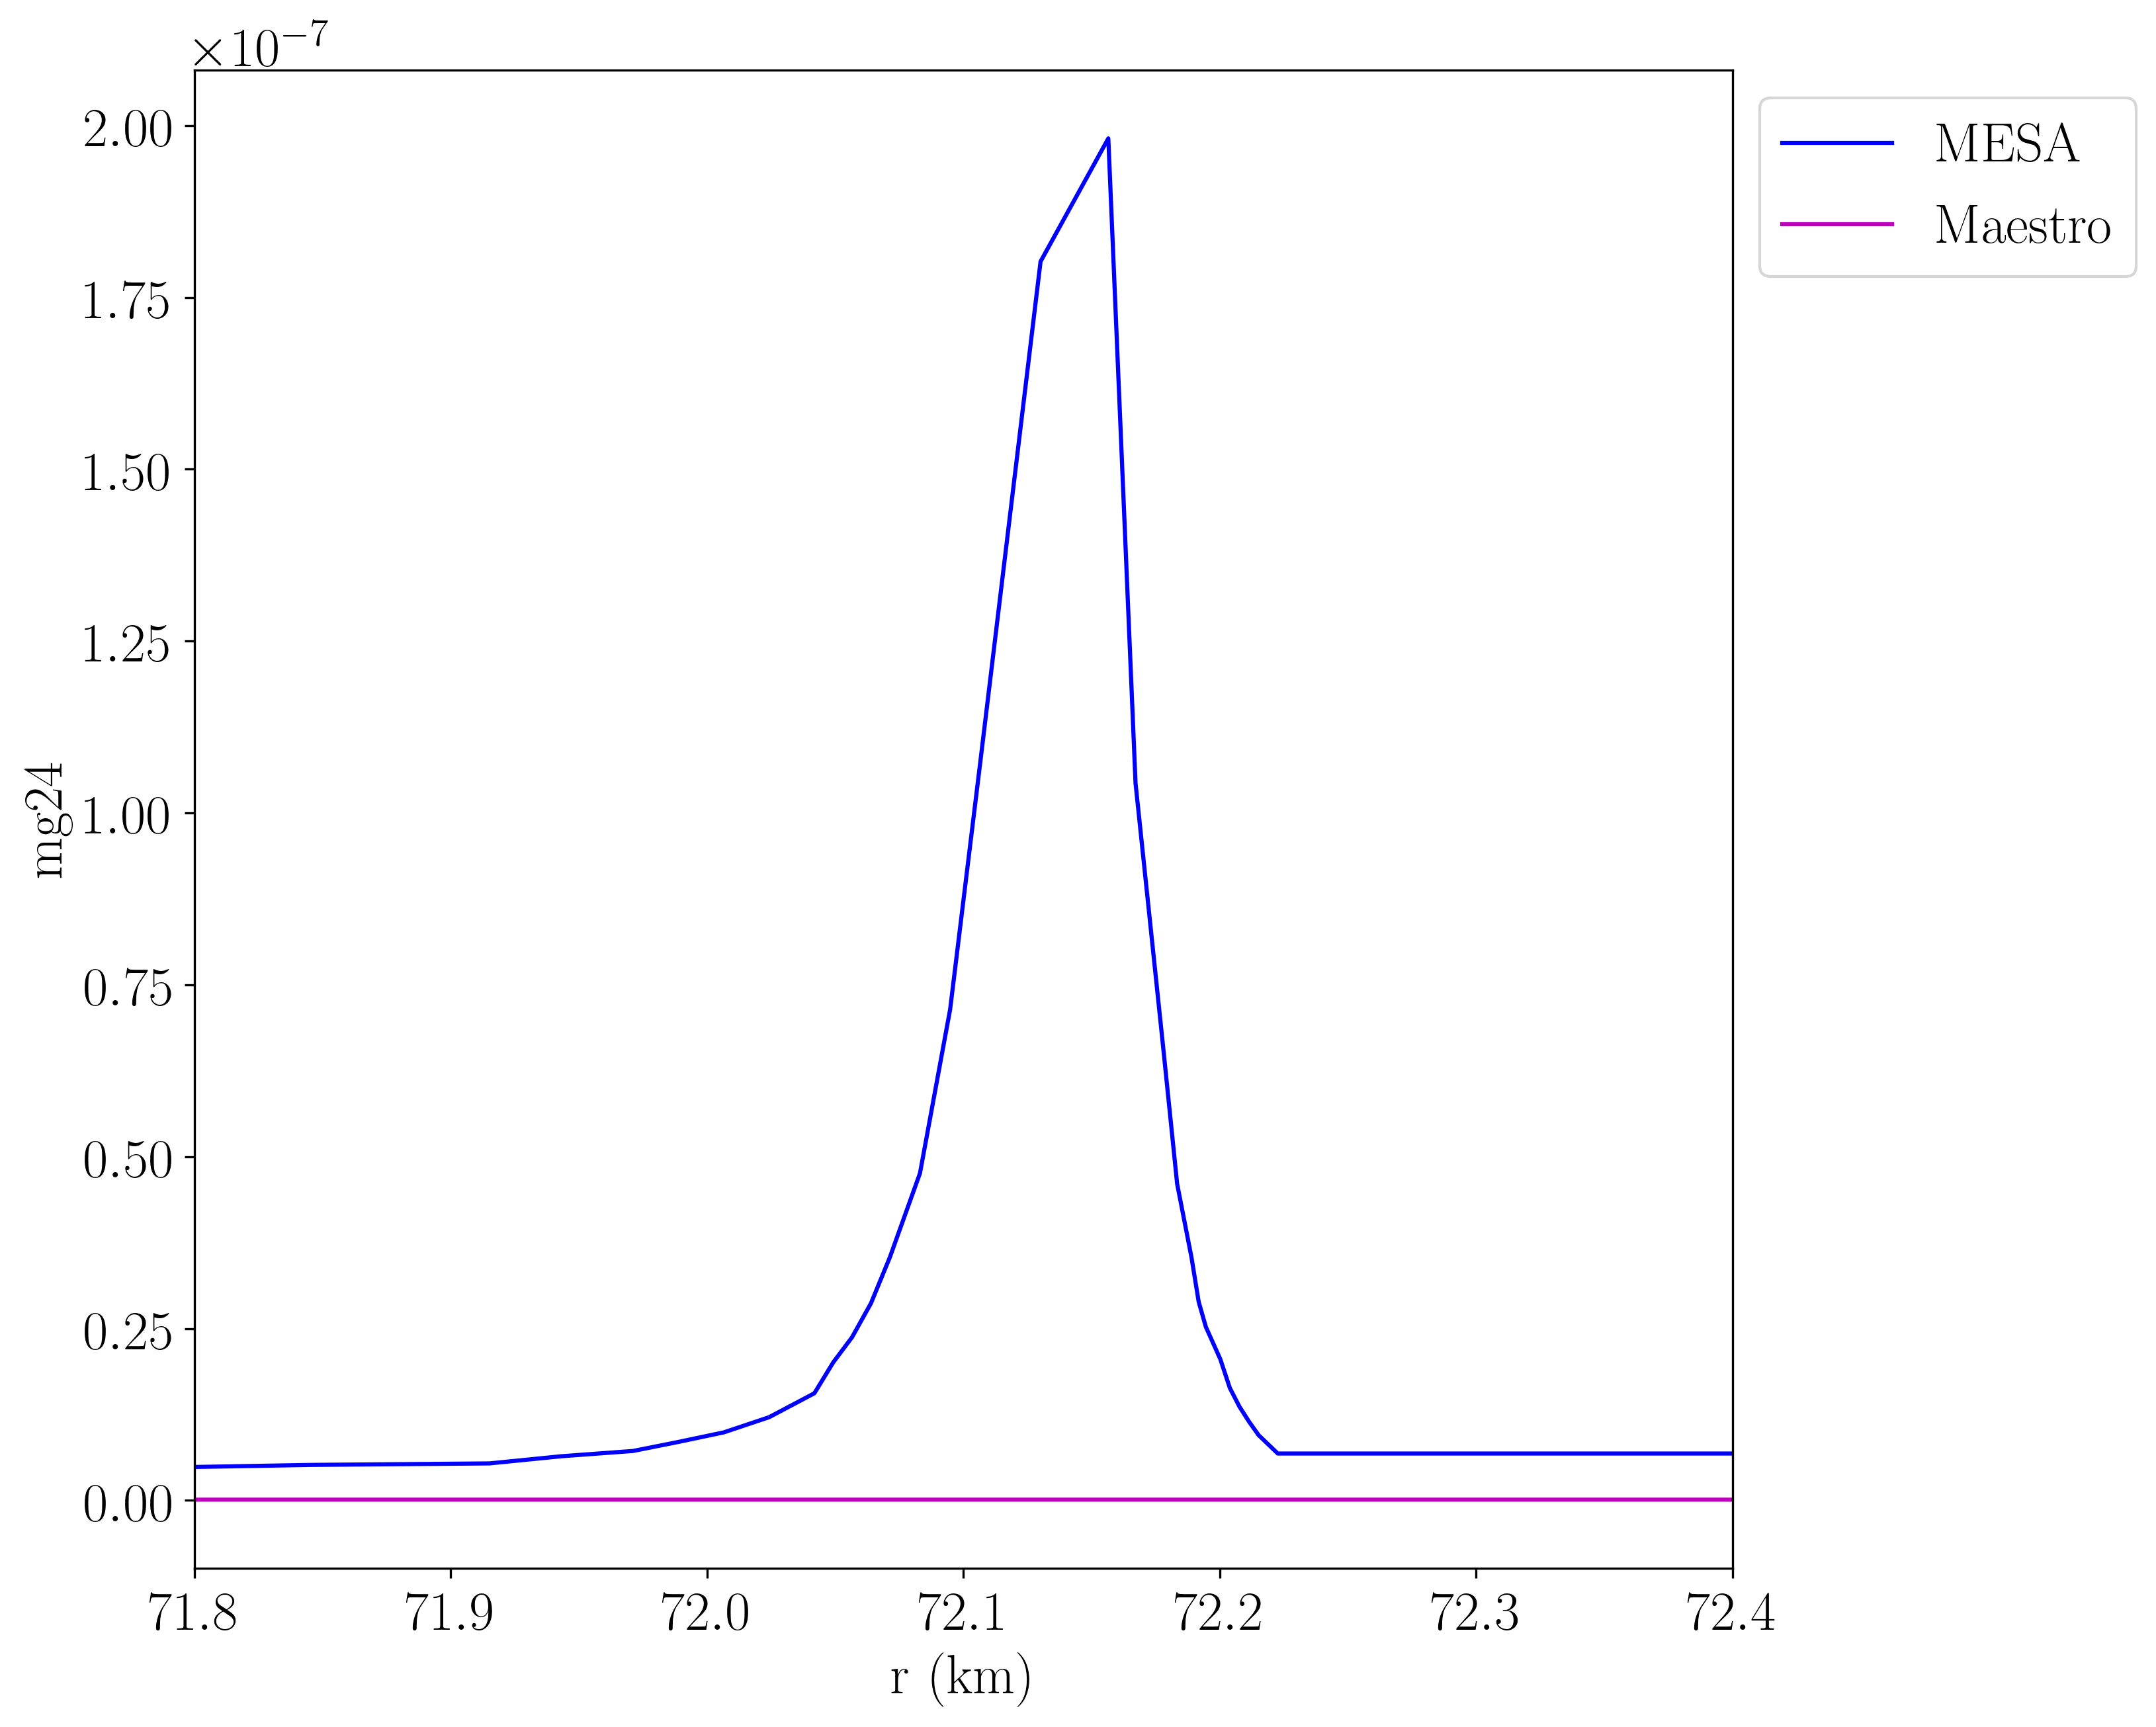

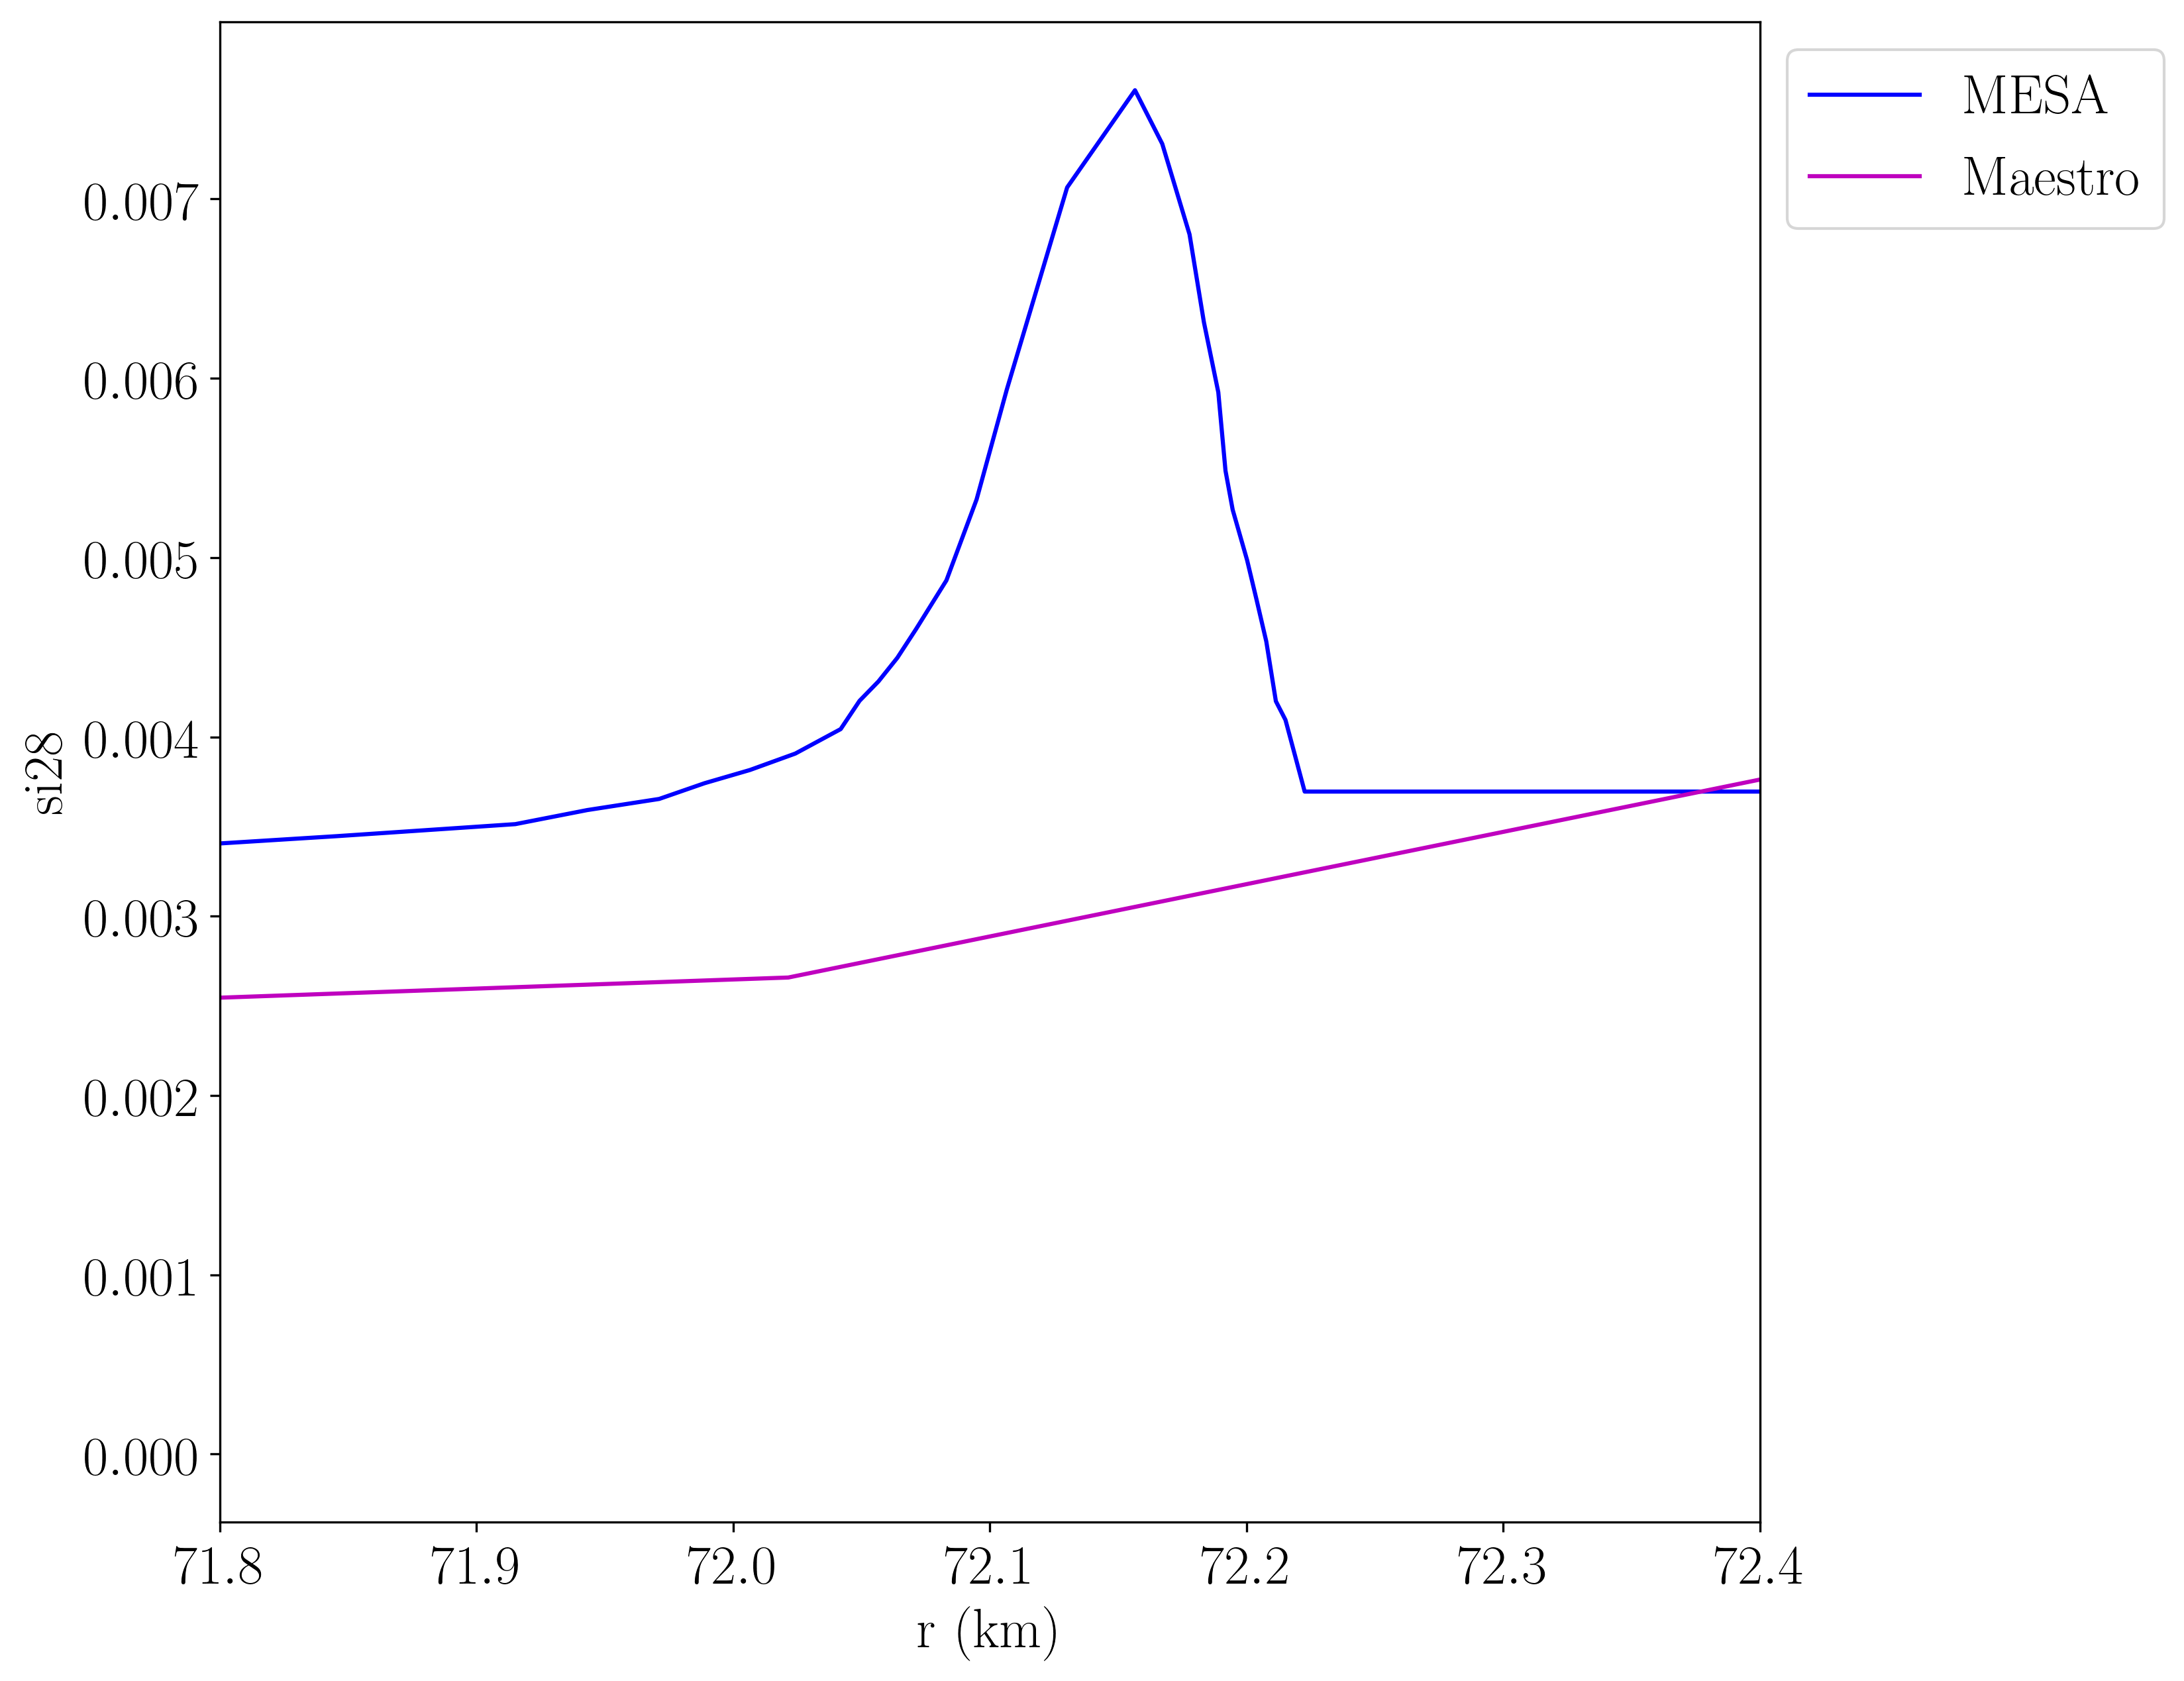

In [20]:
for s in shared_species:
    plot_field(field=s, logy=False, xlim=[71.8, 72.4])

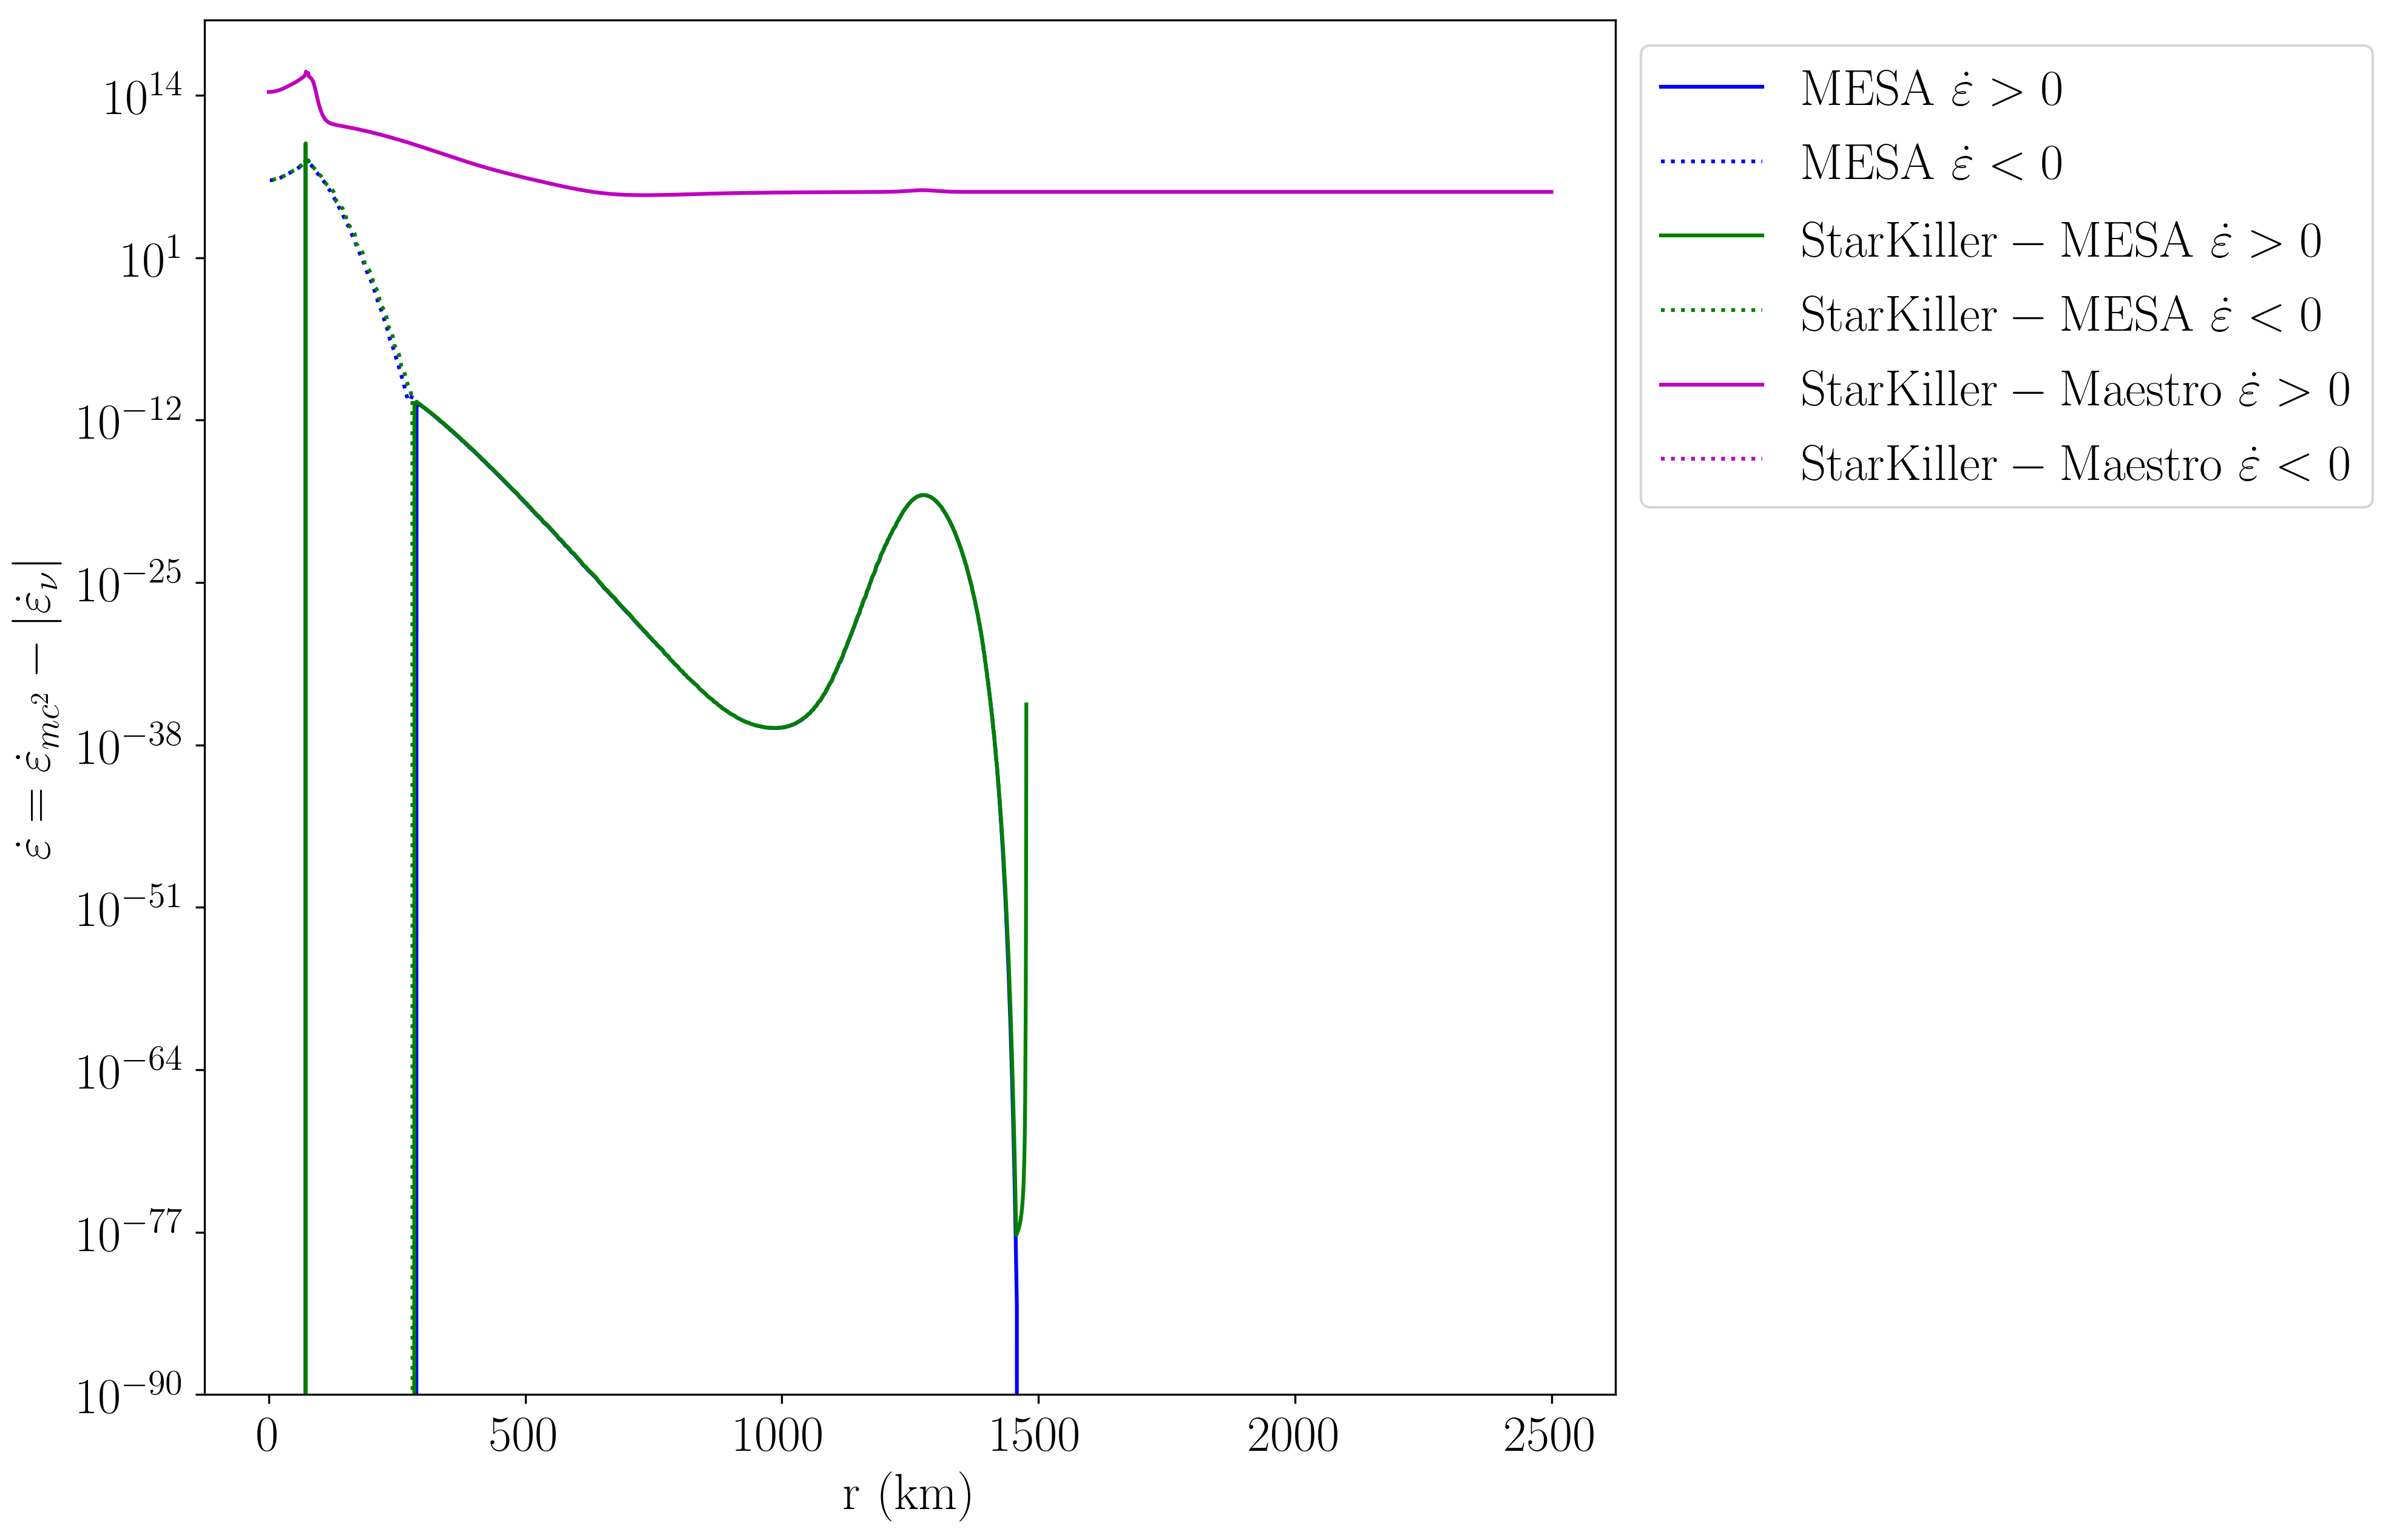

In [21]:
plot_enuc(ylim=[1.0e-90, 1.0e20])

### Zoom in on peak temperature

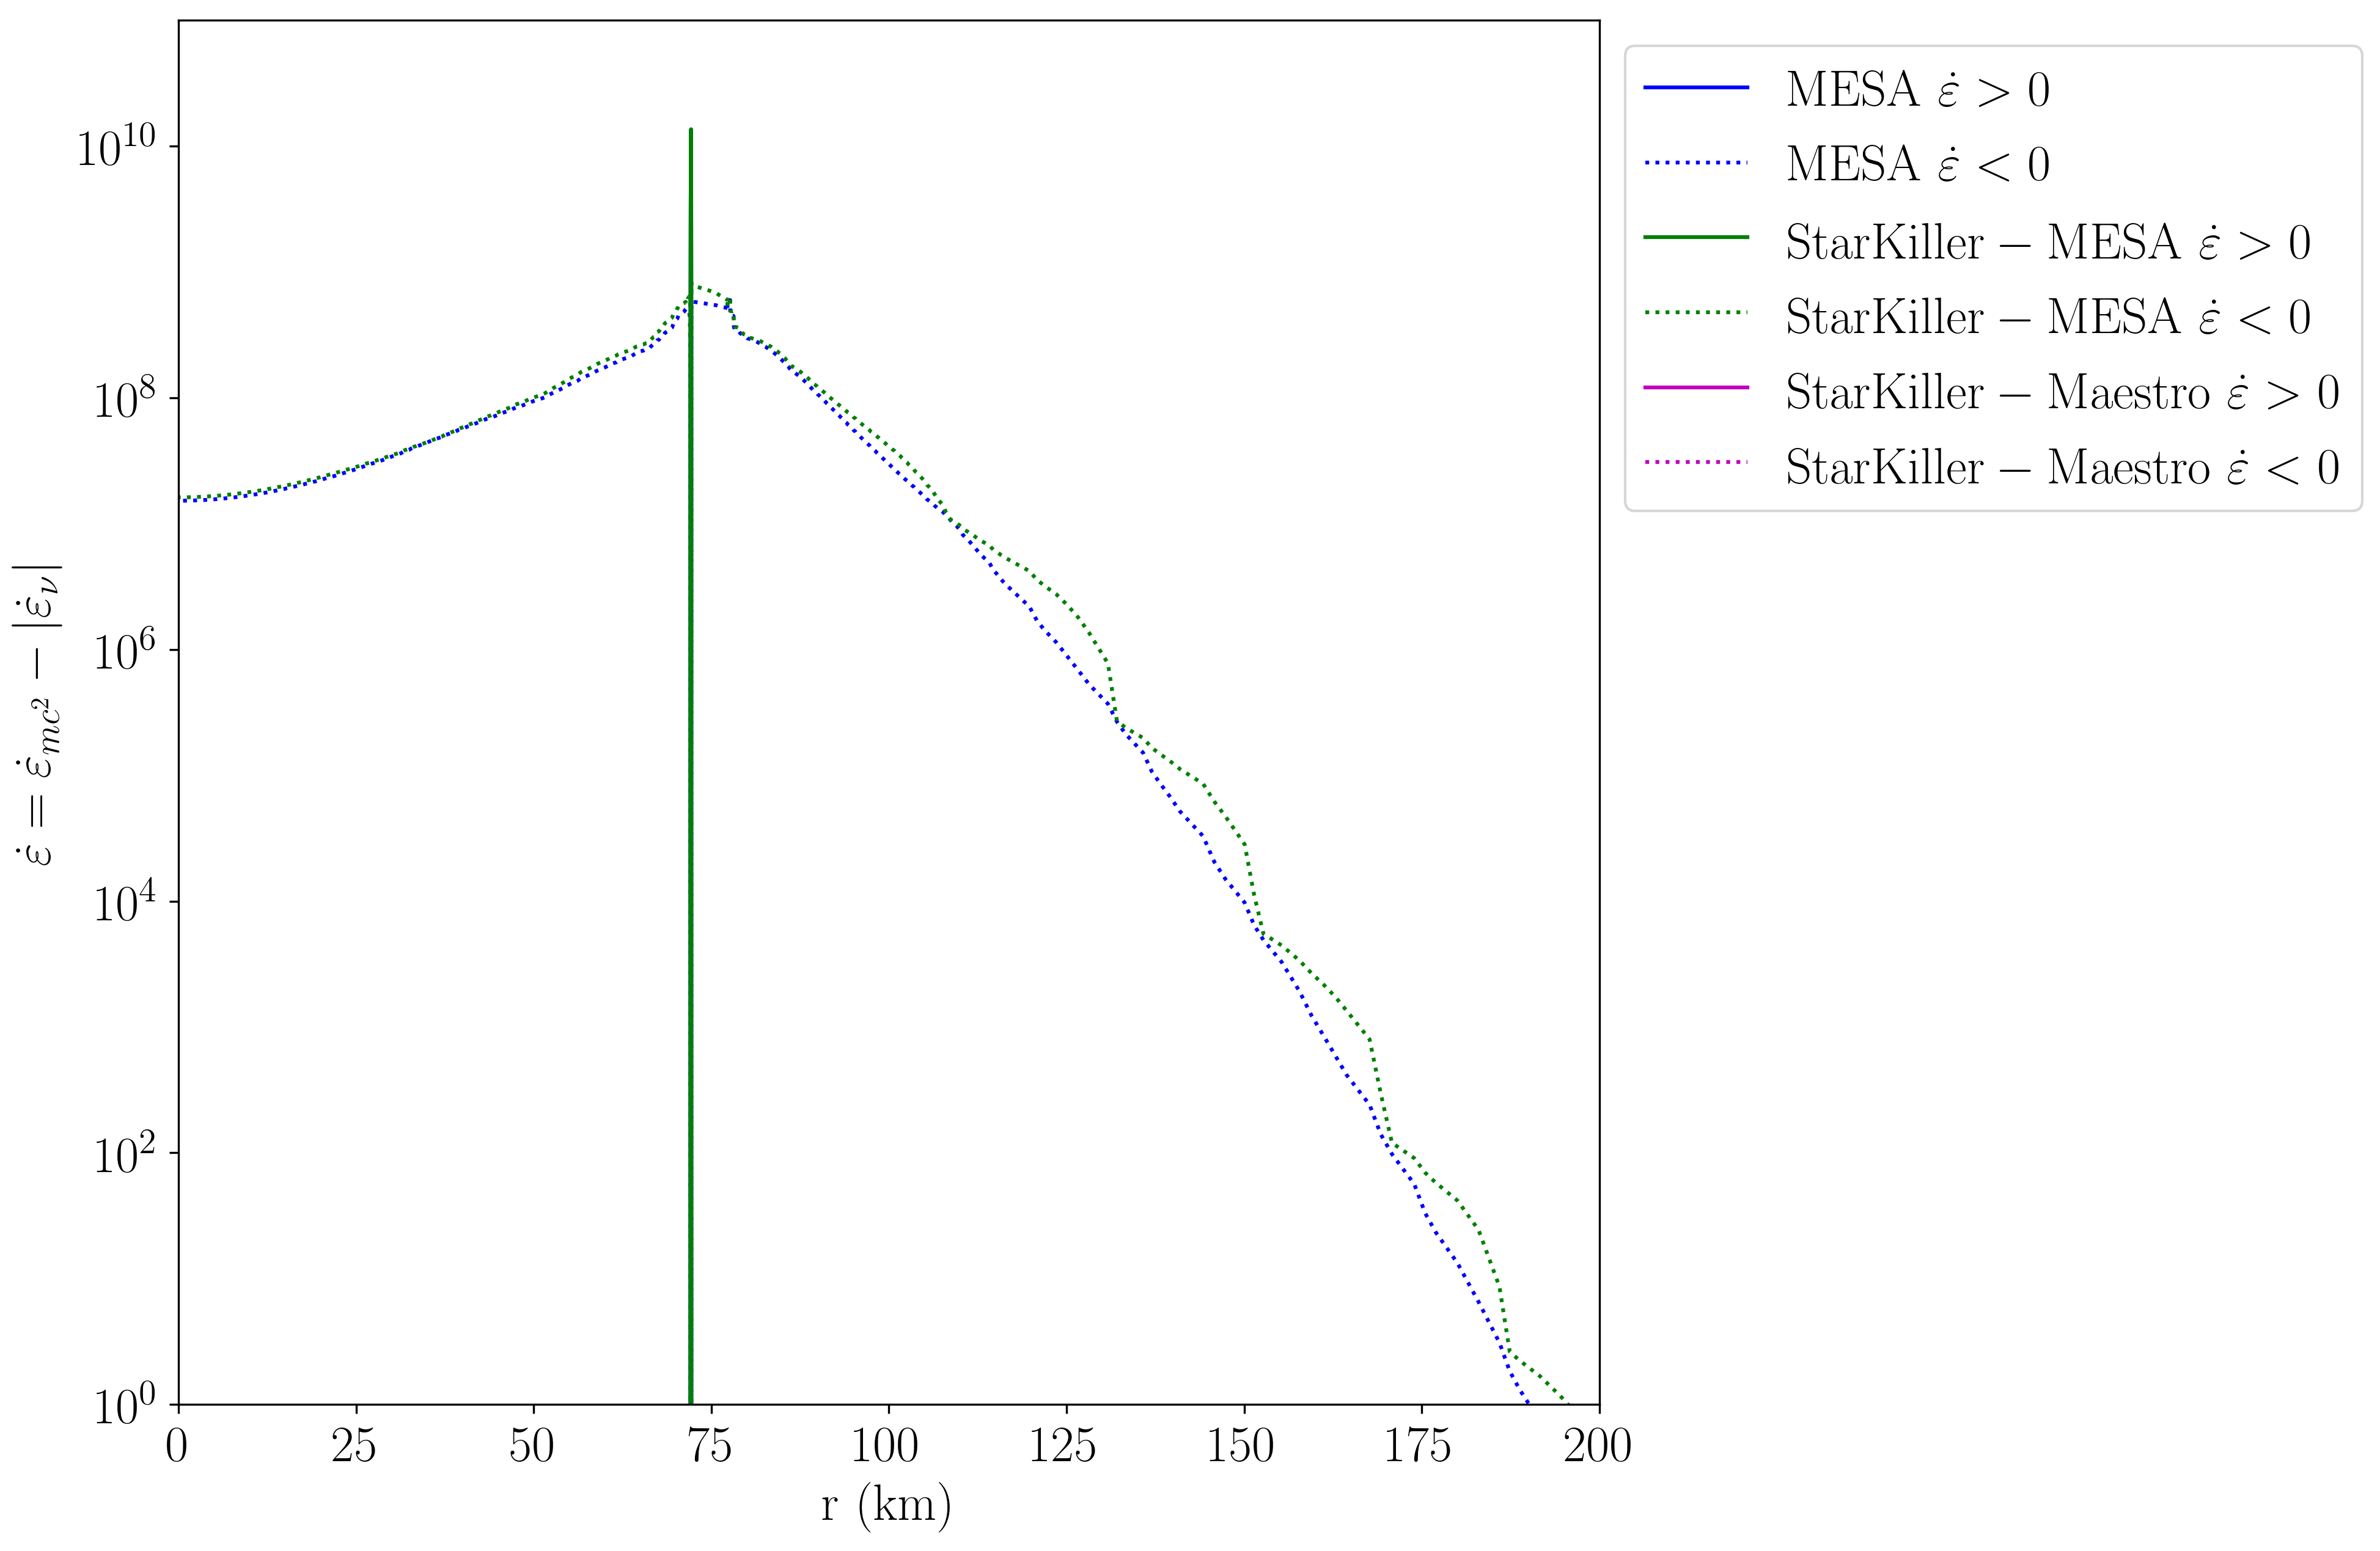

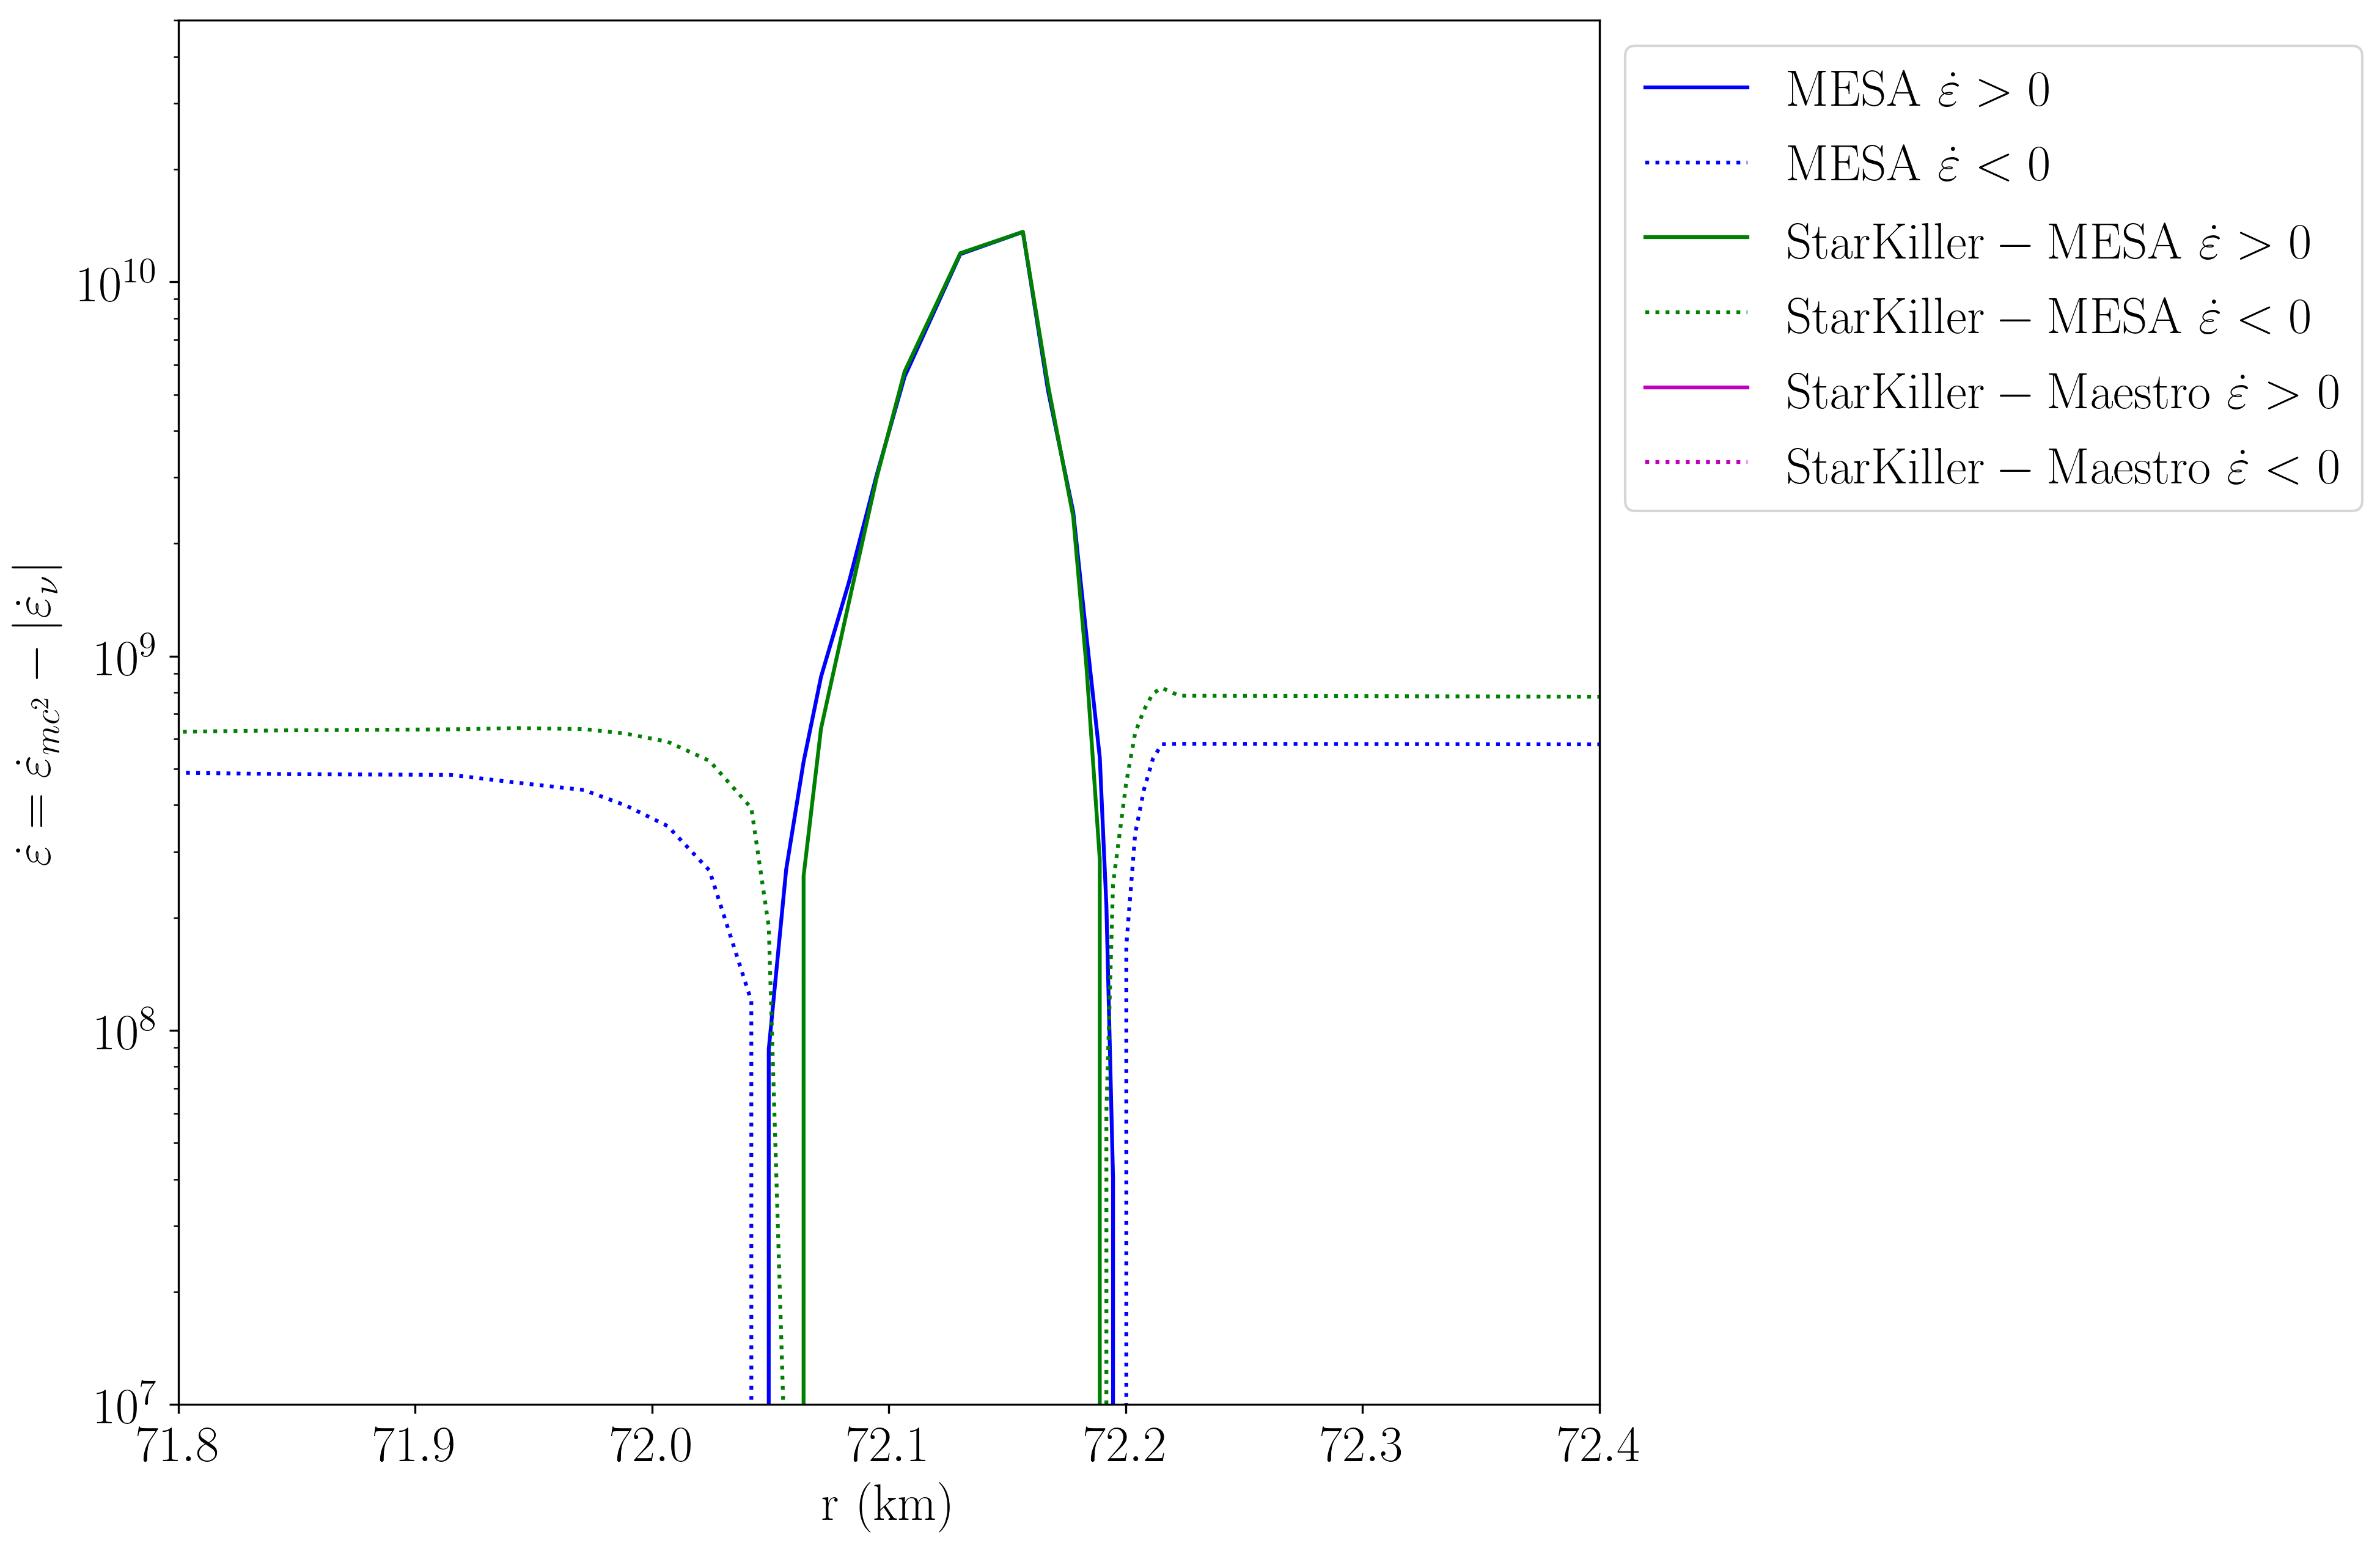

In [22]:
plot_enuc(xlim=[0.0, 200], ylim=[1.0, 1.0e11])
plot_enuc(xlim=[71.8, 72.4], ylim=[1.0e7, 5.0e10])

### Zoom in on ~300 km radius

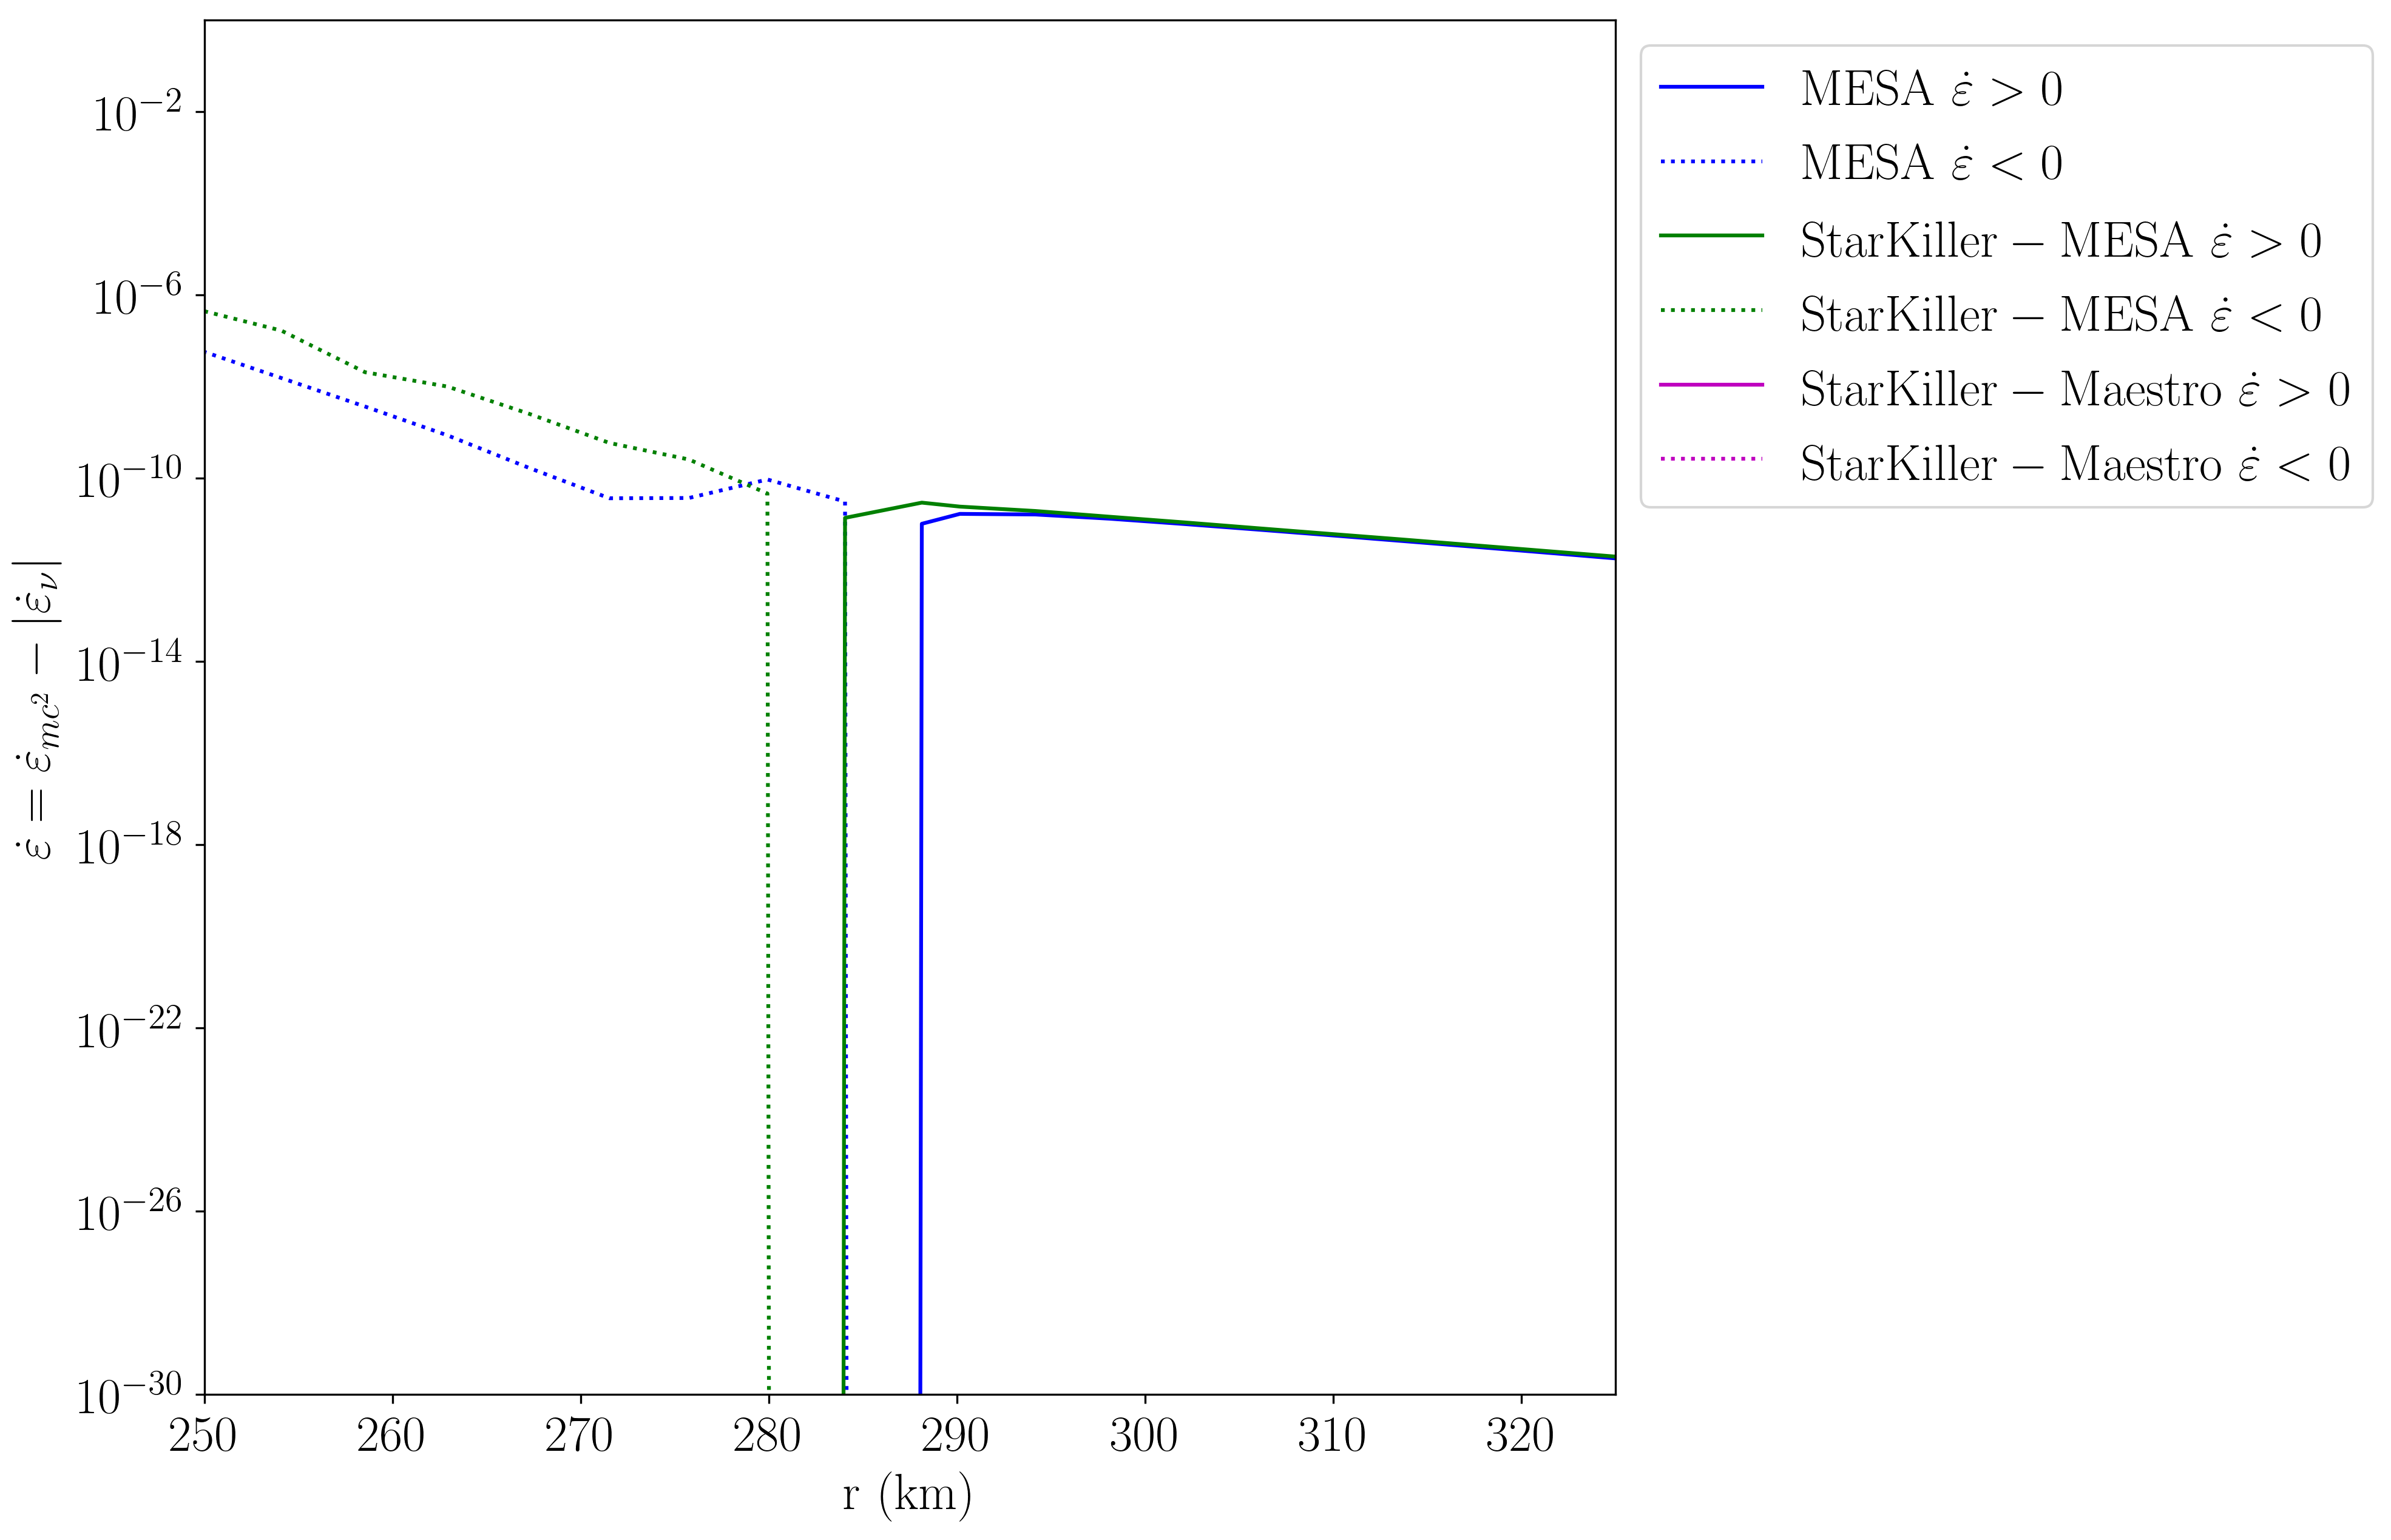

In [23]:
plot_enuc(xlim=[250, 325], ylim=[1.0e-30, 1.0])

## Print central conditions in the StarKiller-MESA model vs StarKiller-Maestro model

In [24]:
print("StarKiller-MESA model core:")
print("radius = {}".format(mesa_data.radius_cm[-1]))
print(sk_burn_results[-1].state)
sk_mesa_core = sk_burn_results[-1]

StarKiller-MESA model core:
radius = 4238.740586226362
<burn_t>{
    rho : 8357088644.807663,
    t : 656576876.0892806,
    e : 2.4376186957017733e+18,
    xn : array([0.00000000e+00, 8.96186261e-23, 5.99994533e-01, 3.92886298e-01,
       2.00272928e-09, 7.11563848e-03, 4.83382902e-16, 0.00000000e+00,
       3.52829753e-06, 0.00000000e+00, 0.00000000e+00]),
    cv : 13443541.124250965,
    cp : 13469891.007039556,
    y_e : 0.46071137008219526,
    eta : 134.03551389904297,
    cs : 1086321005.4956038,
    dx : 0.0,
    abar : 17.391340262069377,
    zbar : 8.012388199703627,
    t_old : 0.0,
    dcvdt : 0.0,
    dcpdt : 0.0,
    ydot : array([ 3.79586303e-17, -2.15615792e-17, -1.37362275e-16,  1.25751835e-12,
        1.25920951e-13, -1.38340536e-12,  5.50015407e-19,  6.16893737e-38,
        1.34778166e-17,  3.79586303e-17,  4.98304614e-25,  0.00000000e+00,
       -1.61908807e+07]),
    jac : array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 

In [25]:
print("StarKiller-Maestro model core:")
print("radius = {}".format(maestro_data.data('radius')[0]))
print(sk_maestro_burn_results[0].state)
sk_maestro_core = sk_maestro_burn_results[0]

StarKiller-Maestro model core:
radius = 24414.0625
<burn_t>{
    rho : 8348561839.89216,
    t : 656588784.4795848,
    e : 2.4368517447466404e+18,
    xn : array([1.00000046e-10, 1.00000046e-10, 5.99994546e-01, 3.92704533e-01,
       2.02122468e-09, 7.29739730e-03, 1.00000046e-10, 1.00000046e-10,
       3.52037950e-06, 1.00000046e-10, 1.00000046e-10]),
    cv : 13444115.33196229,
    cp : 13470474.786195524,
    y_e : 0.46072954661890236,
    eta : 133.98646208593343,
    cs : 1086164766.5212212,
    dx : 3.308111764344891e+126,
    abar : 17.39134014420176,
    zbar : 8.012704259733193,
    t_old : -1.565172847771641e-45,
    dcvdt : 6.90377694561214e-310,
    dcpdt : 6.9038361478143e-310,
    ydot : array([-8.75201491e-09, -3.90071307e-05, -3.83833344e-05,  1.26313315e-12,
        1.21825479e-13,  3.77558228e-05,  6.29281478e-07, -4.12147226e-09,
        4.29299280e-09, -4.63054264e-09,  2.68780493e-09,  1.34266063e+07,
        1.80862761e+14]),
    jac : array([[ 6.90377915e-310,  

In [26]:
def pdiff(x, xref):
    return 100.0*(x-xref)/xref

In [27]:
print('density % diff = {}'.format(pdiff(sk_maestro_core.state.rho, sk_mesa_core.state.rho)))
print('temperature % diff = {}'.format(pdiff(sk_maestro_core.state.t, sk_mesa_core.state.t)))
for i, (xmaestro, xmesa) in enumerate(zip(sk_maestro_core.state.xn, sk_mesa_core.state.xn)):
    print('xn({}) % diff = {}'.format(ecsn.short_species_names[i], pdiff(xmaestro, xmesa)))

density % diff = -0.1020308061564039
temperature % diff = 0.0018137084533248948
xn(h1) % diff = inf
xn(he4) % diff = 111583997908618.23
xn(o16) % diff = 2.2315182635756584e-06
xn(o20) % diff = -0.04626399846720812
xn(f20) % diff = 0.9235096463215825
xn(ne20) % diff = 2.5543571669644964
xn(mg24) % diff = 20687443.018046908
xn(al27) % diff = inf
xn(si28) % diff = -0.2244148911367492
xn(p31) % diff = inf
xn(s32) % diff = inf


/home/eugene/.local/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in double_scalars
  
